In [23]:
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
import xgboost as xgb

xgb.set_config(verbosity=0)
import joblib
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [24]:
model_p = xgb.XGBRegressor(verbosity=0)
model_p.load_model("../../emotion_classifier/model_training/models/bandai_kin5_l2p_model.json")

model_a = xgb.XGBRegressor(verbosity=0)
model_a.load_model("../../emotion_classifier/model_training/models/bandai_kin5_l2a_model.json")

model_d = xgb.XGBRegressor(verbosity=0)
model_d.load_model("../../emotion_classifier/model_training/models/bandai_kin5_l2d_model.json")

scaler = joblib.load('../../emotion_classifier/model_training/datasets/scalers/standardizers/S_BANDAI_KIN5_5frame.pkl') 

In [25]:
dataset = pd.read_csv('datasets/BANDAI_KIN5_5frame.csv')
dataset.head()

max_hand_distance  avg_l_hand_hip_distance  avg_r_hand_hip_distance  \
0           0.433596                 0.130036                 0.335475   
1           0.348051                 0.145184                 0.256784   
2           0.320294                 0.206306                 0.180224   
3           0.400389                 0.287300                 0.136974   
4           0.465923                 0.356129                 0.136171   

   max_stride_length  avg_l_hand_chest_distance  avg_r_hand_chest_distance  \
0           0.538619                   0.184473                   0.310089   
1           0.455501                   0.197954                   0.284215   
2           0.380190                   0.234406                   0.259905   
3           0.319861                   0.279208                   0.239450   
4           0.309995                   0.313229                   0.224432   

   avg_l_elbow_hip_distance  avg_r_elbow_hip_distance  \
0                  0.210679                  0.093915   
1                  0.172405                  0.104876   
2                  0.133006                  0.127385   
3                  0.112632                  0.156856   
4                  0.112950                  0.186680   

   avg_chest_pelvis_distance  avg_neck_chest_distance  ...  r_foot_speed  \
0                   0.236151                 0.223894  ...     -0.137483   
1                   0.236151                 0.223894  ...     -0.072441   
2                   0.236151                 0.223894  ...     -0.039016   
3                   0.236151                 0.223894  ...     -0.036825   
4                   0.236151                 0.223894  ...     -0.054338   

   neck_speed  l_hand_acceleration_magnitude  r_hand_acceleration_magnitude  \
0   -0.139467                       0.092920                       0.196129   
1   -0.095084                       0.048935                       0.032804   
2   -0.093423                       0.030819                       0.043059   
3   -0.101489                       0.044534                       0.054382   
4   -0.117573                       0.044670                       0.036618   

   l_foot_acceleration_magnitude  r_foot_acceleration_magnitude  \
0                       0.221155                       0.137483   
1                       0.070625                       0.072096   
2                       0.028182                       0.036532   
3                       0.015679                       0.012813   
4                       0.020074                       0.022012   

   neck_acceleration_magnitude  EMOTION_P  EMOTION_A  EMOTION_D  
0                     0.139467       0.05       -0.1        0.0  
1                     0.045111       0.05       -0.1        0.0  
2                     0.014232       0.05       -0.1        0.0  
3                     0.021506       0.05       -0.1        0.0  
4                     0.024961       0.05       -0.1        0.0  

[5 rows x 28 columns]

In [26]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

No Training Samples: 120072
No Test Samples: 30018


In [27]:
train_emotions = pd.concat([train_dataset.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)
train_emotions_OG = train_emotions.copy()

test_emotions = pd.concat([test_dataset.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)
test_emotions_OG = test_emotions.copy()

In [28]:
scaled_train = scaler.transform(train_dataset.copy())

train_emotions_p = model_p.predict(scaled_train)
train_emotions_a = model_a.predict(scaled_train)
train_emotions_d = model_d.predict(scaled_train)

rows = []
for i in range(len(train_dataset)):
    rows.append([train_emotions_p[i], train_emotions_a[i], train_emotions_d[i]])

train_emotions = pd.DataFrame(rows, columns=[
            "EMOTION_P", "EMOTION_A", "EMOTION_D"
         ])

train_emotions.head()

EMOTION_P  EMOTION_A  EMOTION_D
0   0.098109  -0.683921  -0.193172
1   0.298410   0.391875   0.594831
2  -0.599081  -0.220965  -0.271187
3   0.050604  -0.088467  -0.000938
4   0.099952   0.584574   0.403460

In [29]:
train_emotions_OG.head()

EMOTION_P  EMOTION_A  EMOTION_D
7991        0.10       -0.7       -0.2
48401       0.30        0.4        0.6
86877      -0.60       -0.3       -0.3
37398       0.05       -0.1        0.0
64001       0.10        0.6        0.4

In [30]:
# Remove LMA features whose predictions are too different from the real one
index_for_removal = []
for ind in train_emotions.index:
    predicted = np.asarray([train_emotions.iloc[ind]])
    true = np.asarray([train_emotions_OG.iloc[ind]])
    
    #print(predicted)
    #print(true)
    
    mae_errors = mean_absolute_error(true, predicted, multioutput='raw_values')
    #print(mae_errors)
    
    if(mae_errors[0] > 0.2 or mae_errors[1] > 0.2 or mae_errors[2] > 0.2):
        index_for_removal.append(ind)
        continue
    
    mae_error = mean_absolute_error(true, predicted)
    #print(mae_error)
    
    if(mae_error > 0.11):
        index_for_removal.append(ind)
        continue
    
    #print()

#print(index_for_removal)


In [31]:
train_emotions_OG.drop(train_emotions_OG.index[index_for_removal], inplace=True)
print(train_emotions_OG.shape)
train_emotions_OG.head()

(119904, 3)


EMOTION_P  EMOTION_A  EMOTION_D
7991        0.10       -0.7       -0.2
48401       0.30        0.4        0.6
86877      -0.60       -0.3       -0.3
37398       0.05       -0.1        0.0
64001       0.10        0.6        0.4

In [32]:
train_emotions.drop(train_emotions.index[index_for_removal], inplace=True)
print(train_emotions.shape)
train_emotions.head()

(119904, 3)


EMOTION_P  EMOTION_A  EMOTION_D
0   0.098109  -0.683921  -0.193172
1   0.298410   0.391875   0.594831
2  -0.599081  -0.220965  -0.271187
3   0.050604  -0.088467  -0.000938
4   0.099952   0.584574   0.403460

In [33]:
train_dataset.drop(train_dataset.index[index_for_removal], inplace=True)
print(train_dataset.shape)
train_dataset.head()

(119904, 25)


max_hand_distance  avg_l_hand_hip_distance  avg_r_hand_hip_distance  \
7991            0.602630                 0.347498                 0.274390   
48401           0.444832                 0.184111                 0.314515   
86877           0.649246                 0.533218                 0.290958   
37398           0.532783                 0.406836                 0.140066   
64001           0.531930                 0.377583                 0.457688   

       max_stride_length  avg_l_hand_chest_distance  \
7991            0.496490                   0.407072   
48401           0.366391                   0.206907   
86877           0.271105                   0.330149   
37398           0.420076                   0.404906   
64001           0.263797                   0.356504   

       avg_r_hand_chest_distance  avg_l_elbow_hip_distance  \
7991                    0.382212                  0.286269   
48401                   0.269646                  0.191741   
86877                   0.396691                  0.297813   
37398                   0.305159                  0.175144   
64001                   0.250744                  0.431649   

       avg_r_elbow_hip_distance  avg_chest_pelvis_distance  \
7991                   0.261473                   0.236151   
48401                  0.048542                   0.236151   
86877                  0.238896                   0.236151   
37398                  0.157367                   0.236151   
64001                  0.221807                   0.236151   

       avg_neck_chest_distance  ...  l_hand_speed  r_hand_speed  l_foot_speed  \
7991                  0.223894  ...     -0.077539     -0.082119     -0.047469   
48401                 0.223894  ...     -0.206011     -0.172155     -0.120550   
86877                 0.223894  ...     -0.016227     -0.016020     -0.011330   
37398                 0.223894  ...     -0.047654     -0.061193     -0.071313   
64001                 0.223894  ...     -0.083866     -0.071846     -0.126810   

       r_foot_speed  neck_speed  l_hand_acceleration_magnitude  \
7991      -0.100894   -0.064526                       0.004583   
48401     -0.230420   -0.182171                       0.023884   
86877     -0.017397   -0.017563                       0.016749   
37398     -0.016612   -0.055567                       0.010656   
64001     -0.054032   -0.087489                       0.026852   

       r_hand_acceleration_magnitude  l_foot_acceleration_magnitude  \
7991                        0.008522                       0.008449   
48401                       0.029572                       0.008665   
86877                       0.012871                       0.011754   
37398                       0.005239                       0.006021   
64001                       0.024994                       0.021706   

       r_foot_acceleration_magnitude  neck_acceleration_magnitude  
7991                        0.015316                     0.007314  
48401                       0.025773                     0.026490  
86877                       0.015697                     0.011488  
37398                       0.011304                     0.004574  
64001                       0.015967                     0.015007  

[5 rows x 25 columns]

In [34]:
scaled_test = scaler.transform(test_dataset.copy())

test_emotions_p = model_p.predict(scaled_test)
test_emotions_a = model_a.predict(scaled_test)
test_emotions_d = model_d.predict(scaled_test)

rows = []
for i in range(len(test_dataset)):
    rows.append([test_emotions_p[i], test_emotions_a[i], test_emotions_d[i]])

test_emotions = pd.DataFrame(rows, columns=[
            "EMOTION_P", "EMOTION_A", "EMOTION_D"
         ])

test_emotions.head()

EMOTION_P  EMOTION_A  EMOTION_D
0  -0.395791   0.660547   0.721769
1  -0.537360   0.475400   0.586001
2  -0.408209   0.253663  -0.099181
3  -0.521990   0.623710  -0.731291
4   0.077560   0.599291   0.393933

In [35]:
test_emotions_OG.head()

EMOTION_P  EMOTION_A  EMOTION_D
88383       -0.5       0.70        0.9
83108       -0.5       0.70        0.9
99477       -0.4       0.25       -0.1
79303       -0.5       0.70       -0.8
35754        0.1       0.60        0.4

In [36]:
# Remove LMA features whose predictions are too different from the real one
index_for_removal = []
for ind in test_emotions.index:
    predicted = np.asarray([test_emotions.iloc[ind]])
    true = np.asarray([test_emotions_OG.iloc[ind]])
    
    #print(predicted)
    #print(true)
    
    mae_errors = mean_absolute_error(true, predicted, multioutput='raw_values')
    #print(mae_errors)
    
    if(mae_errors[0] > 0.2 or mae_errors[1] > 0.2 or mae_errors[2] > 0.2):
        index_for_removal.append(ind)
        continue
    
    mae_error = mean_absolute_error(true, predicted)
    #print(mae_error)
    
    if(mae_error > 0.11):
        index_for_removal.append(ind)
        continue
    
    #print()

#print(index_for_removal)


In [37]:
test_emotions_OG.drop(test_emotions_OG.index[index_for_removal], inplace=True)
print(test_emotions_OG.shape)
test_emotions_OG.head()

(23484, 3)


EMOTION_P  EMOTION_A  EMOTION_D
88383       -0.5       0.70        0.9
99477       -0.4       0.25       -0.1
79303       -0.5       0.70       -0.8
35754        0.1       0.60        0.4
72604        0.3       0.40        0.6

In [38]:
test_emotions.drop(test_emotions.index[index_for_removal], inplace=True)
print(test_emotions.shape)
test_emotions.head()

(23484, 3)


EMOTION_P  EMOTION_A  EMOTION_D
0  -0.395791   0.660547   0.721769
2  -0.408209   0.253663  -0.099181
3  -0.521990   0.623710  -0.731291
4   0.077560   0.599291   0.393933
5   0.292590   0.403700   0.577498

In [39]:
test_dataset.drop(test_dataset.index[index_for_removal], inplace=True)
print(test_dataset.shape)
test_dataset.head()

(23484, 25)


max_hand_distance  avg_l_hand_hip_distance  avg_r_hand_hip_distance  \
88383           0.549184                 0.281815                 0.279469   
99477           0.400719                 0.242280                 0.324411   
79303           0.386424                 0.170959                 0.229007   
35754           0.587735                 0.401916                 0.247119   
72604           0.851596                 0.373309                 0.491440   

       max_stride_length  avg_l_hand_chest_distance  \
88383           0.505407                   0.395673   
99477           0.353452                   0.356445   
79303           0.290054                   0.331291   
35754           0.461640                   0.313580   
72604           0.701554                   0.431898   

       avg_r_hand_chest_distance  avg_l_elbow_hip_distance  \
88383                   0.393583                  0.244467   
99477                   0.095577                  0.259604   
79303                   0.362657                  0.187027   
35754                   0.330397                  0.237292   
72604                   0.476423                  0.327115   

       avg_r_elbow_hip_distance  avg_chest_pelvis_distance  \
88383                  0.223834                   0.236151   
99477                  0.191026                   0.236151   
79303                  0.225193                   0.236151   
35754                  0.299034                   0.236151   
72604                  0.341546                   0.236151   

       avg_neck_chest_distance  ...  l_hand_speed  r_hand_speed  l_foot_speed  \
88383                 0.223894  ...     -0.012128     -0.001969     -0.003496   
99477                 0.223894  ...     -0.002855     -0.003969     -0.002810   
79303                 0.223894  ...     -0.003533     -0.003362     -0.002320   
35754                 0.223894  ...     -0.164042     -0.055589     -0.036160   
72604                 0.223894  ...     -0.086000     -0.081288     -0.072999   

       r_foot_speed  neck_speed  l_hand_acceleration_magnitude  \
88383     -0.003699   -0.004930                       0.002215   
99477     -0.002380   -0.004671                       0.001502   
79303     -0.002692   -0.003433                       0.000323   
35754     -0.130217   -0.086008                       0.068072   
72604     -0.058706   -0.087167                       0.015013   

       r_hand_acceleration_magnitude  l_foot_acceleration_magnitude  \
88383                       0.004994                       0.002336   
99477                       0.001002                       0.001591   
79303                       0.000208                       0.000341   
35754                       0.090580                       0.017025   
72604                       0.005170                       0.013299   

       r_foot_acceleration_magnitude  neck_acceleration_magnitude  
88383                       0.002431                     0.000951  
99477                       0.001535                     0.001840  
79303                       0.000265                     0.000253  
35754                       0.028310                     0.020332  
72604                       0.011689                     0.008801  

[5 rows x 25 columns]


# AutoEncoder


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [41]:
"""
self.encoder = tf.keras.Sequential([
            layers.Dense(20, activation='relu'),
            layers.Dense(15, activation='linear'),
            layers.Dense(10, activation='relu'),
            layers.Dense(latent_dim, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(10, activation='relu'),
            layers.Dense(15, activation='linear'),
            layers.Dense(20, activation='relu'),
            layers.Dense(25, activation='linear'),
        ])
epochs = 128
"""

latent_dim = 5

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        
        self.encoder = tf.keras.Sequential([
            layers.Dense(20, activation='relu'),
            layers.Dense(15, activation='linear'),
            layers.Dense(10, activation='relu'),
            layers.Dense(latent_dim, activation='linear'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(10, activation='relu'),
            layers.Dense(15, activation='linear'),
            layers.Dense(20, activation='relu'),
            layers.Dense(25, activation='linear'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

## Train

In [42]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [43]:
autoencoder.fit(train_dataset, train_dataset,
                epochs=512,
                shuffle=True,
                validation_data=(test_dataset, test_dataset), verbose=2)

Epoch 1/512
3747/3747 - 5s - loss: 0.0020 - val_loss: 7.6730e-04 - 5s/epoch - 1ms/step
Epoch 2/512
3747/3747 - 4s - loss: 7.4727e-04 - val_loss: 7.1224e-04 - 4s/epoch - 1ms/step
Epoch 3/512
3747/3747 - 4s - loss: 7.1705e-04 - val_loss: 7.0602e-04 - 4s/epoch - 1ms/step
Epoch 4/512
3747/3747 - 4s - loss: 6.7470e-04 - val_loss: 6.3163e-04 - 4s/epoch - 1ms/step
Epoch 5/512
3747/3747 - 4s - loss: 6.3843e-04 - val_loss: 6.1475e-04 - 4s/epoch - 1ms/step
Epoch 6/512
3747/3747 - 5s - loss: 6.2886e-04 - val_loss: 6.0968e-04 - 5s/epoch - 1ms/step
Epoch 7/512
3747/3747 - 4s - loss: 6.2341e-04 - val_loss: 6.0341e-04 - 4s/epoch - 1ms/step
Epoch 8/512
3747/3747 - 4s - loss: 6.1830e-04 - val_loss: 5.9482e-04 - 4s/epoch - 1ms/step
Epoch 9/512
3747/3747 - 4s - loss: 6.1043e-04 - val_loss: 5.8254e-04 - 4s/epoch - 1ms/step
Epoch 10/512
3747/3747 - 4s - loss: 5.9870e-04 - val_loss: 5.6346e-04 - 4s/epoch - 1ms/step
Epoch 11/512
3747/3747 - 4s - loss: 5.9070e-04 - val_loss: 5.6655e-04 - 4s/epoch - 1ms/step
E

Epoch 91/512
3747/3747 - 5s - loss: 4.6809e-04 - val_loss: 4.4949e-04 - 5s/epoch - 1ms/step
Epoch 92/512
3747/3747 - 4s - loss: 4.6770e-04 - val_loss: 4.3960e-04 - 4s/epoch - 1ms/step
Epoch 93/512
3747/3747 - 5s - loss: 4.7141e-04 - val_loss: 4.4522e-04 - 5s/epoch - 1ms/step
Epoch 94/512
3747/3747 - 4s - loss: 4.6822e-04 - val_loss: 4.3946e-04 - 4s/epoch - 1ms/step
Epoch 95/512
3747/3747 - 5s - loss: 4.6823e-04 - val_loss: 4.3535e-04 - 5s/epoch - 1ms/step
Epoch 96/512
3747/3747 - 5s - loss: 4.6612e-04 - val_loss: 4.4004e-04 - 5s/epoch - 1ms/step
Epoch 97/512
3747/3747 - 4s - loss: 4.6647e-04 - val_loss: 4.4664e-04 - 4s/epoch - 1ms/step
Epoch 98/512
3747/3747 - 5s - loss: 4.6922e-04 - val_loss: 4.4986e-04 - 5s/epoch - 1ms/step
Epoch 99/512
3747/3747 - 5s - loss: 4.6644e-04 - val_loss: 4.4139e-04 - 5s/epoch - 1ms/step
Epoch 100/512
3747/3747 - 4s - loss: 4.6625e-04 - val_loss: 4.3952e-04 - 4s/epoch - 1ms/step
Epoch 101/512
3747/3747 - 5s - loss: 4.6592e-04 - val_loss: 4.4565e-04 - 5s/epo

Epoch 180/512
3747/3747 - 4s - loss: 4.4909e-04 - val_loss: 4.4719e-04 - 4s/epoch - 1ms/step
Epoch 181/512
3747/3747 - 5s - loss: 4.5053e-04 - val_loss: 4.2564e-04 - 5s/epoch - 1ms/step
Epoch 182/512
3747/3747 - 4s - loss: 4.4974e-04 - val_loss: 4.4248e-04 - 4s/epoch - 1ms/step
Epoch 183/512
3747/3747 - 7s - loss: 4.4887e-04 - val_loss: 4.3055e-04 - 7s/epoch - 2ms/step
Epoch 184/512
3747/3747 - 5s - loss: 4.5059e-04 - val_loss: 4.2878e-04 - 5s/epoch - 1ms/step
Epoch 185/512
3747/3747 - 4s - loss: 4.4885e-04 - val_loss: 4.2003e-04 - 4s/epoch - 1ms/step
Epoch 186/512
3747/3747 - 4s - loss: 4.4815e-04 - val_loss: 4.1998e-04 - 4s/epoch - 1ms/step
Epoch 187/512
3747/3747 - 4s - loss: 4.4803e-04 - val_loss: 4.2427e-04 - 4s/epoch - 1ms/step
Epoch 188/512
3747/3747 - 4s - loss: 4.4808e-04 - val_loss: 4.2586e-04 - 4s/epoch - 1ms/step
Epoch 189/512
3747/3747 - 4s - loss: 4.5141e-04 - val_loss: 4.2464e-04 - 4s/epoch - 1ms/step
Epoch 190/512
3747/3747 - 4s - loss: 4.4866e-04 - val_loss: 4.2827e-04

3747/3747 - 4s - loss: 4.3800e-04 - val_loss: 4.0831e-04 - 4s/epoch - 1ms/step
Epoch 269/512
3747/3747 - 5s - loss: 4.3609e-04 - val_loss: 4.2878e-04 - 5s/epoch - 1ms/step
Epoch 270/512
3747/3747 - 7s - loss: 4.3734e-04 - val_loss: 4.0553e-04 - 7s/epoch - 2ms/step
Epoch 271/512
3747/3747 - 4s - loss: 4.3588e-04 - val_loss: 4.0935e-04 - 4s/epoch - 1ms/step
Epoch 272/512
3747/3747 - 4s - loss: 4.3682e-04 - val_loss: 4.0881e-04 - 4s/epoch - 1ms/step
Epoch 273/512
3747/3747 - 5s - loss: 4.3694e-04 - val_loss: 4.0743e-04 - 5s/epoch - 1ms/step
Epoch 274/512
3747/3747 - 4s - loss: 4.3631e-04 - val_loss: 4.0725e-04 - 4s/epoch - 1ms/step
Epoch 275/512
3747/3747 - 4s - loss: 4.3618e-04 - val_loss: 4.2148e-04 - 4s/epoch - 1ms/step
Epoch 276/512
3747/3747 - 4s - loss: 4.3668e-04 - val_loss: 4.1398e-04 - 4s/epoch - 1ms/step
Epoch 277/512
3747/3747 - 4s - loss: 4.3655e-04 - val_loss: 4.3039e-04 - 4s/epoch - 1ms/step
Epoch 278/512
3747/3747 - 4s - loss: 4.3511e-04 - val_loss: 4.1417e-04 - 4s/epoch - 

Epoch 357/512
3747/3747 - 5s - loss: 4.3356e-04 - val_loss: 4.1259e-04 - 5s/epoch - 1ms/step
Epoch 358/512
3747/3747 - 5s - loss: 4.3384e-04 - val_loss: 4.1177e-04 - 5s/epoch - 1ms/step
Epoch 359/512
3747/3747 - 5s - loss: 4.3425e-04 - val_loss: 4.0342e-04 - 5s/epoch - 1ms/step
Epoch 360/512
3747/3747 - 5s - loss: 4.3339e-04 - val_loss: 4.1199e-04 - 5s/epoch - 1ms/step
Epoch 361/512
3747/3747 - 4s - loss: 4.3288e-04 - val_loss: 4.1414e-04 - 4s/epoch - 1ms/step
Epoch 362/512
3747/3747 - 5s - loss: 4.3254e-04 - val_loss: 4.1407e-04 - 5s/epoch - 1ms/step
Epoch 363/512
3747/3747 - 4s - loss: 4.3377e-04 - val_loss: 4.1366e-04 - 4s/epoch - 1ms/step
Epoch 364/512
3747/3747 - 4s - loss: 4.3343e-04 - val_loss: 4.1491e-04 - 4s/epoch - 1ms/step
Epoch 365/512
3747/3747 - 5s - loss: 4.3343e-04 - val_loss: 4.1477e-04 - 5s/epoch - 1ms/step
Epoch 366/512
3747/3747 - 4s - loss: 4.3414e-04 - val_loss: 4.0293e-04 - 4s/epoch - 1ms/step
Epoch 367/512
3747/3747 - 4s - loss: 4.3250e-04 - val_loss: 4.0726e-04

3747/3747 - 4s - loss: 4.3320e-04 - val_loss: 4.0364e-04 - 4s/epoch - 1ms/step
Epoch 446/512
3747/3747 - 4s - loss: 4.3185e-04 - val_loss: 4.1472e-04 - 4s/epoch - 1ms/step
Epoch 447/512
3747/3747 - 5s - loss: 4.3255e-04 - val_loss: 4.1143e-04 - 5s/epoch - 1ms/step
Epoch 448/512
3747/3747 - 5s - loss: 4.3238e-04 - val_loss: 4.0639e-04 - 5s/epoch - 1ms/step
Epoch 449/512
3747/3747 - 4s - loss: 4.3289e-04 - val_loss: 4.0342e-04 - 4s/epoch - 1ms/step
Epoch 450/512
3747/3747 - 4s - loss: 4.3240e-04 - val_loss: 4.0441e-04 - 4s/epoch - 1ms/step
Epoch 451/512
3747/3747 - 4s - loss: 4.3208e-04 - val_loss: 4.0905e-04 - 4s/epoch - 1ms/step
Epoch 452/512
3747/3747 - 4s - loss: 4.3188e-04 - val_loss: 4.0471e-04 - 4s/epoch - 1ms/step
Epoch 453/512
3747/3747 - 5s - loss: 4.3161e-04 - val_loss: 4.0419e-04 - 5s/epoch - 1ms/step
Epoch 454/512
3747/3747 - 5s - loss: 4.3225e-04 - val_loss: 4.0903e-04 - 5s/epoch - 1ms/step
Epoch 455/512
3747/3747 - 5s - loss: 4.3219e-04 - val_loss: 4.1049e-04 - 5s/epoch - 

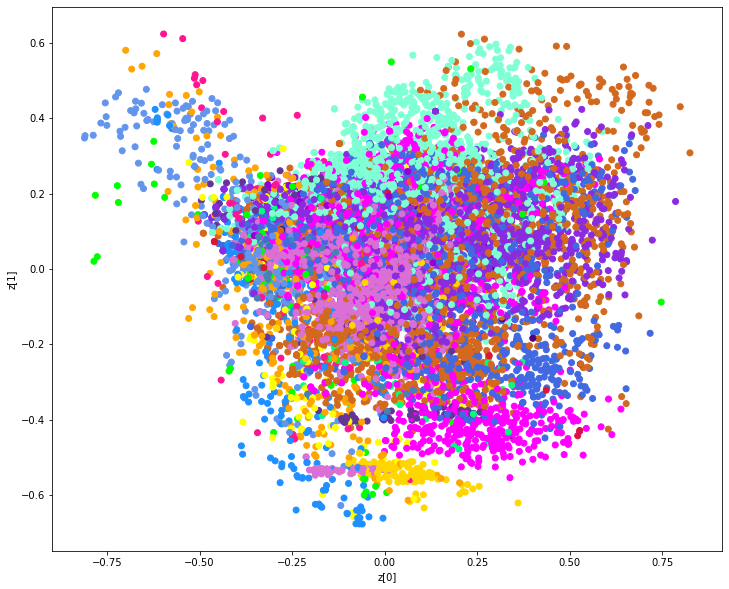

In [22]:
colour_dict = {
    ## Bandai ## 
    "b_neutral": "royalblue", # Normal bandai 1/2
    
    "b_tired": "fuchsia", # Tired bandai 1
    "b_tired_2": "magenta", # Exhausted bandai 2
    "b_exhausted": "orchid", # Old bandai 1 & Elderly bandai 2
    
    "b_angry": "crimson", # Angry bandai 1
    
    "b_happy": "springgreen", # Happy bandai 1
    "b_happy_2": "aquamarine", # Youthful bandai 2
    
    "b_sad": "steelblue", # Sad bandai 1
    
    "b_proud": "rebeccapurple", # Proud bandai 1
    "b_confident": "darkviolet", # Giant bandai 1 
    "b_confident_2": "indigo", # Masculine / Masculinity bandai 1
    "b_confident_3": "blueviolet", # Masculine bandai 2
    
    "b_afraid": "gold", # Not confident bandai 1
    
    "b_active": "chocolate", # Active bandai 1/2
    
    ## Kin ##
    "k_angry": "deeppink", 
    "k_happy": "lime", 
    "k_sad": "dodgerblue", 
    "k_disgusted": "orange" , 
    "k_afraid": "yellow", 
    "k_neutral": "cornflowerblue" 
}


conv_dict = {
    ## Bandai ## 
    (0.05, -0.1, 0.0): "b_neutral", # Normal bandai 1/2
    
    (0.1, -0.7, -0.2): "b_tired", # Tired bandai 1
    (0.1, -0.75, -0.25): "b_tired_2", # Exhausted bandai 2
    (-0.1, -0.6, -0.15): "b_exhausted", # Old bandai 1 & Elderly bandai 2
    
    (-0.5, 0.8, 0.9): "b_angry", # Angry bandai 1
    
    (0.8, 0.5, 0.15): "b_happy", # Happy bandai 1
    (0.6, 0.4, 0.1): "b_happy_2", # Youthful bandai 2
    
    (-0.6, -0.4, -0.3): "b_sad", # Sad bandai 1
    
    (0.4, 0.2, 0.35): "b_proud", # Proud bandai 1
    (0.3, 0.3, 0.9): "b_confident", # Giant bandai 1 
    (0.25, 0.15, 0.4): "b_confident_2", # Masculine / Masculinity bandai 1
    (0.3, 0.4, 0.6): "b_confident_3", # Masculine bandai 2
    
    (-0.6, 0.7, -0.8): "b_afraid", # Not confident bandai 1
    
    (0.1, 0.6, 0.4): "b_active", # Active bandai 1/2

    ## Kin ##
    (-0.5, 0.7, 0.9): "k_angry", 
    (0.6, 0.5, 0.2): "k_happy", 
    (-0.6, -0.3, -0.3): "k_sad", 
    (-0.4, 0.25, -0.1): "k_disgusted" , 
    (-0.5, 0.7, -0.8): "k_afraid", 
    (0.0, 0.0, 0.0): "k_neutral" 
}


def plot_label_clusters(autoencoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    encoded = autoencoder.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    
    actual_labels = []
    for i in range(len(labels)):
        point_coords = (labels.iloc[i][0], labels.iloc[i][1], labels.iloc[i][2])

        actual_labels.append(colour_dict[conv_dict[point_coords]])

    
    plt.scatter(encoded[:, 0], encoded[:, 1], c=actual_labels)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(autoencoder, test_dataset, test_emotions_OG)


In [44]:
index = 1

sample = np.asarray(test_dataset.iloc[index])
sample = sample.reshape(1,-1)
print(sample)

actual_coords = np.asarray(test_emotions_OG.iloc[index])

[[ 0.40071917  0.24227994  0.32441067  0.35345223  0.3564445   0.09557746
   0.25960428  0.19102636  0.236151    0.22389398  0.24936939  0.07098947
   0.03547762  0.00626559  0.1449599  -0.00285526 -0.00396879 -0.00280969
  -0.00238001 -0.00467089  0.00150227  0.0010022   0.00159099  0.00153455
   0.00183968]]


In [45]:
generated = autoencoder.encoder.predict(sample)
print(generated)

[[0.38125688 0.26423395 0.3196831  0.10975774 0.35942975]]


In [46]:
regen = autoencoder.decoder.predict(generated)
print(regen)

[[ 0.39578414  0.279956    0.28629237  0.35987416  0.33248228  0.1618284
   0.24212398  0.21617189  0.23615733  0.22385053  0.20480873  0.04837769
   0.0566712   0.02462953  0.14542833 -0.0155059  -0.00501572 -0.01080744
  -0.01316764 -0.01050919  0.0055123   0.00720365  0.00845584  0.00700075
   0.00456088]]


In [47]:
scaled_sample = scaler.transform(sample)

real_coordinates = (
    model_p.predict(scaled_sample),
    model_a.predict(scaled_sample),
    model_d.predict(scaled_sample)
)

scaled_regen = scaler.transform(regen)

generated_coordinates = (
    model_p.predict(scaled_regen),
    model_a.predict(scaled_regen),
    model_d.predict(scaled_regen)
)


print('Real: %s' % np.asarray(actual_coords))
print('Predicted: %s' % np.asarray(real_coordinates).transpose()[0])
print('Generated: %s' % np.asarray(generated_coordinates).transpose()[0])

Real: [-0.4   0.25 -0.1 ]
Predicted: [-0.4082086   0.2536626  -0.09918123]
Generated: [-0.2807018  0.4369788 -0.1800123]


/home/diogosilva/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/home/diogosilva/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


## Save Model

In [48]:
autoencoder.save("models/bandai_kin/5frame/ae/autoencoder_5")

INFO:tensorflow:Assets written to: models/bandai_kin/5frame/ae/autoencoder_5/assets



# PAD - Latent Space 

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [50]:
generated_train = autoencoder.encoder.predict(train_dataset)
generated_test = autoencoder.encoder.predict(test_dataset)

generated_train_x = train_emotions.copy()
generated_test_x = test_emotions.copy()
#generated_train_x = train_emotions_OG.copy()
#generated_test_x = test_emotions_OG.copy()

In [51]:
# Remove LMA features whose predictions are too different from the real one
generated_decoded_train = autoencoder.decoder.predict(generated_train)

index_for_removal = []
scaled_sample = scaler.transform(sample)


for ind in range(0,generated_decoded_train.shape[0]):
    print(str(ind) + " / " + str(generated_decoded_train.shape[0]))
    
    predicted = np.asarray([generated_decoded_train[ind]])
    true = np.asarray([train_emotions.iloc[ind]])

    predicted = scaler.transform(predicted)

    predicted = (
        model_p.predict(predicted),
        model_a.predict(predicted),
        model_d.predict(predicted)
    )
    
    predicted = np.asarray(predicted).transpose()
    
    #print(predicted)
    #print(true)
    
    mae_errors = mean_absolute_error(true, predicted, multioutput='raw_values')
    #print(mae_errors)
    
    if(mae_errors[0] > 0.25 or mae_errors[1] > 0.25 or mae_errors[2] > 0.25):
        index_for_removal.append(ind)
        continue
    
    mae_error = mean_absolute_error(true, predicted)
    #print(mae_error)
    
    if(mae_error > 0.15):
        index_for_removal.append(ind)
        continue
    
    #print()

print(len(index_for_removal))


0 / 119904
1 / 119904
2 / 119904
3 / 119904
4 / 119904
5 / 119904
6 / 119904
7 / 119904
8 / 119904
9 / 119904
10 / 119904
11 / 119904
12 / 119904
13 / 119904
14 / 119904
15 / 119904
16 / 119904
17 / 119904
18 / 119904
19 / 119904
20 / 119904
21 / 119904
22 / 119904
23 / 119904
24 / 119904
25 / 119904
26 / 119904
27 / 119904
28 / 119904
29 / 119904
30 / 119904
31 / 119904
32 / 119904
33 / 119904
34 / 119904
35 / 119904
36 / 119904
37 / 119904
38 / 119904
39 / 119904
40 / 119904
41 / 119904
42 / 119904
43 / 119904
44 / 119904
45 / 119904
46 / 119904
47 / 119904
48 / 119904
49 / 119904
50 / 119904
51 / 119904
52 / 119904
53 / 119904
54 / 119904
55 / 119904
56 / 119904
57 / 119904
58 / 119904
59 / 119904
60 / 119904
61 / 119904
62 / 119904
63 / 119904
64 / 119904
65 / 119904
66 / 119904
67 / 119904
68 / 119904
69 / 119904
70 / 119904
71 / 119904
72 / 119904
73 / 119904
74 / 119904
75 / 119904
76 / 119904
77 / 119904
78 / 119904
79 / 119904
80 / 119904
81 / 119904
82 / 119904
83 / 119904
84

645 / 119904
646 / 119904
647 / 119904
648 / 119904
649 / 119904
650 / 119904
651 / 119904
652 / 119904
653 / 119904
654 / 119904
655 / 119904
656 / 119904
657 / 119904
658 / 119904
659 / 119904
660 / 119904
661 / 119904
662 / 119904
663 / 119904
664 / 119904
665 / 119904
666 / 119904
667 / 119904
668 / 119904
669 / 119904
670 / 119904
671 / 119904
672 / 119904
673 / 119904
674 / 119904
675 / 119904
676 / 119904
677 / 119904
678 / 119904
679 / 119904
680 / 119904
681 / 119904
682 / 119904
683 / 119904
684 / 119904
685 / 119904
686 / 119904
687 / 119904
688 / 119904
689 / 119904
690 / 119904
691 / 119904
692 / 119904
693 / 119904
694 / 119904
695 / 119904
696 / 119904
697 / 119904
698 / 119904
699 / 119904
700 / 119904
701 / 119904
702 / 119904
703 / 119904
704 / 119904
705 / 119904
706 / 119904
707 / 119904
708 / 119904
709 / 119904
710 / 119904
711 / 119904
712 / 119904
713 / 119904
714 / 119904
715 / 119904
716 / 119904
717 / 119904
718 / 119904
719 / 119904
720 / 119904
721 / 119904

1257 / 119904
1258 / 119904
1259 / 119904
1260 / 119904
1261 / 119904
1262 / 119904
1263 / 119904
1264 / 119904
1265 / 119904
1266 / 119904
1267 / 119904
1268 / 119904
1269 / 119904
1270 / 119904
1271 / 119904
1272 / 119904
1273 / 119904
1274 / 119904
1275 / 119904
1276 / 119904
1277 / 119904
1278 / 119904
1279 / 119904
1280 / 119904
1281 / 119904
1282 / 119904
1283 / 119904
1284 / 119904
1285 / 119904
1286 / 119904
1287 / 119904
1288 / 119904
1289 / 119904
1290 / 119904
1291 / 119904
1292 / 119904
1293 / 119904
1294 / 119904
1295 / 119904
1296 / 119904
1297 / 119904
1298 / 119904
1299 / 119904
1300 / 119904
1301 / 119904
1302 / 119904
1303 / 119904
1304 / 119904
1305 / 119904
1306 / 119904
1307 / 119904
1308 / 119904
1309 / 119904
1310 / 119904
1311 / 119904
1312 / 119904
1313 / 119904
1314 / 119904
1315 / 119904
1316 / 119904
1317 / 119904
1318 / 119904
1319 / 119904
1320 / 119904
1321 / 119904
1322 / 119904
1323 / 119904
1324 / 119904
1325 / 119904
1326 / 119904
1327 / 119904
1328 /

1851 / 119904
1852 / 119904
1853 / 119904
1854 / 119904
1855 / 119904
1856 / 119904
1857 / 119904
1858 / 119904
1859 / 119904
1860 / 119904
1861 / 119904
1862 / 119904
1863 / 119904
1864 / 119904
1865 / 119904
1866 / 119904
1867 / 119904
1868 / 119904
1869 / 119904
1870 / 119904
1871 / 119904
1872 / 119904
1873 / 119904
1874 / 119904
1875 / 119904
1876 / 119904
1877 / 119904
1878 / 119904
1879 / 119904
1880 / 119904
1881 / 119904
1882 / 119904
1883 / 119904
1884 / 119904
1885 / 119904
1886 / 119904
1887 / 119904
1888 / 119904
1889 / 119904
1890 / 119904
1891 / 119904
1892 / 119904
1893 / 119904
1894 / 119904
1895 / 119904
1896 / 119904
1897 / 119904
1898 / 119904
1899 / 119904
1900 / 119904
1901 / 119904
1902 / 119904
1903 / 119904
1904 / 119904
1905 / 119904
1906 / 119904
1907 / 119904
1908 / 119904
1909 / 119904
1910 / 119904
1911 / 119904
1912 / 119904
1913 / 119904
1914 / 119904
1915 / 119904
1916 / 119904
1917 / 119904
1918 / 119904
1919 / 119904
1920 / 119904
1921 / 119904
1922 /

2444 / 119904
2445 / 119904
2446 / 119904
2447 / 119904
2448 / 119904
2449 / 119904
2450 / 119904
2451 / 119904
2452 / 119904
2453 / 119904
2454 / 119904
2455 / 119904
2456 / 119904
2457 / 119904
2458 / 119904
2459 / 119904
2460 / 119904
2461 / 119904
2462 / 119904
2463 / 119904
2464 / 119904
2465 / 119904
2466 / 119904
2467 / 119904
2468 / 119904
2469 / 119904
2470 / 119904
2471 / 119904
2472 / 119904
2473 / 119904
2474 / 119904
2475 / 119904
2476 / 119904
2477 / 119904
2478 / 119904
2479 / 119904
2480 / 119904
2481 / 119904
2482 / 119904
2483 / 119904
2484 / 119904
2485 / 119904
2486 / 119904
2487 / 119904
2488 / 119904
2489 / 119904
2490 / 119904
2491 / 119904
2492 / 119904
2493 / 119904
2494 / 119904
2495 / 119904
2496 / 119904
2497 / 119904
2498 / 119904
2499 / 119904
2500 / 119904
2501 / 119904
2502 / 119904
2503 / 119904
2504 / 119904
2505 / 119904
2506 / 119904
2507 / 119904
2508 / 119904
2509 / 119904
2510 / 119904
2511 / 119904
2512 / 119904
2513 / 119904
2514 / 119904
2515 /

3037 / 119904
3038 / 119904
3039 / 119904
3040 / 119904
3041 / 119904
3042 / 119904
3043 / 119904
3044 / 119904
3045 / 119904
3046 / 119904
3047 / 119904
3048 / 119904
3049 / 119904
3050 / 119904
3051 / 119904
3052 / 119904
3053 / 119904
3054 / 119904
3055 / 119904
3056 / 119904
3057 / 119904
3058 / 119904
3059 / 119904
3060 / 119904
3061 / 119904
3062 / 119904
3063 / 119904
3064 / 119904
3065 / 119904
3066 / 119904
3067 / 119904
3068 / 119904
3069 / 119904
3070 / 119904
3071 / 119904
3072 / 119904
3073 / 119904
3074 / 119904
3075 / 119904
3076 / 119904
3077 / 119904
3078 / 119904
3079 / 119904
3080 / 119904
3081 / 119904
3082 / 119904
3083 / 119904
3084 / 119904
3085 / 119904
3086 / 119904
3087 / 119904
3088 / 119904
3089 / 119904
3090 / 119904
3091 / 119904
3092 / 119904
3093 / 119904
3094 / 119904
3095 / 119904
3096 / 119904
3097 / 119904
3098 / 119904
3099 / 119904
3100 / 119904
3101 / 119904
3102 / 119904
3103 / 119904
3104 / 119904
3105 / 119904
3106 / 119904
3107 / 119904
3108 /

3632 / 119904
3633 / 119904
3634 / 119904
3635 / 119904
3636 / 119904
3637 / 119904
3638 / 119904
3639 / 119904
3640 / 119904
3641 / 119904
3642 / 119904
3643 / 119904
3644 / 119904
3645 / 119904
3646 / 119904
3647 / 119904
3648 / 119904
3649 / 119904
3650 / 119904
3651 / 119904
3652 / 119904
3653 / 119904
3654 / 119904
3655 / 119904
3656 / 119904
3657 / 119904
3658 / 119904
3659 / 119904
3660 / 119904
3661 / 119904
3662 / 119904
3663 / 119904
3664 / 119904
3665 / 119904
3666 / 119904
3667 / 119904
3668 / 119904
3669 / 119904
3670 / 119904
3671 / 119904
3672 / 119904
3673 / 119904
3674 / 119904
3675 / 119904
3676 / 119904
3677 / 119904
3678 / 119904
3679 / 119904
3680 / 119904
3681 / 119904
3682 / 119904
3683 / 119904
3684 / 119904
3685 / 119904
3686 / 119904
3687 / 119904
3688 / 119904
3689 / 119904
3690 / 119904
3691 / 119904
3692 / 119904
3693 / 119904
3694 / 119904
3695 / 119904
3696 / 119904
3697 / 119904
3698 / 119904
3699 / 119904
3700 / 119904
3701 / 119904
3702 / 119904
3703 /

4227 / 119904
4228 / 119904
4229 / 119904
4230 / 119904
4231 / 119904
4232 / 119904
4233 / 119904
4234 / 119904
4235 / 119904
4236 / 119904
4237 / 119904
4238 / 119904
4239 / 119904
4240 / 119904
4241 / 119904
4242 / 119904
4243 / 119904
4244 / 119904
4245 / 119904
4246 / 119904
4247 / 119904
4248 / 119904
4249 / 119904
4250 / 119904
4251 / 119904
4252 / 119904
4253 / 119904
4254 / 119904
4255 / 119904
4256 / 119904
4257 / 119904
4258 / 119904
4259 / 119904
4260 / 119904
4261 / 119904
4262 / 119904
4263 / 119904
4264 / 119904
4265 / 119904
4266 / 119904
4267 / 119904
4268 / 119904
4269 / 119904
4270 / 119904
4271 / 119904
4272 / 119904
4273 / 119904
4274 / 119904
4275 / 119904
4276 / 119904
4277 / 119904
4278 / 119904
4279 / 119904
4280 / 119904
4281 / 119904
4282 / 119904
4283 / 119904
4284 / 119904
4285 / 119904
4286 / 119904
4287 / 119904
4288 / 119904
4289 / 119904
4290 / 119904
4291 / 119904
4292 / 119904
4293 / 119904
4294 / 119904
4295 / 119904
4296 / 119904
4297 / 119904
4298 /

4822 / 119904
4823 / 119904
4824 / 119904
4825 / 119904
4826 / 119904
4827 / 119904
4828 / 119904
4829 / 119904
4830 / 119904
4831 / 119904
4832 / 119904
4833 / 119904
4834 / 119904
4835 / 119904
4836 / 119904
4837 / 119904
4838 / 119904
4839 / 119904
4840 / 119904
4841 / 119904
4842 / 119904
4843 / 119904
4844 / 119904
4845 / 119904
4846 / 119904
4847 / 119904
4848 / 119904
4849 / 119904
4850 / 119904
4851 / 119904
4852 / 119904
4853 / 119904
4854 / 119904
4855 / 119904
4856 / 119904
4857 / 119904
4858 / 119904
4859 / 119904
4860 / 119904
4861 / 119904
4862 / 119904
4863 / 119904
4864 / 119904
4865 / 119904
4866 / 119904
4867 / 119904
4868 / 119904
4869 / 119904
4870 / 119904
4871 / 119904
4872 / 119904
4873 / 119904
4874 / 119904
4875 / 119904
4876 / 119904
4877 / 119904
4878 / 119904
4879 / 119904
4880 / 119904
4881 / 119904
4882 / 119904
4883 / 119904
4884 / 119904
4885 / 119904
4886 / 119904
4887 / 119904
4888 / 119904
4889 / 119904
4890 / 119904
4891 / 119904
4892 / 119904
4893 /

5416 / 119904
5417 / 119904
5418 / 119904
5419 / 119904
5420 / 119904
5421 / 119904
5422 / 119904
5423 / 119904
5424 / 119904
5425 / 119904
5426 / 119904
5427 / 119904
5428 / 119904
5429 / 119904
5430 / 119904
5431 / 119904
5432 / 119904
5433 / 119904
5434 / 119904
5435 / 119904
5436 / 119904
5437 / 119904
5438 / 119904
5439 / 119904
5440 / 119904
5441 / 119904
5442 / 119904
5443 / 119904
5444 / 119904
5445 / 119904
5446 / 119904
5447 / 119904
5448 / 119904
5449 / 119904
5450 / 119904
5451 / 119904
5452 / 119904
5453 / 119904
5454 / 119904
5455 / 119904
5456 / 119904
5457 / 119904
5458 / 119904
5459 / 119904
5460 / 119904
5461 / 119904
5462 / 119904
5463 / 119904
5464 / 119904
5465 / 119904
5466 / 119904
5467 / 119904
5468 / 119904
5469 / 119904
5470 / 119904
5471 / 119904
5472 / 119904
5473 / 119904
5474 / 119904
5475 / 119904
5476 / 119904
5477 / 119904
5478 / 119904
5479 / 119904
5480 / 119904
5481 / 119904
5482 / 119904
5483 / 119904
5484 / 119904
5485 / 119904
5486 / 119904
5487 /

6011 / 119904
6012 / 119904
6013 / 119904
6014 / 119904
6015 / 119904
6016 / 119904
6017 / 119904
6018 / 119904
6019 / 119904
6020 / 119904
6021 / 119904
6022 / 119904
6023 / 119904
6024 / 119904
6025 / 119904
6026 / 119904
6027 / 119904
6028 / 119904
6029 / 119904
6030 / 119904
6031 / 119904
6032 / 119904
6033 / 119904
6034 / 119904
6035 / 119904
6036 / 119904
6037 / 119904
6038 / 119904
6039 / 119904
6040 / 119904
6041 / 119904
6042 / 119904
6043 / 119904
6044 / 119904
6045 / 119904
6046 / 119904
6047 / 119904
6048 / 119904
6049 / 119904
6050 / 119904
6051 / 119904
6052 / 119904
6053 / 119904
6054 / 119904
6055 / 119904
6056 / 119904
6057 / 119904
6058 / 119904
6059 / 119904
6060 / 119904
6061 / 119904
6062 / 119904
6063 / 119904
6064 / 119904
6065 / 119904
6066 / 119904
6067 / 119904
6068 / 119904
6069 / 119904
6070 / 119904
6071 / 119904
6072 / 119904
6073 / 119904
6074 / 119904
6075 / 119904
6076 / 119904
6077 / 119904
6078 / 119904
6079 / 119904
6080 / 119904
6081 / 119904
6082 /

6604 / 119904
6605 / 119904
6606 / 119904
6607 / 119904
6608 / 119904
6609 / 119904
6610 / 119904
6611 / 119904
6612 / 119904
6613 / 119904
6614 / 119904
6615 / 119904
6616 / 119904
6617 / 119904
6618 / 119904
6619 / 119904
6620 / 119904
6621 / 119904
6622 / 119904
6623 / 119904
6624 / 119904
6625 / 119904
6626 / 119904
6627 / 119904
6628 / 119904
6629 / 119904
6630 / 119904
6631 / 119904
6632 / 119904
6633 / 119904
6634 / 119904
6635 / 119904
6636 / 119904
6637 / 119904
6638 / 119904
6639 / 119904
6640 / 119904
6641 / 119904
6642 / 119904
6643 / 119904
6644 / 119904
6645 / 119904
6646 / 119904
6647 / 119904
6648 / 119904
6649 / 119904
6650 / 119904
6651 / 119904
6652 / 119904
6653 / 119904
6654 / 119904
6655 / 119904
6656 / 119904
6657 / 119904
6658 / 119904
6659 / 119904
6660 / 119904
6661 / 119904
6662 / 119904
6663 / 119904
6664 / 119904
6665 / 119904
6666 / 119904
6667 / 119904
6668 / 119904
6669 / 119904
6670 / 119904
6671 / 119904
6672 / 119904
6673 / 119904
6674 / 119904
6675 /

7205 / 119904
7206 / 119904
7207 / 119904
7208 / 119904
7209 / 119904
7210 / 119904
7211 / 119904
7212 / 119904
7213 / 119904
7214 / 119904
7215 / 119904
7216 / 119904
7217 / 119904
7218 / 119904
7219 / 119904
7220 / 119904
7221 / 119904
7222 / 119904
7223 / 119904
7224 / 119904
7225 / 119904
7226 / 119904
7227 / 119904
7228 / 119904
7229 / 119904
7230 / 119904
7231 / 119904
7232 / 119904
7233 / 119904
7234 / 119904
7235 / 119904
7236 / 119904
7237 / 119904
7238 / 119904
7239 / 119904
7240 / 119904
7241 / 119904
7242 / 119904
7243 / 119904
7244 / 119904
7245 / 119904
7246 / 119904
7247 / 119904
7248 / 119904
7249 / 119904
7250 / 119904
7251 / 119904
7252 / 119904
7253 / 119904
7254 / 119904
7255 / 119904
7256 / 119904
7257 / 119904
7258 / 119904
7259 / 119904
7260 / 119904
7261 / 119904
7262 / 119904
7263 / 119904
7264 / 119904
7265 / 119904
7266 / 119904
7267 / 119904
7268 / 119904
7269 / 119904
7270 / 119904
7271 / 119904
7272 / 119904
7273 / 119904
7274 / 119904
7275 / 119904
7276 /

7799 / 119904
7800 / 119904
7801 / 119904
7802 / 119904
7803 / 119904
7804 / 119904
7805 / 119904
7806 / 119904
7807 / 119904
7808 / 119904
7809 / 119904
7810 / 119904
7811 / 119904
7812 / 119904
7813 / 119904
7814 / 119904
7815 / 119904
7816 / 119904
7817 / 119904
7818 / 119904
7819 / 119904
7820 / 119904
7821 / 119904
7822 / 119904
7823 / 119904
7824 / 119904
7825 / 119904
7826 / 119904
7827 / 119904
7828 / 119904
7829 / 119904
7830 / 119904
7831 / 119904
7832 / 119904
7833 / 119904
7834 / 119904
7835 / 119904
7836 / 119904
7837 / 119904
7838 / 119904
7839 / 119904
7840 / 119904
7841 / 119904
7842 / 119904
7843 / 119904
7844 / 119904
7845 / 119904
7846 / 119904
7847 / 119904
7848 / 119904
7849 / 119904
7850 / 119904
7851 / 119904
7852 / 119904
7853 / 119904
7854 / 119904
7855 / 119904
7856 / 119904
7857 / 119904
7858 / 119904
7859 / 119904
7860 / 119904
7861 / 119904
7862 / 119904
7863 / 119904
7864 / 119904
7865 / 119904
7866 / 119904
7867 / 119904
7868 / 119904
7869 / 119904
7870 /

8394 / 119904
8395 / 119904
8396 / 119904
8397 / 119904
8398 / 119904
8399 / 119904
8400 / 119904
8401 / 119904
8402 / 119904
8403 / 119904
8404 / 119904
8405 / 119904
8406 / 119904
8407 / 119904
8408 / 119904
8409 / 119904
8410 / 119904
8411 / 119904
8412 / 119904
8413 / 119904
8414 / 119904
8415 / 119904
8416 / 119904
8417 / 119904
8418 / 119904
8419 / 119904
8420 / 119904
8421 / 119904
8422 / 119904
8423 / 119904
8424 / 119904
8425 / 119904
8426 / 119904
8427 / 119904
8428 / 119904
8429 / 119904
8430 / 119904
8431 / 119904
8432 / 119904
8433 / 119904
8434 / 119904
8435 / 119904
8436 / 119904
8437 / 119904
8438 / 119904
8439 / 119904
8440 / 119904
8441 / 119904
8442 / 119904
8443 / 119904
8444 / 119904
8445 / 119904
8446 / 119904
8447 / 119904
8448 / 119904
8449 / 119904
8450 / 119904
8451 / 119904
8452 / 119904
8453 / 119904
8454 / 119904
8455 / 119904
8456 / 119904
8457 / 119904
8458 / 119904
8459 / 119904
8460 / 119904
8461 / 119904
8462 / 119904
8463 / 119904
8464 / 119904
8465 /

8986 / 119904
8987 / 119904
8988 / 119904
8989 / 119904
8990 / 119904
8991 / 119904
8992 / 119904
8993 / 119904
8994 / 119904
8995 / 119904
8996 / 119904
8997 / 119904
8998 / 119904
8999 / 119904
9000 / 119904
9001 / 119904
9002 / 119904
9003 / 119904
9004 / 119904
9005 / 119904
9006 / 119904
9007 / 119904
9008 / 119904
9009 / 119904
9010 / 119904
9011 / 119904
9012 / 119904
9013 / 119904
9014 / 119904
9015 / 119904
9016 / 119904
9017 / 119904
9018 / 119904
9019 / 119904
9020 / 119904
9021 / 119904
9022 / 119904
9023 / 119904
9024 / 119904
9025 / 119904
9026 / 119904
9027 / 119904
9028 / 119904
9029 / 119904
9030 / 119904
9031 / 119904
9032 / 119904
9033 / 119904
9034 / 119904
9035 / 119904
9036 / 119904
9037 / 119904
9038 / 119904
9039 / 119904
9040 / 119904
9041 / 119904
9042 / 119904
9043 / 119904
9044 / 119904
9045 / 119904
9046 / 119904
9047 / 119904
9048 / 119904
9049 / 119904
9050 / 119904
9051 / 119904
9052 / 119904
9053 / 119904
9054 / 119904
9055 / 119904
9056 / 119904
9057 /

9575 / 119904
9576 / 119904
9577 / 119904
9578 / 119904
9579 / 119904
9580 / 119904
9581 / 119904
9582 / 119904
9583 / 119904
9584 / 119904
9585 / 119904
9586 / 119904
9587 / 119904
9588 / 119904
9589 / 119904
9590 / 119904
9591 / 119904
9592 / 119904
9593 / 119904
9594 / 119904
9595 / 119904
9596 / 119904
9597 / 119904
9598 / 119904
9599 / 119904
9600 / 119904
9601 / 119904
9602 / 119904
9603 / 119904
9604 / 119904
9605 / 119904
9606 / 119904
9607 / 119904
9608 / 119904
9609 / 119904
9610 / 119904
9611 / 119904
9612 / 119904
9613 / 119904
9614 / 119904
9615 / 119904
9616 / 119904
9617 / 119904
9618 / 119904
9619 / 119904
9620 / 119904
9621 / 119904
9622 / 119904
9623 / 119904
9624 / 119904
9625 / 119904
9626 / 119904
9627 / 119904
9628 / 119904
9629 / 119904
9630 / 119904
9631 / 119904
9632 / 119904
9633 / 119904
9634 / 119904
9635 / 119904
9636 / 119904
9637 / 119904
9638 / 119904
9639 / 119904
9640 / 119904
9641 / 119904
9642 / 119904
9643 / 119904
9644 / 119904
9645 / 119904
9646 /

10152 / 119904
10153 / 119904
10154 / 119904
10155 / 119904
10156 / 119904
10157 / 119904
10158 / 119904
10159 / 119904
10160 / 119904
10161 / 119904
10162 / 119904
10163 / 119904
10164 / 119904
10165 / 119904
10166 / 119904
10167 / 119904
10168 / 119904
10169 / 119904
10170 / 119904
10171 / 119904
10172 / 119904
10173 / 119904
10174 / 119904
10175 / 119904
10176 / 119904
10177 / 119904
10178 / 119904
10179 / 119904
10180 / 119904
10181 / 119904
10182 / 119904
10183 / 119904
10184 / 119904
10185 / 119904
10186 / 119904
10187 / 119904
10188 / 119904
10189 / 119904
10190 / 119904
10191 / 119904
10192 / 119904
10193 / 119904
10194 / 119904
10195 / 119904
10196 / 119904
10197 / 119904
10198 / 119904
10199 / 119904
10200 / 119904
10201 / 119904
10202 / 119904
10203 / 119904
10204 / 119904
10205 / 119904
10206 / 119904
10207 / 119904
10208 / 119904
10209 / 119904
10210 / 119904
10211 / 119904
10212 / 119904
10213 / 119904
10214 / 119904
10215 / 119904
10216 / 119904
10217 / 119904
10218 / 11

10713 / 119904
10714 / 119904
10715 / 119904
10716 / 119904
10717 / 119904
10718 / 119904
10719 / 119904
10720 / 119904
10721 / 119904
10722 / 119904
10723 / 119904
10724 / 119904
10725 / 119904
10726 / 119904
10727 / 119904
10728 / 119904
10729 / 119904
10730 / 119904
10731 / 119904
10732 / 119904
10733 / 119904
10734 / 119904
10735 / 119904
10736 / 119904
10737 / 119904
10738 / 119904
10739 / 119904
10740 / 119904
10741 / 119904
10742 / 119904
10743 / 119904
10744 / 119904
10745 / 119904
10746 / 119904
10747 / 119904
10748 / 119904
10749 / 119904
10750 / 119904
10751 / 119904
10752 / 119904
10753 / 119904
10754 / 119904
10755 / 119904
10756 / 119904
10757 / 119904
10758 / 119904
10759 / 119904
10760 / 119904
10761 / 119904
10762 / 119904
10763 / 119904
10764 / 119904
10765 / 119904
10766 / 119904
10767 / 119904
10768 / 119904
10769 / 119904
10770 / 119904
10771 / 119904
10772 / 119904
10773 / 119904
10774 / 119904
10775 / 119904
10776 / 119904
10777 / 119904
10778 / 119904
10779 / 11

11274 / 119904
11275 / 119904
11276 / 119904
11277 / 119904
11278 / 119904
11279 / 119904
11280 / 119904
11281 / 119904
11282 / 119904
11283 / 119904
11284 / 119904
11285 / 119904
11286 / 119904
11287 / 119904
11288 / 119904
11289 / 119904
11290 / 119904
11291 / 119904
11292 / 119904
11293 / 119904
11294 / 119904
11295 / 119904
11296 / 119904
11297 / 119904
11298 / 119904
11299 / 119904
11300 / 119904
11301 / 119904
11302 / 119904
11303 / 119904
11304 / 119904
11305 / 119904
11306 / 119904
11307 / 119904
11308 / 119904
11309 / 119904
11310 / 119904
11311 / 119904
11312 / 119904
11313 / 119904
11314 / 119904
11315 / 119904
11316 / 119904
11317 / 119904
11318 / 119904
11319 / 119904
11320 / 119904
11321 / 119904
11322 / 119904
11323 / 119904
11324 / 119904
11325 / 119904
11326 / 119904
11327 / 119904
11328 / 119904
11329 / 119904
11330 / 119904
11331 / 119904
11332 / 119904
11333 / 119904
11334 / 119904
11335 / 119904
11336 / 119904
11337 / 119904
11338 / 119904
11339 / 119904
11340 / 11

11835 / 119904
11836 / 119904
11837 / 119904
11838 / 119904
11839 / 119904
11840 / 119904
11841 / 119904
11842 / 119904
11843 / 119904
11844 / 119904
11845 / 119904
11846 / 119904
11847 / 119904
11848 / 119904
11849 / 119904
11850 / 119904
11851 / 119904
11852 / 119904
11853 / 119904
11854 / 119904
11855 / 119904
11856 / 119904
11857 / 119904
11858 / 119904
11859 / 119904
11860 / 119904
11861 / 119904
11862 / 119904
11863 / 119904
11864 / 119904
11865 / 119904
11866 / 119904
11867 / 119904
11868 / 119904
11869 / 119904
11870 / 119904
11871 / 119904
11872 / 119904
11873 / 119904
11874 / 119904
11875 / 119904
11876 / 119904
11877 / 119904
11878 / 119904
11879 / 119904
11880 / 119904
11881 / 119904
11882 / 119904
11883 / 119904
11884 / 119904
11885 / 119904
11886 / 119904
11887 / 119904
11888 / 119904
11889 / 119904
11890 / 119904
11891 / 119904
11892 / 119904
11893 / 119904
11894 / 119904
11895 / 119904
11896 / 119904
11897 / 119904
11898 / 119904
11899 / 119904
11900 / 119904
11901 / 11

12384 / 119904
12385 / 119904
12386 / 119904
12387 / 119904
12388 / 119904
12389 / 119904
12390 / 119904
12391 / 119904
12392 / 119904
12393 / 119904
12394 / 119904
12395 / 119904
12396 / 119904
12397 / 119904
12398 / 119904
12399 / 119904
12400 / 119904
12401 / 119904
12402 / 119904
12403 / 119904
12404 / 119904
12405 / 119904
12406 / 119904
12407 / 119904
12408 / 119904
12409 / 119904
12410 / 119904
12411 / 119904
12412 / 119904
12413 / 119904
12414 / 119904
12415 / 119904
12416 / 119904
12417 / 119904
12418 / 119904
12419 / 119904
12420 / 119904
12421 / 119904
12422 / 119904
12423 / 119904
12424 / 119904
12425 / 119904
12426 / 119904
12427 / 119904
12428 / 119904
12429 / 119904
12430 / 119904
12431 / 119904
12432 / 119904
12433 / 119904
12434 / 119904
12435 / 119904
12436 / 119904
12437 / 119904
12438 / 119904
12439 / 119904
12440 / 119904
12441 / 119904
12442 / 119904
12443 / 119904
12444 / 119904
12445 / 119904
12446 / 119904
12447 / 119904
12448 / 119904
12449 / 119904
12450 / 11

12945 / 119904
12946 / 119904
12947 / 119904
12948 / 119904
12949 / 119904
12950 / 119904
12951 / 119904
12952 / 119904
12953 / 119904
12954 / 119904
12955 / 119904
12956 / 119904
12957 / 119904
12958 / 119904
12959 / 119904
12960 / 119904
12961 / 119904
12962 / 119904
12963 / 119904
12964 / 119904
12965 / 119904
12966 / 119904
12967 / 119904
12968 / 119904
12969 / 119904
12970 / 119904
12971 / 119904
12972 / 119904
12973 / 119904
12974 / 119904
12975 / 119904
12976 / 119904
12977 / 119904
12978 / 119904
12979 / 119904
12980 / 119904
12981 / 119904
12982 / 119904
12983 / 119904
12984 / 119904
12985 / 119904
12986 / 119904
12987 / 119904
12988 / 119904
12989 / 119904
12990 / 119904
12991 / 119904
12992 / 119904
12993 / 119904
12994 / 119904
12995 / 119904
12996 / 119904
12997 / 119904
12998 / 119904
12999 / 119904
13000 / 119904
13001 / 119904
13002 / 119904
13003 / 119904
13004 / 119904
13005 / 119904
13006 / 119904
13007 / 119904
13008 / 119904
13009 / 119904
13010 / 119904
13011 / 11

13506 / 119904
13507 / 119904
13508 / 119904
13509 / 119904
13510 / 119904
13511 / 119904
13512 / 119904
13513 / 119904
13514 / 119904
13515 / 119904
13516 / 119904
13517 / 119904
13518 / 119904
13519 / 119904
13520 / 119904
13521 / 119904
13522 / 119904
13523 / 119904
13524 / 119904
13525 / 119904
13526 / 119904
13527 / 119904
13528 / 119904
13529 / 119904
13530 / 119904
13531 / 119904
13532 / 119904
13533 / 119904
13534 / 119904
13535 / 119904
13536 / 119904
13537 / 119904
13538 / 119904
13539 / 119904
13540 / 119904
13541 / 119904
13542 / 119904
13543 / 119904
13544 / 119904
13545 / 119904
13546 / 119904
13547 / 119904
13548 / 119904
13549 / 119904
13550 / 119904
13551 / 119904
13552 / 119904
13553 / 119904
13554 / 119904
13555 / 119904
13556 / 119904
13557 / 119904
13558 / 119904
13559 / 119904
13560 / 119904
13561 / 119904
13562 / 119904
13563 / 119904
13564 / 119904
13565 / 119904
13566 / 119904
13567 / 119904
13568 / 119904
13569 / 119904
13570 / 119904
13571 / 119904
13572 / 11

14067 / 119904
14068 / 119904
14069 / 119904
14070 / 119904
14071 / 119904
14072 / 119904
14073 / 119904
14074 / 119904
14075 / 119904
14076 / 119904
14077 / 119904
14078 / 119904
14079 / 119904
14080 / 119904
14081 / 119904
14082 / 119904
14083 / 119904
14084 / 119904
14085 / 119904
14086 / 119904
14087 / 119904
14088 / 119904
14089 / 119904
14090 / 119904
14091 / 119904
14092 / 119904
14093 / 119904
14094 / 119904
14095 / 119904
14096 / 119904
14097 / 119904
14098 / 119904
14099 / 119904
14100 / 119904
14101 / 119904
14102 / 119904
14103 / 119904
14104 / 119904
14105 / 119904
14106 / 119904
14107 / 119904
14108 / 119904
14109 / 119904
14110 / 119904
14111 / 119904
14112 / 119904
14113 / 119904
14114 / 119904
14115 / 119904
14116 / 119904
14117 / 119904
14118 / 119904
14119 / 119904
14120 / 119904
14121 / 119904
14122 / 119904
14123 / 119904
14124 / 119904
14125 / 119904
14126 / 119904
14127 / 119904
14128 / 119904
14129 / 119904
14130 / 119904
14131 / 119904
14132 / 119904
14133 / 11

14628 / 119904
14629 / 119904
14630 / 119904
14631 / 119904
14632 / 119904
14633 / 119904
14634 / 119904
14635 / 119904
14636 / 119904
14637 / 119904
14638 / 119904
14639 / 119904
14640 / 119904
14641 / 119904
14642 / 119904
14643 / 119904
14644 / 119904
14645 / 119904
14646 / 119904
14647 / 119904
14648 / 119904
14649 / 119904
14650 / 119904
14651 / 119904
14652 / 119904
14653 / 119904
14654 / 119904
14655 / 119904
14656 / 119904
14657 / 119904
14658 / 119904
14659 / 119904
14660 / 119904
14661 / 119904
14662 / 119904
14663 / 119904
14664 / 119904
14665 / 119904
14666 / 119904
14667 / 119904
14668 / 119904
14669 / 119904
14670 / 119904
14671 / 119904
14672 / 119904
14673 / 119904
14674 / 119904
14675 / 119904
14676 / 119904
14677 / 119904
14678 / 119904
14679 / 119904
14680 / 119904
14681 / 119904
14682 / 119904
14683 / 119904
14684 / 119904
14685 / 119904
14686 / 119904
14687 / 119904
14688 / 119904
14689 / 119904
14690 / 119904
14691 / 119904
14692 / 119904
14693 / 119904
14694 / 11

15181 / 119904
15182 / 119904
15183 / 119904
15184 / 119904
15185 / 119904
15186 / 119904
15187 / 119904
15188 / 119904
15189 / 119904
15190 / 119904
15191 / 119904
15192 / 119904
15193 / 119904
15194 / 119904
15195 / 119904
15196 / 119904
15197 / 119904
15198 / 119904
15199 / 119904
15200 / 119904
15201 / 119904
15202 / 119904
15203 / 119904
15204 / 119904
15205 / 119904
15206 / 119904
15207 / 119904
15208 / 119904
15209 / 119904
15210 / 119904
15211 / 119904
15212 / 119904
15213 / 119904
15214 / 119904
15215 / 119904
15216 / 119904
15217 / 119904
15218 / 119904
15219 / 119904
15220 / 119904
15221 / 119904
15222 / 119904
15223 / 119904
15224 / 119904
15225 / 119904
15226 / 119904
15227 / 119904
15228 / 119904
15229 / 119904
15230 / 119904
15231 / 119904
15232 / 119904
15233 / 119904
15234 / 119904
15235 / 119904
15236 / 119904
15237 / 119904
15238 / 119904
15239 / 119904
15240 / 119904
15241 / 119904
15242 / 119904
15243 / 119904
15244 / 119904
15245 / 119904
15246 / 119904
15247 / 11

15739 / 119904
15740 / 119904
15741 / 119904
15742 / 119904
15743 / 119904
15744 / 119904
15745 / 119904
15746 / 119904
15747 / 119904
15748 / 119904
15749 / 119904
15750 / 119904
15751 / 119904
15752 / 119904
15753 / 119904
15754 / 119904
15755 / 119904
15756 / 119904
15757 / 119904
15758 / 119904
15759 / 119904
15760 / 119904
15761 / 119904
15762 / 119904
15763 / 119904
15764 / 119904
15765 / 119904
15766 / 119904
15767 / 119904
15768 / 119904
15769 / 119904
15770 / 119904
15771 / 119904
15772 / 119904
15773 / 119904
15774 / 119904
15775 / 119904
15776 / 119904
15777 / 119904
15778 / 119904
15779 / 119904
15780 / 119904
15781 / 119904
15782 / 119904
15783 / 119904
15784 / 119904
15785 / 119904
15786 / 119904
15787 / 119904
15788 / 119904
15789 / 119904
15790 / 119904
15791 / 119904
15792 / 119904
15793 / 119904
15794 / 119904
15795 / 119904
15796 / 119904
15797 / 119904
15798 / 119904
15799 / 119904
15800 / 119904
15801 / 119904
15802 / 119904
15803 / 119904
15804 / 119904
15805 / 11

16286 / 119904
16287 / 119904
16288 / 119904
16289 / 119904
16290 / 119904
16291 / 119904
16292 / 119904
16293 / 119904
16294 / 119904
16295 / 119904
16296 / 119904
16297 / 119904
16298 / 119904
16299 / 119904
16300 / 119904
16301 / 119904
16302 / 119904
16303 / 119904
16304 / 119904
16305 / 119904
16306 / 119904
16307 / 119904
16308 / 119904
16309 / 119904
16310 / 119904
16311 / 119904
16312 / 119904
16313 / 119904
16314 / 119904
16315 / 119904
16316 / 119904
16317 / 119904
16318 / 119904
16319 / 119904
16320 / 119904
16321 / 119904
16322 / 119904
16323 / 119904
16324 / 119904
16325 / 119904
16326 / 119904
16327 / 119904
16328 / 119904
16329 / 119904
16330 / 119904
16331 / 119904
16332 / 119904
16333 / 119904
16334 / 119904
16335 / 119904
16336 / 119904
16337 / 119904
16338 / 119904
16339 / 119904
16340 / 119904
16341 / 119904
16342 / 119904
16343 / 119904
16344 / 119904
16345 / 119904
16346 / 119904
16347 / 119904
16348 / 119904
16349 / 119904
16350 / 119904
16351 / 119904
16352 / 11

16839 / 119904
16840 / 119904
16841 / 119904
16842 / 119904
16843 / 119904
16844 / 119904
16845 / 119904
16846 / 119904
16847 / 119904
16848 / 119904
16849 / 119904
16850 / 119904
16851 / 119904
16852 / 119904
16853 / 119904
16854 / 119904
16855 / 119904
16856 / 119904
16857 / 119904
16858 / 119904
16859 / 119904
16860 / 119904
16861 / 119904
16862 / 119904
16863 / 119904
16864 / 119904
16865 / 119904
16866 / 119904
16867 / 119904
16868 / 119904
16869 / 119904
16870 / 119904
16871 / 119904
16872 / 119904
16873 / 119904
16874 / 119904
16875 / 119904
16876 / 119904
16877 / 119904
16878 / 119904
16879 / 119904
16880 / 119904
16881 / 119904
16882 / 119904
16883 / 119904
16884 / 119904
16885 / 119904
16886 / 119904
16887 / 119904
16888 / 119904
16889 / 119904
16890 / 119904
16891 / 119904
16892 / 119904
16893 / 119904
16894 / 119904
16895 / 119904
16896 / 119904
16897 / 119904
16898 / 119904
16899 / 119904
16900 / 119904
16901 / 119904
16902 / 119904
16903 / 119904
16904 / 119904
16905 / 11

17400 / 119904
17401 / 119904
17402 / 119904
17403 / 119904
17404 / 119904
17405 / 119904
17406 / 119904
17407 / 119904
17408 / 119904
17409 / 119904
17410 / 119904
17411 / 119904
17412 / 119904
17413 / 119904
17414 / 119904
17415 / 119904
17416 / 119904
17417 / 119904
17418 / 119904
17419 / 119904
17420 / 119904
17421 / 119904
17422 / 119904
17423 / 119904
17424 / 119904
17425 / 119904
17426 / 119904
17427 / 119904
17428 / 119904
17429 / 119904
17430 / 119904
17431 / 119904
17432 / 119904
17433 / 119904
17434 / 119904
17435 / 119904
17436 / 119904
17437 / 119904
17438 / 119904
17439 / 119904
17440 / 119904
17441 / 119904
17442 / 119904
17443 / 119904
17444 / 119904
17445 / 119904
17446 / 119904
17447 / 119904
17448 / 119904
17449 / 119904
17450 / 119904
17451 / 119904
17452 / 119904
17453 / 119904
17454 / 119904
17455 / 119904
17456 / 119904
17457 / 119904
17458 / 119904
17459 / 119904
17460 / 119904
17461 / 119904
17462 / 119904
17463 / 119904
17464 / 119904
17465 / 119904
17466 / 11

17961 / 119904
17962 / 119904
17963 / 119904
17964 / 119904
17965 / 119904
17966 / 119904
17967 / 119904
17968 / 119904
17969 / 119904
17970 / 119904
17971 / 119904
17972 / 119904
17973 / 119904
17974 / 119904
17975 / 119904
17976 / 119904
17977 / 119904
17978 / 119904
17979 / 119904
17980 / 119904
17981 / 119904
17982 / 119904
17983 / 119904
17984 / 119904
17985 / 119904
17986 / 119904
17987 / 119904
17988 / 119904
17989 / 119904
17990 / 119904
17991 / 119904
17992 / 119904
17993 / 119904
17994 / 119904
17995 / 119904
17996 / 119904
17997 / 119904
17998 / 119904
17999 / 119904
18000 / 119904
18001 / 119904
18002 / 119904
18003 / 119904
18004 / 119904
18005 / 119904
18006 / 119904
18007 / 119904
18008 / 119904
18009 / 119904
18010 / 119904
18011 / 119904
18012 / 119904
18013 / 119904
18014 / 119904
18015 / 119904
18016 / 119904
18017 / 119904
18018 / 119904
18019 / 119904
18020 / 119904
18021 / 119904
18022 / 119904
18023 / 119904
18024 / 119904
18025 / 119904
18026 / 119904
18027 / 11

18517 / 119904
18518 / 119904
18519 / 119904
18520 / 119904
18521 / 119904
18522 / 119904
18523 / 119904
18524 / 119904
18525 / 119904
18526 / 119904
18527 / 119904
18528 / 119904
18529 / 119904
18530 / 119904
18531 / 119904
18532 / 119904
18533 / 119904
18534 / 119904
18535 / 119904
18536 / 119904
18537 / 119904
18538 / 119904
18539 / 119904
18540 / 119904
18541 / 119904
18542 / 119904
18543 / 119904
18544 / 119904
18545 / 119904
18546 / 119904
18547 / 119904
18548 / 119904
18549 / 119904
18550 / 119904
18551 / 119904
18552 / 119904
18553 / 119904
18554 / 119904
18555 / 119904
18556 / 119904
18557 / 119904
18558 / 119904
18559 / 119904
18560 / 119904
18561 / 119904
18562 / 119904
18563 / 119904
18564 / 119904
18565 / 119904
18566 / 119904
18567 / 119904
18568 / 119904
18569 / 119904
18570 / 119904
18571 / 119904
18572 / 119904
18573 / 119904
18574 / 119904
18575 / 119904
18576 / 119904
18577 / 119904
18578 / 119904
18579 / 119904
18580 / 119904
18581 / 119904
18582 / 119904
18583 / 11

19065 / 119904
19066 / 119904
19067 / 119904
19068 / 119904
19069 / 119904
19070 / 119904
19071 / 119904
19072 / 119904
19073 / 119904
19074 / 119904
19075 / 119904
19076 / 119904
19077 / 119904
19078 / 119904
19079 / 119904
19080 / 119904
19081 / 119904
19082 / 119904
19083 / 119904
19084 / 119904
19085 / 119904
19086 / 119904
19087 / 119904
19088 / 119904
19089 / 119904
19090 / 119904
19091 / 119904
19092 / 119904
19093 / 119904
19094 / 119904
19095 / 119904
19096 / 119904
19097 / 119904
19098 / 119904
19099 / 119904
19100 / 119904
19101 / 119904
19102 / 119904
19103 / 119904
19104 / 119904
19105 / 119904
19106 / 119904
19107 / 119904
19108 / 119904
19109 / 119904
19110 / 119904
19111 / 119904
19112 / 119904
19113 / 119904
19114 / 119904
19115 / 119904
19116 / 119904
19117 / 119904
19118 / 119904
19119 / 119904
19120 / 119904
19121 / 119904
19122 / 119904
19123 / 119904
19124 / 119904
19125 / 119904
19126 / 119904
19127 / 119904
19128 / 119904
19129 / 119904
19130 / 119904
19131 / 11

19625 / 119904
19626 / 119904
19627 / 119904
19628 / 119904
19629 / 119904
19630 / 119904
19631 / 119904
19632 / 119904
19633 / 119904
19634 / 119904
19635 / 119904
19636 / 119904
19637 / 119904
19638 / 119904
19639 / 119904
19640 / 119904
19641 / 119904
19642 / 119904
19643 / 119904
19644 / 119904
19645 / 119904
19646 / 119904
19647 / 119904
19648 / 119904
19649 / 119904
19650 / 119904
19651 / 119904
19652 / 119904
19653 / 119904
19654 / 119904
19655 / 119904
19656 / 119904
19657 / 119904
19658 / 119904
19659 / 119904
19660 / 119904
19661 / 119904
19662 / 119904
19663 / 119904
19664 / 119904
19665 / 119904
19666 / 119904
19667 / 119904
19668 / 119904
19669 / 119904
19670 / 119904
19671 / 119904
19672 / 119904
19673 / 119904
19674 / 119904
19675 / 119904
19676 / 119904
19677 / 119904
19678 / 119904
19679 / 119904
19680 / 119904
19681 / 119904
19682 / 119904
19683 / 119904
19684 / 119904
19685 / 119904
19686 / 119904
19687 / 119904
19688 / 119904
19689 / 119904
19690 / 119904
19691 / 11

20186 / 119904
20187 / 119904
20188 / 119904
20189 / 119904
20190 / 119904
20191 / 119904
20192 / 119904
20193 / 119904
20194 / 119904
20195 / 119904
20196 / 119904
20197 / 119904
20198 / 119904
20199 / 119904
20200 / 119904
20201 / 119904
20202 / 119904
20203 / 119904
20204 / 119904
20205 / 119904
20206 / 119904
20207 / 119904
20208 / 119904
20209 / 119904
20210 / 119904
20211 / 119904
20212 / 119904
20213 / 119904
20214 / 119904
20215 / 119904
20216 / 119904
20217 / 119904
20218 / 119904
20219 / 119904
20220 / 119904
20221 / 119904
20222 / 119904
20223 / 119904
20224 / 119904
20225 / 119904
20226 / 119904
20227 / 119904
20228 / 119904
20229 / 119904
20230 / 119904
20231 / 119904
20232 / 119904
20233 / 119904
20234 / 119904
20235 / 119904
20236 / 119904
20237 / 119904
20238 / 119904
20239 / 119904
20240 / 119904
20241 / 119904
20242 / 119904
20243 / 119904
20244 / 119904
20245 / 119904
20246 / 119904
20247 / 119904
20248 / 119904
20249 / 119904
20250 / 119904
20251 / 119904
20252 / 11

20744 / 119904
20745 / 119904
20746 / 119904
20747 / 119904
20748 / 119904
20749 / 119904
20750 / 119904
20751 / 119904
20752 / 119904
20753 / 119904
20754 / 119904
20755 / 119904
20756 / 119904
20757 / 119904
20758 / 119904
20759 / 119904
20760 / 119904
20761 / 119904
20762 / 119904
20763 / 119904
20764 / 119904
20765 / 119904
20766 / 119904
20767 / 119904
20768 / 119904
20769 / 119904
20770 / 119904
20771 / 119904
20772 / 119904
20773 / 119904
20774 / 119904
20775 / 119904
20776 / 119904
20777 / 119904
20778 / 119904
20779 / 119904
20780 / 119904
20781 / 119904
20782 / 119904
20783 / 119904
20784 / 119904
20785 / 119904
20786 / 119904
20787 / 119904
20788 / 119904
20789 / 119904
20790 / 119904
20791 / 119904
20792 / 119904
20793 / 119904
20794 / 119904
20795 / 119904
20796 / 119904
20797 / 119904
20798 / 119904
20799 / 119904
20800 / 119904
20801 / 119904
20802 / 119904
20803 / 119904
20804 / 119904
20805 / 119904
20806 / 119904
20807 / 119904
20808 / 119904
20809 / 119904
20810 / 11

21293 / 119904
21294 / 119904
21295 / 119904
21296 / 119904
21297 / 119904
21298 / 119904
21299 / 119904
21300 / 119904
21301 / 119904
21302 / 119904
21303 / 119904
21304 / 119904
21305 / 119904
21306 / 119904
21307 / 119904
21308 / 119904
21309 / 119904
21310 / 119904
21311 / 119904
21312 / 119904
21313 / 119904
21314 / 119904
21315 / 119904
21316 / 119904
21317 / 119904
21318 / 119904
21319 / 119904
21320 / 119904
21321 / 119904
21322 / 119904
21323 / 119904
21324 / 119904
21325 / 119904
21326 / 119904
21327 / 119904
21328 / 119904
21329 / 119904
21330 / 119904
21331 / 119904
21332 / 119904
21333 / 119904
21334 / 119904
21335 / 119904
21336 / 119904
21337 / 119904
21338 / 119904
21339 / 119904
21340 / 119904
21341 / 119904
21342 / 119904
21343 / 119904
21344 / 119904
21345 / 119904
21346 / 119904
21347 / 119904
21348 / 119904
21349 / 119904
21350 / 119904
21351 / 119904
21352 / 119904
21353 / 119904
21354 / 119904
21355 / 119904
21356 / 119904
21357 / 119904
21358 / 119904
21359 / 11

21851 / 119904
21852 / 119904
21853 / 119904
21854 / 119904
21855 / 119904
21856 / 119904
21857 / 119904
21858 / 119904
21859 / 119904
21860 / 119904
21861 / 119904
21862 / 119904
21863 / 119904
21864 / 119904
21865 / 119904
21866 / 119904
21867 / 119904
21868 / 119904
21869 / 119904
21870 / 119904
21871 / 119904
21872 / 119904
21873 / 119904
21874 / 119904
21875 / 119904
21876 / 119904
21877 / 119904
21878 / 119904
21879 / 119904
21880 / 119904
21881 / 119904
21882 / 119904
21883 / 119904
21884 / 119904
21885 / 119904
21886 / 119904
21887 / 119904
21888 / 119904
21889 / 119904
21890 / 119904
21891 / 119904
21892 / 119904
21893 / 119904
21894 / 119904
21895 / 119904
21896 / 119904
21897 / 119904
21898 / 119904
21899 / 119904
21900 / 119904
21901 / 119904
21902 / 119904
21903 / 119904
21904 / 119904
21905 / 119904
21906 / 119904
21907 / 119904
21908 / 119904
21909 / 119904
21910 / 119904
21911 / 119904
21912 / 119904
21913 / 119904
21914 / 119904
21915 / 119904
21916 / 119904
21917 / 11

22407 / 119904
22408 / 119904
22409 / 119904
22410 / 119904
22411 / 119904
22412 / 119904
22413 / 119904
22414 / 119904
22415 / 119904
22416 / 119904
22417 / 119904
22418 / 119904
22419 / 119904
22420 / 119904
22421 / 119904
22422 / 119904
22423 / 119904
22424 / 119904
22425 / 119904
22426 / 119904
22427 / 119904
22428 / 119904
22429 / 119904
22430 / 119904
22431 / 119904
22432 / 119904
22433 / 119904
22434 / 119904
22435 / 119904
22436 / 119904
22437 / 119904
22438 / 119904
22439 / 119904
22440 / 119904
22441 / 119904
22442 / 119904
22443 / 119904
22444 / 119904
22445 / 119904
22446 / 119904
22447 / 119904
22448 / 119904
22449 / 119904
22450 / 119904
22451 / 119904
22452 / 119904
22453 / 119904
22454 / 119904
22455 / 119904
22456 / 119904
22457 / 119904
22458 / 119904
22459 / 119904
22460 / 119904
22461 / 119904
22462 / 119904
22463 / 119904
22464 / 119904
22465 / 119904
22466 / 119904
22467 / 119904
22468 / 119904
22469 / 119904
22470 / 119904
22471 / 119904
22472 / 119904
22473 / 11

22965 / 119904
22966 / 119904
22967 / 119904
22968 / 119904
22969 / 119904
22970 / 119904
22971 / 119904
22972 / 119904
22973 / 119904
22974 / 119904
22975 / 119904
22976 / 119904
22977 / 119904
22978 / 119904
22979 / 119904
22980 / 119904
22981 / 119904
22982 / 119904
22983 / 119904
22984 / 119904
22985 / 119904
22986 / 119904
22987 / 119904
22988 / 119904
22989 / 119904
22990 / 119904
22991 / 119904
22992 / 119904
22993 / 119904
22994 / 119904
22995 / 119904
22996 / 119904
22997 / 119904
22998 / 119904
22999 / 119904
23000 / 119904
23001 / 119904
23002 / 119904
23003 / 119904
23004 / 119904
23005 / 119904
23006 / 119904
23007 / 119904
23008 / 119904
23009 / 119904
23010 / 119904
23011 / 119904
23012 / 119904
23013 / 119904
23014 / 119904
23015 / 119904
23016 / 119904
23017 / 119904
23018 / 119904
23019 / 119904
23020 / 119904
23021 / 119904
23022 / 119904
23023 / 119904
23024 / 119904
23025 / 119904
23026 / 119904
23027 / 119904
23028 / 119904
23029 / 119904
23030 / 119904
23031 / 11

23523 / 119904
23524 / 119904
23525 / 119904
23526 / 119904
23527 / 119904
23528 / 119904
23529 / 119904
23530 / 119904
23531 / 119904
23532 / 119904
23533 / 119904
23534 / 119904
23535 / 119904
23536 / 119904
23537 / 119904
23538 / 119904
23539 / 119904
23540 / 119904
23541 / 119904
23542 / 119904
23543 / 119904
23544 / 119904
23545 / 119904
23546 / 119904
23547 / 119904
23548 / 119904
23549 / 119904
23550 / 119904
23551 / 119904
23552 / 119904
23553 / 119904
23554 / 119904
23555 / 119904
23556 / 119904
23557 / 119904
23558 / 119904
23559 / 119904
23560 / 119904
23561 / 119904
23562 / 119904
23563 / 119904
23564 / 119904
23565 / 119904
23566 / 119904
23567 / 119904
23568 / 119904
23569 / 119904
23570 / 119904
23571 / 119904
23572 / 119904
23573 / 119904
23574 / 119904
23575 / 119904
23576 / 119904
23577 / 119904
23578 / 119904
23579 / 119904
23580 / 119904
23581 / 119904
23582 / 119904
23583 / 119904
23584 / 119904
23585 / 119904
23586 / 119904
23587 / 119904
23588 / 119904
23589 / 11

24082 / 119904
24083 / 119904
24084 / 119904
24085 / 119904
24086 / 119904
24087 / 119904
24088 / 119904
24089 / 119904
24090 / 119904
24091 / 119904
24092 / 119904
24093 / 119904
24094 / 119904
24095 / 119904
24096 / 119904
24097 / 119904
24098 / 119904
24099 / 119904
24100 / 119904
24101 / 119904
24102 / 119904
24103 / 119904
24104 / 119904
24105 / 119904
24106 / 119904
24107 / 119904
24108 / 119904
24109 / 119904
24110 / 119904
24111 / 119904
24112 / 119904
24113 / 119904
24114 / 119904
24115 / 119904
24116 / 119904
24117 / 119904
24118 / 119904
24119 / 119904
24120 / 119904
24121 / 119904
24122 / 119904
24123 / 119904
24124 / 119904
24125 / 119904
24126 / 119904
24127 / 119904
24128 / 119904
24129 / 119904
24130 / 119904
24131 / 119904
24132 / 119904
24133 / 119904
24134 / 119904
24135 / 119904
24136 / 119904
24137 / 119904
24138 / 119904
24139 / 119904
24140 / 119904
24141 / 119904
24142 / 119904
24143 / 119904
24144 / 119904
24145 / 119904
24146 / 119904
24147 / 119904
24148 / 11

24640 / 119904
24641 / 119904
24642 / 119904
24643 / 119904
24644 / 119904
24645 / 119904
24646 / 119904
24647 / 119904
24648 / 119904
24649 / 119904
24650 / 119904
24651 / 119904
24652 / 119904
24653 / 119904
24654 / 119904
24655 / 119904
24656 / 119904
24657 / 119904
24658 / 119904
24659 / 119904
24660 / 119904
24661 / 119904
24662 / 119904
24663 / 119904
24664 / 119904
24665 / 119904
24666 / 119904
24667 / 119904
24668 / 119904
24669 / 119904
24670 / 119904
24671 / 119904
24672 / 119904
24673 / 119904
24674 / 119904
24675 / 119904
24676 / 119904
24677 / 119904
24678 / 119904
24679 / 119904
24680 / 119904
24681 / 119904
24682 / 119904
24683 / 119904
24684 / 119904
24685 / 119904
24686 / 119904
24687 / 119904
24688 / 119904
24689 / 119904
24690 / 119904
24691 / 119904
24692 / 119904
24693 / 119904
24694 / 119904
24695 / 119904
24696 / 119904
24697 / 119904
24698 / 119904
24699 / 119904
24700 / 119904
24701 / 119904
24702 / 119904
24703 / 119904
24704 / 119904
24705 / 119904
24706 / 11

25198 / 119904
25199 / 119904
25200 / 119904
25201 / 119904
25202 / 119904
25203 / 119904
25204 / 119904
25205 / 119904
25206 / 119904
25207 / 119904
25208 / 119904
25209 / 119904
25210 / 119904
25211 / 119904
25212 / 119904
25213 / 119904
25214 / 119904
25215 / 119904
25216 / 119904
25217 / 119904
25218 / 119904
25219 / 119904
25220 / 119904
25221 / 119904
25222 / 119904
25223 / 119904
25224 / 119904
25225 / 119904
25226 / 119904
25227 / 119904
25228 / 119904
25229 / 119904
25230 / 119904
25231 / 119904
25232 / 119904
25233 / 119904
25234 / 119904
25235 / 119904
25236 / 119904
25237 / 119904
25238 / 119904
25239 / 119904
25240 / 119904
25241 / 119904
25242 / 119904
25243 / 119904
25244 / 119904
25245 / 119904
25246 / 119904
25247 / 119904
25248 / 119904
25249 / 119904
25250 / 119904
25251 / 119904
25252 / 119904
25253 / 119904
25254 / 119904
25255 / 119904
25256 / 119904
25257 / 119904
25258 / 119904
25259 / 119904
25260 / 119904
25261 / 119904
25262 / 119904
25263 / 119904
25264 / 11

25760 / 119904
25761 / 119904
25762 / 119904
25763 / 119904
25764 / 119904
25765 / 119904
25766 / 119904
25767 / 119904
25768 / 119904
25769 / 119904
25770 / 119904
25771 / 119904
25772 / 119904
25773 / 119904
25774 / 119904
25775 / 119904
25776 / 119904
25777 / 119904
25778 / 119904
25779 / 119904
25780 / 119904
25781 / 119904
25782 / 119904
25783 / 119904
25784 / 119904
25785 / 119904
25786 / 119904
25787 / 119904
25788 / 119904
25789 / 119904
25790 / 119904
25791 / 119904
25792 / 119904
25793 / 119904
25794 / 119904
25795 / 119904
25796 / 119904
25797 / 119904
25798 / 119904
25799 / 119904
25800 / 119904
25801 / 119904
25802 / 119904
25803 / 119904
25804 / 119904
25805 / 119904
25806 / 119904
25807 / 119904
25808 / 119904
25809 / 119904
25810 / 119904
25811 / 119904
25812 / 119904
25813 / 119904
25814 / 119904
25815 / 119904
25816 / 119904
25817 / 119904
25818 / 119904
25819 / 119904
25820 / 119904
25821 / 119904
25822 / 119904
25823 / 119904
25824 / 119904
25825 / 119904
25826 / 11

26315 / 119904
26316 / 119904
26317 / 119904
26318 / 119904
26319 / 119904
26320 / 119904
26321 / 119904
26322 / 119904
26323 / 119904
26324 / 119904
26325 / 119904
26326 / 119904
26327 / 119904
26328 / 119904
26329 / 119904
26330 / 119904
26331 / 119904
26332 / 119904
26333 / 119904
26334 / 119904
26335 / 119904
26336 / 119904
26337 / 119904
26338 / 119904
26339 / 119904
26340 / 119904
26341 / 119904
26342 / 119904
26343 / 119904
26344 / 119904
26345 / 119904
26346 / 119904
26347 / 119904
26348 / 119904
26349 / 119904
26350 / 119904
26351 / 119904
26352 / 119904
26353 / 119904
26354 / 119904
26355 / 119904
26356 / 119904
26357 / 119904
26358 / 119904
26359 / 119904
26360 / 119904
26361 / 119904
26362 / 119904
26363 / 119904
26364 / 119904
26365 / 119904
26366 / 119904
26367 / 119904
26368 / 119904
26369 / 119904
26370 / 119904
26371 / 119904
26372 / 119904
26373 / 119904
26374 / 119904
26375 / 119904
26376 / 119904
26377 / 119904
26378 / 119904
26379 / 119904
26380 / 119904
26381 / 11

26872 / 119904
26873 / 119904
26874 / 119904
26875 / 119904
26876 / 119904
26877 / 119904
26878 / 119904
26879 / 119904
26880 / 119904
26881 / 119904
26882 / 119904
26883 / 119904
26884 / 119904
26885 / 119904
26886 / 119904
26887 / 119904
26888 / 119904
26889 / 119904
26890 / 119904
26891 / 119904
26892 / 119904
26893 / 119904
26894 / 119904
26895 / 119904
26896 / 119904
26897 / 119904
26898 / 119904
26899 / 119904
26900 / 119904
26901 / 119904
26902 / 119904
26903 / 119904
26904 / 119904
26905 / 119904
26906 / 119904
26907 / 119904
26908 / 119904
26909 / 119904
26910 / 119904
26911 / 119904
26912 / 119904
26913 / 119904
26914 / 119904
26915 / 119904
26916 / 119904
26917 / 119904
26918 / 119904
26919 / 119904
26920 / 119904
26921 / 119904
26922 / 119904
26923 / 119904
26924 / 119904
26925 / 119904
26926 / 119904
26927 / 119904
26928 / 119904
26929 / 119904
26930 / 119904
26931 / 119904
26932 / 119904
26933 / 119904
26934 / 119904
26935 / 119904
26936 / 119904
26937 / 119904
26938 / 11

27427 / 119904
27428 / 119904
27429 / 119904
27430 / 119904
27431 / 119904
27432 / 119904
27433 / 119904
27434 / 119904
27435 / 119904
27436 / 119904
27437 / 119904
27438 / 119904
27439 / 119904
27440 / 119904
27441 / 119904
27442 / 119904
27443 / 119904
27444 / 119904
27445 / 119904
27446 / 119904
27447 / 119904
27448 / 119904
27449 / 119904
27450 / 119904
27451 / 119904
27452 / 119904
27453 / 119904
27454 / 119904
27455 / 119904
27456 / 119904
27457 / 119904
27458 / 119904
27459 / 119904
27460 / 119904
27461 / 119904
27462 / 119904
27463 / 119904
27464 / 119904
27465 / 119904
27466 / 119904
27467 / 119904
27468 / 119904
27469 / 119904
27470 / 119904
27471 / 119904
27472 / 119904
27473 / 119904
27474 / 119904
27475 / 119904
27476 / 119904
27477 / 119904
27478 / 119904
27479 / 119904
27480 / 119904
27481 / 119904
27482 / 119904
27483 / 119904
27484 / 119904
27485 / 119904
27486 / 119904
27487 / 119904
27488 / 119904
27489 / 119904
27490 / 119904
27491 / 119904
27492 / 119904
27493 / 11

27986 / 119904
27987 / 119904
27988 / 119904
27989 / 119904
27990 / 119904
27991 / 119904
27992 / 119904
27993 / 119904
27994 / 119904
27995 / 119904
27996 / 119904
27997 / 119904
27998 / 119904
27999 / 119904
28000 / 119904
28001 / 119904
28002 / 119904
28003 / 119904
28004 / 119904
28005 / 119904
28006 / 119904
28007 / 119904
28008 / 119904
28009 / 119904
28010 / 119904
28011 / 119904
28012 / 119904
28013 / 119904
28014 / 119904
28015 / 119904
28016 / 119904
28017 / 119904
28018 / 119904
28019 / 119904
28020 / 119904
28021 / 119904
28022 / 119904
28023 / 119904
28024 / 119904
28025 / 119904
28026 / 119904
28027 / 119904
28028 / 119904
28029 / 119904
28030 / 119904
28031 / 119904
28032 / 119904
28033 / 119904
28034 / 119904
28035 / 119904
28036 / 119904
28037 / 119904
28038 / 119904
28039 / 119904
28040 / 119904
28041 / 119904
28042 / 119904
28043 / 119904
28044 / 119904
28045 / 119904
28046 / 119904
28047 / 119904
28048 / 119904
28049 / 119904
28050 / 119904
28051 / 119904
28052 / 11

28547 / 119904
28548 / 119904
28549 / 119904
28550 / 119904
28551 / 119904
28552 / 119904
28553 / 119904
28554 / 119904
28555 / 119904
28556 / 119904
28557 / 119904
28558 / 119904
28559 / 119904
28560 / 119904
28561 / 119904
28562 / 119904
28563 / 119904
28564 / 119904
28565 / 119904
28566 / 119904
28567 / 119904
28568 / 119904
28569 / 119904
28570 / 119904
28571 / 119904
28572 / 119904
28573 / 119904
28574 / 119904
28575 / 119904
28576 / 119904
28577 / 119904
28578 / 119904
28579 / 119904
28580 / 119904
28581 / 119904
28582 / 119904
28583 / 119904
28584 / 119904
28585 / 119904
28586 / 119904
28587 / 119904
28588 / 119904
28589 / 119904
28590 / 119904
28591 / 119904
28592 / 119904
28593 / 119904
28594 / 119904
28595 / 119904
28596 / 119904
28597 / 119904
28598 / 119904
28599 / 119904
28600 / 119904
28601 / 119904
28602 / 119904
28603 / 119904
28604 / 119904
28605 / 119904
28606 / 119904
28607 / 119904
28608 / 119904
28609 / 119904
28610 / 119904
28611 / 119904
28612 / 119904
28613 / 11

29101 / 119904
29102 / 119904
29103 / 119904
29104 / 119904
29105 / 119904
29106 / 119904
29107 / 119904
29108 / 119904
29109 / 119904
29110 / 119904
29111 / 119904
29112 / 119904
29113 / 119904
29114 / 119904
29115 / 119904
29116 / 119904
29117 / 119904
29118 / 119904
29119 / 119904
29120 / 119904
29121 / 119904
29122 / 119904
29123 / 119904
29124 / 119904
29125 / 119904
29126 / 119904
29127 / 119904
29128 / 119904
29129 / 119904
29130 / 119904
29131 / 119904
29132 / 119904
29133 / 119904
29134 / 119904
29135 / 119904
29136 / 119904
29137 / 119904
29138 / 119904
29139 / 119904
29140 / 119904
29141 / 119904
29142 / 119904
29143 / 119904
29144 / 119904
29145 / 119904
29146 / 119904
29147 / 119904
29148 / 119904
29149 / 119904
29150 / 119904
29151 / 119904
29152 / 119904
29153 / 119904
29154 / 119904
29155 / 119904
29156 / 119904
29157 / 119904
29158 / 119904
29159 / 119904
29160 / 119904
29161 / 119904
29162 / 119904
29163 / 119904
29164 / 119904
29165 / 119904
29166 / 119904
29167 / 11

29656 / 119904
29657 / 119904
29658 / 119904
29659 / 119904
29660 / 119904
29661 / 119904
29662 / 119904
29663 / 119904
29664 / 119904
29665 / 119904
29666 / 119904
29667 / 119904
29668 / 119904
29669 / 119904
29670 / 119904
29671 / 119904
29672 / 119904
29673 / 119904
29674 / 119904
29675 / 119904
29676 / 119904
29677 / 119904
29678 / 119904
29679 / 119904
29680 / 119904
29681 / 119904
29682 / 119904
29683 / 119904
29684 / 119904
29685 / 119904
29686 / 119904
29687 / 119904
29688 / 119904
29689 / 119904
29690 / 119904
29691 / 119904
29692 / 119904
29693 / 119904
29694 / 119904
29695 / 119904
29696 / 119904
29697 / 119904
29698 / 119904
29699 / 119904
29700 / 119904
29701 / 119904
29702 / 119904
29703 / 119904
29704 / 119904
29705 / 119904
29706 / 119904
29707 / 119904
29708 / 119904
29709 / 119904
29710 / 119904
29711 / 119904
29712 / 119904
29713 / 119904
29714 / 119904
29715 / 119904
29716 / 119904
29717 / 119904
29718 / 119904
29719 / 119904
29720 / 119904
29721 / 119904
29722 / 11

30214 / 119904
30215 / 119904
30216 / 119904
30217 / 119904
30218 / 119904
30219 / 119904
30220 / 119904
30221 / 119904
30222 / 119904
30223 / 119904
30224 / 119904
30225 / 119904
30226 / 119904
30227 / 119904
30228 / 119904
30229 / 119904
30230 / 119904
30231 / 119904
30232 / 119904
30233 / 119904
30234 / 119904
30235 / 119904
30236 / 119904
30237 / 119904
30238 / 119904
30239 / 119904
30240 / 119904
30241 / 119904
30242 / 119904
30243 / 119904
30244 / 119904
30245 / 119904
30246 / 119904
30247 / 119904
30248 / 119904
30249 / 119904
30250 / 119904
30251 / 119904
30252 / 119904
30253 / 119904
30254 / 119904
30255 / 119904
30256 / 119904
30257 / 119904
30258 / 119904
30259 / 119904
30260 / 119904
30261 / 119904
30262 / 119904
30263 / 119904
30264 / 119904
30265 / 119904
30266 / 119904
30267 / 119904
30268 / 119904
30269 / 119904
30270 / 119904
30271 / 119904
30272 / 119904
30273 / 119904
30274 / 119904
30275 / 119904
30276 / 119904
30277 / 119904
30278 / 119904
30279 / 119904
30280 / 11

30772 / 119904
30773 / 119904
30774 / 119904
30775 / 119904
30776 / 119904
30777 / 119904
30778 / 119904
30779 / 119904
30780 / 119904
30781 / 119904
30782 / 119904
30783 / 119904
30784 / 119904
30785 / 119904
30786 / 119904
30787 / 119904
30788 / 119904
30789 / 119904
30790 / 119904
30791 / 119904
30792 / 119904
30793 / 119904
30794 / 119904
30795 / 119904
30796 / 119904
30797 / 119904
30798 / 119904
30799 / 119904
30800 / 119904
30801 / 119904
30802 / 119904
30803 / 119904
30804 / 119904
30805 / 119904
30806 / 119904
30807 / 119904
30808 / 119904
30809 / 119904
30810 / 119904
30811 / 119904
30812 / 119904
30813 / 119904
30814 / 119904
30815 / 119904
30816 / 119904
30817 / 119904
30818 / 119904
30819 / 119904
30820 / 119904
30821 / 119904
30822 / 119904
30823 / 119904
30824 / 119904
30825 / 119904
30826 / 119904
30827 / 119904
30828 / 119904
30829 / 119904
30830 / 119904
30831 / 119904
30832 / 119904
30833 / 119904
30834 / 119904
30835 / 119904
30836 / 119904
30837 / 119904
30838 / 11

31330 / 119904
31331 / 119904
31332 / 119904
31333 / 119904
31334 / 119904
31335 / 119904
31336 / 119904
31337 / 119904
31338 / 119904
31339 / 119904
31340 / 119904
31341 / 119904
31342 / 119904
31343 / 119904
31344 / 119904
31345 / 119904
31346 / 119904
31347 / 119904
31348 / 119904
31349 / 119904
31350 / 119904
31351 / 119904
31352 / 119904
31353 / 119904
31354 / 119904
31355 / 119904
31356 / 119904
31357 / 119904
31358 / 119904
31359 / 119904
31360 / 119904
31361 / 119904
31362 / 119904
31363 / 119904
31364 / 119904
31365 / 119904
31366 / 119904
31367 / 119904
31368 / 119904
31369 / 119904
31370 / 119904
31371 / 119904
31372 / 119904
31373 / 119904
31374 / 119904
31375 / 119904
31376 / 119904
31377 / 119904
31378 / 119904
31379 / 119904
31380 / 119904
31381 / 119904
31382 / 119904
31383 / 119904
31384 / 119904
31385 / 119904
31386 / 119904
31387 / 119904
31388 / 119904
31389 / 119904
31390 / 119904
31391 / 119904
31392 / 119904
31393 / 119904
31394 / 119904
31395 / 119904
31396 / 11

31887 / 119904
31888 / 119904
31889 / 119904
31890 / 119904
31891 / 119904
31892 / 119904
31893 / 119904
31894 / 119904
31895 / 119904
31896 / 119904
31897 / 119904
31898 / 119904
31899 / 119904
31900 / 119904
31901 / 119904
31902 / 119904
31903 / 119904
31904 / 119904
31905 / 119904
31906 / 119904
31907 / 119904
31908 / 119904
31909 / 119904
31910 / 119904
31911 / 119904
31912 / 119904
31913 / 119904
31914 / 119904
31915 / 119904
31916 / 119904
31917 / 119904
31918 / 119904
31919 / 119904
31920 / 119904
31921 / 119904
31922 / 119904
31923 / 119904
31924 / 119904
31925 / 119904
31926 / 119904
31927 / 119904
31928 / 119904
31929 / 119904
31930 / 119904
31931 / 119904
31932 / 119904
31933 / 119904
31934 / 119904
31935 / 119904
31936 / 119904
31937 / 119904
31938 / 119904
31939 / 119904
31940 / 119904
31941 / 119904
31942 / 119904
31943 / 119904
31944 / 119904
31945 / 119904
31946 / 119904
31947 / 119904
31948 / 119904
31949 / 119904
31950 / 119904
31951 / 119904
31952 / 119904
31953 / 11

32445 / 119904
32446 / 119904
32447 / 119904
32448 / 119904
32449 / 119904
32450 / 119904
32451 / 119904
32452 / 119904
32453 / 119904
32454 / 119904
32455 / 119904
32456 / 119904
32457 / 119904
32458 / 119904
32459 / 119904
32460 / 119904
32461 / 119904
32462 / 119904
32463 / 119904
32464 / 119904
32465 / 119904
32466 / 119904
32467 / 119904
32468 / 119904
32469 / 119904
32470 / 119904
32471 / 119904
32472 / 119904
32473 / 119904
32474 / 119904
32475 / 119904
32476 / 119904
32477 / 119904
32478 / 119904
32479 / 119904
32480 / 119904
32481 / 119904
32482 / 119904
32483 / 119904
32484 / 119904
32485 / 119904
32486 / 119904
32487 / 119904
32488 / 119904
32489 / 119904
32490 / 119904
32491 / 119904
32492 / 119904
32493 / 119904
32494 / 119904
32495 / 119904
32496 / 119904
32497 / 119904
32498 / 119904
32499 / 119904
32500 / 119904
32501 / 119904
32502 / 119904
32503 / 119904
32504 / 119904
32505 / 119904
32506 / 119904
32507 / 119904
32508 / 119904
32509 / 119904
32510 / 119904
32511 / 11

33004 / 119904
33005 / 119904
33006 / 119904
33007 / 119904
33008 / 119904
33009 / 119904
33010 / 119904
33011 / 119904
33012 / 119904
33013 / 119904
33014 / 119904
33015 / 119904
33016 / 119904
33017 / 119904
33018 / 119904
33019 / 119904
33020 / 119904
33021 / 119904
33022 / 119904
33023 / 119904
33024 / 119904
33025 / 119904
33026 / 119904
33027 / 119904
33028 / 119904
33029 / 119904
33030 / 119904
33031 / 119904
33032 / 119904
33033 / 119904
33034 / 119904
33035 / 119904
33036 / 119904
33037 / 119904
33038 / 119904
33039 / 119904
33040 / 119904
33041 / 119904
33042 / 119904
33043 / 119904
33044 / 119904
33045 / 119904
33046 / 119904
33047 / 119904
33048 / 119904
33049 / 119904
33050 / 119904
33051 / 119904
33052 / 119904
33053 / 119904
33054 / 119904
33055 / 119904
33056 / 119904
33057 / 119904
33058 / 119904
33059 / 119904
33060 / 119904
33061 / 119904
33062 / 119904
33063 / 119904
33064 / 119904
33065 / 119904
33066 / 119904
33067 / 119904
33068 / 119904
33069 / 119904
33070 / 11

33555 / 119904
33556 / 119904
33557 / 119904
33558 / 119904
33559 / 119904
33560 / 119904
33561 / 119904
33562 / 119904
33563 / 119904
33564 / 119904
33565 / 119904
33566 / 119904
33567 / 119904
33568 / 119904
33569 / 119904
33570 / 119904
33571 / 119904
33572 / 119904
33573 / 119904
33574 / 119904
33575 / 119904
33576 / 119904
33577 / 119904
33578 / 119904
33579 / 119904
33580 / 119904
33581 / 119904
33582 / 119904
33583 / 119904
33584 / 119904
33585 / 119904
33586 / 119904
33587 / 119904
33588 / 119904
33589 / 119904
33590 / 119904
33591 / 119904
33592 / 119904
33593 / 119904
33594 / 119904
33595 / 119904
33596 / 119904
33597 / 119904
33598 / 119904
33599 / 119904
33600 / 119904
33601 / 119904
33602 / 119904
33603 / 119904
33604 / 119904
33605 / 119904
33606 / 119904
33607 / 119904
33608 / 119904
33609 / 119904
33610 / 119904
33611 / 119904
33612 / 119904
33613 / 119904
33614 / 119904
33615 / 119904
33616 / 119904
33617 / 119904
33618 / 119904
33619 / 119904
33620 / 119904
33621 / 11

34115 / 119904
34116 / 119904
34117 / 119904
34118 / 119904
34119 / 119904
34120 / 119904
34121 / 119904
34122 / 119904
34123 / 119904
34124 / 119904
34125 / 119904
34126 / 119904
34127 / 119904
34128 / 119904
34129 / 119904
34130 / 119904
34131 / 119904
34132 / 119904
34133 / 119904
34134 / 119904
34135 / 119904
34136 / 119904
34137 / 119904
34138 / 119904
34139 / 119904
34140 / 119904
34141 / 119904
34142 / 119904
34143 / 119904
34144 / 119904
34145 / 119904
34146 / 119904
34147 / 119904
34148 / 119904
34149 / 119904
34150 / 119904
34151 / 119904
34152 / 119904
34153 / 119904
34154 / 119904
34155 / 119904
34156 / 119904
34157 / 119904
34158 / 119904
34159 / 119904
34160 / 119904
34161 / 119904
34162 / 119904
34163 / 119904
34164 / 119904
34165 / 119904
34166 / 119904
34167 / 119904
34168 / 119904
34169 / 119904
34170 / 119904
34171 / 119904
34172 / 119904
34173 / 119904
34174 / 119904
34175 / 119904
34176 / 119904
34177 / 119904
34178 / 119904
34179 / 119904
34180 / 119904
34181 / 11

34670 / 119904
34671 / 119904
34672 / 119904
34673 / 119904
34674 / 119904
34675 / 119904
34676 / 119904
34677 / 119904
34678 / 119904
34679 / 119904
34680 / 119904
34681 / 119904
34682 / 119904
34683 / 119904
34684 / 119904
34685 / 119904
34686 / 119904
34687 / 119904
34688 / 119904
34689 / 119904
34690 / 119904
34691 / 119904
34692 / 119904
34693 / 119904
34694 / 119904
34695 / 119904
34696 / 119904
34697 / 119904
34698 / 119904
34699 / 119904
34700 / 119904
34701 / 119904
34702 / 119904
34703 / 119904
34704 / 119904
34705 / 119904
34706 / 119904
34707 / 119904
34708 / 119904
34709 / 119904
34710 / 119904
34711 / 119904
34712 / 119904
34713 / 119904
34714 / 119904
34715 / 119904
34716 / 119904
34717 / 119904
34718 / 119904
34719 / 119904
34720 / 119904
34721 / 119904
34722 / 119904
34723 / 119904
34724 / 119904
34725 / 119904
34726 / 119904
34727 / 119904
34728 / 119904
34729 / 119904
34730 / 119904
34731 / 119904
34732 / 119904
34733 / 119904
34734 / 119904
34735 / 119904
34736 / 11

35219 / 119904
35220 / 119904
35221 / 119904
35222 / 119904
35223 / 119904
35224 / 119904
35225 / 119904
35226 / 119904
35227 / 119904
35228 / 119904
35229 / 119904
35230 / 119904
35231 / 119904
35232 / 119904
35233 / 119904
35234 / 119904
35235 / 119904
35236 / 119904
35237 / 119904
35238 / 119904
35239 / 119904
35240 / 119904
35241 / 119904
35242 / 119904
35243 / 119904
35244 / 119904
35245 / 119904
35246 / 119904
35247 / 119904
35248 / 119904
35249 / 119904
35250 / 119904
35251 / 119904
35252 / 119904
35253 / 119904
35254 / 119904
35255 / 119904
35256 / 119904
35257 / 119904
35258 / 119904
35259 / 119904
35260 / 119904
35261 / 119904
35262 / 119904
35263 / 119904
35264 / 119904
35265 / 119904
35266 / 119904
35267 / 119904
35268 / 119904
35269 / 119904
35270 / 119904
35271 / 119904
35272 / 119904
35273 / 119904
35274 / 119904
35275 / 119904
35276 / 119904
35277 / 119904
35278 / 119904
35279 / 119904
35280 / 119904
35281 / 119904
35282 / 119904
35283 / 119904
35284 / 119904
35285 / 11

35782 / 119904
35783 / 119904
35784 / 119904
35785 / 119904
35786 / 119904
35787 / 119904
35788 / 119904
35789 / 119904
35790 / 119904
35791 / 119904
35792 / 119904
35793 / 119904
35794 / 119904
35795 / 119904
35796 / 119904
35797 / 119904
35798 / 119904
35799 / 119904
35800 / 119904
35801 / 119904
35802 / 119904
35803 / 119904
35804 / 119904
35805 / 119904
35806 / 119904
35807 / 119904
35808 / 119904
35809 / 119904
35810 / 119904
35811 / 119904
35812 / 119904
35813 / 119904
35814 / 119904
35815 / 119904
35816 / 119904
35817 / 119904
35818 / 119904
35819 / 119904
35820 / 119904
35821 / 119904
35822 / 119904
35823 / 119904
35824 / 119904
35825 / 119904
35826 / 119904
35827 / 119904
35828 / 119904
35829 / 119904
35830 / 119904
35831 / 119904
35832 / 119904
35833 / 119904
35834 / 119904
35835 / 119904
35836 / 119904
35837 / 119904
35838 / 119904
35839 / 119904
35840 / 119904
35841 / 119904
35842 / 119904
35843 / 119904
35844 / 119904
35845 / 119904
35846 / 119904
35847 / 119904
35848 / 11

36344 / 119904
36345 / 119904
36346 / 119904
36347 / 119904
36348 / 119904
36349 / 119904
36350 / 119904
36351 / 119904
36352 / 119904
36353 / 119904
36354 / 119904
36355 / 119904
36356 / 119904
36357 / 119904
36358 / 119904
36359 / 119904
36360 / 119904
36361 / 119904
36362 / 119904
36363 / 119904
36364 / 119904
36365 / 119904
36366 / 119904
36367 / 119904
36368 / 119904
36369 / 119904
36370 / 119904
36371 / 119904
36372 / 119904
36373 / 119904
36374 / 119904
36375 / 119904
36376 / 119904
36377 / 119904
36378 / 119904
36379 / 119904
36380 / 119904
36381 / 119904
36382 / 119904
36383 / 119904
36384 / 119904
36385 / 119904
36386 / 119904
36387 / 119904
36388 / 119904
36389 / 119904
36390 / 119904
36391 / 119904
36392 / 119904
36393 / 119904
36394 / 119904
36395 / 119904
36396 / 119904
36397 / 119904
36398 / 119904
36399 / 119904
36400 / 119904
36401 / 119904
36402 / 119904
36403 / 119904
36404 / 119904
36405 / 119904
36406 / 119904
36407 / 119904
36408 / 119904
36409 / 119904
36410 / 11

36903 / 119904
36904 / 119904
36905 / 119904
36906 / 119904
36907 / 119904
36908 / 119904
36909 / 119904
36910 / 119904
36911 / 119904
36912 / 119904
36913 / 119904
36914 / 119904
36915 / 119904
36916 / 119904
36917 / 119904
36918 / 119904
36919 / 119904
36920 / 119904
36921 / 119904
36922 / 119904
36923 / 119904
36924 / 119904
36925 / 119904
36926 / 119904
36927 / 119904
36928 / 119904
36929 / 119904
36930 / 119904
36931 / 119904
36932 / 119904
36933 / 119904
36934 / 119904
36935 / 119904
36936 / 119904
36937 / 119904
36938 / 119904
36939 / 119904
36940 / 119904
36941 / 119904
36942 / 119904
36943 / 119904
36944 / 119904
36945 / 119904
36946 / 119904
36947 / 119904
36948 / 119904
36949 / 119904
36950 / 119904
36951 / 119904
36952 / 119904
36953 / 119904
36954 / 119904
36955 / 119904
36956 / 119904
36957 / 119904
36958 / 119904
36959 / 119904
36960 / 119904
36961 / 119904
36962 / 119904
36963 / 119904
36964 / 119904
36965 / 119904
36966 / 119904
36967 / 119904
36968 / 119904
36969 / 11

37464 / 119904
37465 / 119904
37466 / 119904
37467 / 119904
37468 / 119904
37469 / 119904
37470 / 119904
37471 / 119904
37472 / 119904
37473 / 119904
37474 / 119904
37475 / 119904
37476 / 119904
37477 / 119904
37478 / 119904
37479 / 119904
37480 / 119904
37481 / 119904
37482 / 119904
37483 / 119904
37484 / 119904
37485 / 119904
37486 / 119904
37487 / 119904
37488 / 119904
37489 / 119904
37490 / 119904
37491 / 119904
37492 / 119904
37493 / 119904
37494 / 119904
37495 / 119904
37496 / 119904
37497 / 119904
37498 / 119904
37499 / 119904
37500 / 119904
37501 / 119904
37502 / 119904
37503 / 119904
37504 / 119904
37505 / 119904
37506 / 119904
37507 / 119904
37508 / 119904
37509 / 119904
37510 / 119904
37511 / 119904
37512 / 119904
37513 / 119904
37514 / 119904
37515 / 119904
37516 / 119904
37517 / 119904
37518 / 119904
37519 / 119904
37520 / 119904
37521 / 119904
37522 / 119904
37523 / 119904
37524 / 119904
37525 / 119904
37526 / 119904
37527 / 119904
37528 / 119904
37529 / 119904
37530 / 11

38020 / 119904
38021 / 119904
38022 / 119904
38023 / 119904
38024 / 119904
38025 / 119904
38026 / 119904
38027 / 119904
38028 / 119904
38029 / 119904
38030 / 119904
38031 / 119904
38032 / 119904
38033 / 119904
38034 / 119904
38035 / 119904
38036 / 119904
38037 / 119904
38038 / 119904
38039 / 119904
38040 / 119904
38041 / 119904
38042 / 119904
38043 / 119904
38044 / 119904
38045 / 119904
38046 / 119904
38047 / 119904
38048 / 119904
38049 / 119904
38050 / 119904
38051 / 119904
38052 / 119904
38053 / 119904
38054 / 119904
38055 / 119904
38056 / 119904
38057 / 119904
38058 / 119904
38059 / 119904
38060 / 119904
38061 / 119904
38062 / 119904
38063 / 119904
38064 / 119904
38065 / 119904
38066 / 119904
38067 / 119904
38068 / 119904
38069 / 119904
38070 / 119904
38071 / 119904
38072 / 119904
38073 / 119904
38074 / 119904
38075 / 119904
38076 / 119904
38077 / 119904
38078 / 119904
38079 / 119904
38080 / 119904
38081 / 119904
38082 / 119904
38083 / 119904
38084 / 119904
38085 / 119904
38086 / 11

38579 / 119904
38580 / 119904
38581 / 119904
38582 / 119904
38583 / 119904
38584 / 119904
38585 / 119904
38586 / 119904
38587 / 119904
38588 / 119904
38589 / 119904
38590 / 119904
38591 / 119904
38592 / 119904
38593 / 119904
38594 / 119904
38595 / 119904
38596 / 119904
38597 / 119904
38598 / 119904
38599 / 119904
38600 / 119904
38601 / 119904
38602 / 119904
38603 / 119904
38604 / 119904
38605 / 119904
38606 / 119904
38607 / 119904
38608 / 119904
38609 / 119904
38610 / 119904
38611 / 119904
38612 / 119904
38613 / 119904
38614 / 119904
38615 / 119904
38616 / 119904
38617 / 119904
38618 / 119904
38619 / 119904
38620 / 119904
38621 / 119904
38622 / 119904
38623 / 119904
38624 / 119904
38625 / 119904
38626 / 119904
38627 / 119904
38628 / 119904
38629 / 119904
38630 / 119904
38631 / 119904
38632 / 119904
38633 / 119904
38634 / 119904
38635 / 119904
38636 / 119904
38637 / 119904
38638 / 119904
38639 / 119904
38640 / 119904
38641 / 119904
38642 / 119904
38643 / 119904
38644 / 119904
38645 / 11

39130 / 119904
39131 / 119904
39132 / 119904
39133 / 119904
39134 / 119904
39135 / 119904
39136 / 119904
39137 / 119904
39138 / 119904
39139 / 119904
39140 / 119904
39141 / 119904
39142 / 119904
39143 / 119904
39144 / 119904
39145 / 119904
39146 / 119904
39147 / 119904
39148 / 119904
39149 / 119904
39150 / 119904
39151 / 119904
39152 / 119904
39153 / 119904
39154 / 119904
39155 / 119904
39156 / 119904
39157 / 119904
39158 / 119904
39159 / 119904
39160 / 119904
39161 / 119904
39162 / 119904
39163 / 119904
39164 / 119904
39165 / 119904
39166 / 119904
39167 / 119904
39168 / 119904
39169 / 119904
39170 / 119904
39171 / 119904
39172 / 119904
39173 / 119904
39174 / 119904
39175 / 119904
39176 / 119904
39177 / 119904
39178 / 119904
39179 / 119904
39180 / 119904
39181 / 119904
39182 / 119904
39183 / 119904
39184 / 119904
39185 / 119904
39186 / 119904
39187 / 119904
39188 / 119904
39189 / 119904
39190 / 119904
39191 / 119904
39192 / 119904
39193 / 119904
39194 / 119904
39195 / 119904
39196 / 11

39693 / 119904
39694 / 119904
39695 / 119904
39696 / 119904
39697 / 119904
39698 / 119904
39699 / 119904
39700 / 119904
39701 / 119904
39702 / 119904
39703 / 119904
39704 / 119904
39705 / 119904
39706 / 119904
39707 / 119904
39708 / 119904
39709 / 119904
39710 / 119904
39711 / 119904
39712 / 119904
39713 / 119904
39714 / 119904
39715 / 119904
39716 / 119904
39717 / 119904
39718 / 119904
39719 / 119904
39720 / 119904
39721 / 119904
39722 / 119904
39723 / 119904
39724 / 119904
39725 / 119904
39726 / 119904
39727 / 119904
39728 / 119904
39729 / 119904
39730 / 119904
39731 / 119904
39732 / 119904
39733 / 119904
39734 / 119904
39735 / 119904
39736 / 119904
39737 / 119904
39738 / 119904
39739 / 119904
39740 / 119904
39741 / 119904
39742 / 119904
39743 / 119904
39744 / 119904
39745 / 119904
39746 / 119904
39747 / 119904
39748 / 119904
39749 / 119904
39750 / 119904
39751 / 119904
39752 / 119904
39753 / 119904
39754 / 119904
39755 / 119904
39756 / 119904
39757 / 119904
39758 / 119904
39759 / 11

40250 / 119904
40251 / 119904
40252 / 119904
40253 / 119904
40254 / 119904
40255 / 119904
40256 / 119904
40257 / 119904
40258 / 119904
40259 / 119904
40260 / 119904
40261 / 119904
40262 / 119904
40263 / 119904
40264 / 119904
40265 / 119904
40266 / 119904
40267 / 119904
40268 / 119904
40269 / 119904
40270 / 119904
40271 / 119904
40272 / 119904
40273 / 119904
40274 / 119904
40275 / 119904
40276 / 119904
40277 / 119904
40278 / 119904
40279 / 119904
40280 / 119904
40281 / 119904
40282 / 119904
40283 / 119904
40284 / 119904
40285 / 119904
40286 / 119904
40287 / 119904
40288 / 119904
40289 / 119904
40290 / 119904
40291 / 119904
40292 / 119904
40293 / 119904
40294 / 119904
40295 / 119904
40296 / 119904
40297 / 119904
40298 / 119904
40299 / 119904
40300 / 119904
40301 / 119904
40302 / 119904
40303 / 119904
40304 / 119904
40305 / 119904
40306 / 119904
40307 / 119904
40308 / 119904
40309 / 119904
40310 / 119904
40311 / 119904
40312 / 119904
40313 / 119904
40314 / 119904
40315 / 119904
40316 / 11

40809 / 119904
40810 / 119904
40811 / 119904
40812 / 119904
40813 / 119904
40814 / 119904
40815 / 119904
40816 / 119904
40817 / 119904
40818 / 119904
40819 / 119904
40820 / 119904
40821 / 119904
40822 / 119904
40823 / 119904
40824 / 119904
40825 / 119904
40826 / 119904
40827 / 119904
40828 / 119904
40829 / 119904
40830 / 119904
40831 / 119904
40832 / 119904
40833 / 119904
40834 / 119904
40835 / 119904
40836 / 119904
40837 / 119904
40838 / 119904
40839 / 119904
40840 / 119904
40841 / 119904
40842 / 119904
40843 / 119904
40844 / 119904
40845 / 119904
40846 / 119904
40847 / 119904
40848 / 119904
40849 / 119904
40850 / 119904
40851 / 119904
40852 / 119904
40853 / 119904
40854 / 119904
40855 / 119904
40856 / 119904
40857 / 119904
40858 / 119904
40859 / 119904
40860 / 119904
40861 / 119904
40862 / 119904
40863 / 119904
40864 / 119904
40865 / 119904
40866 / 119904
40867 / 119904
40868 / 119904
40869 / 119904
40870 / 119904
40871 / 119904
40872 / 119904
40873 / 119904
40874 / 119904
40875 / 11

41367 / 119904
41368 / 119904
41369 / 119904
41370 / 119904
41371 / 119904
41372 / 119904
41373 / 119904
41374 / 119904
41375 / 119904
41376 / 119904
41377 / 119904
41378 / 119904
41379 / 119904
41380 / 119904
41381 / 119904
41382 / 119904
41383 / 119904
41384 / 119904
41385 / 119904
41386 / 119904
41387 / 119904
41388 / 119904
41389 / 119904
41390 / 119904
41391 / 119904
41392 / 119904
41393 / 119904
41394 / 119904
41395 / 119904
41396 / 119904
41397 / 119904
41398 / 119904
41399 / 119904
41400 / 119904
41401 / 119904
41402 / 119904
41403 / 119904
41404 / 119904
41405 / 119904
41406 / 119904
41407 / 119904
41408 / 119904
41409 / 119904
41410 / 119904
41411 / 119904
41412 / 119904
41413 / 119904
41414 / 119904
41415 / 119904
41416 / 119904
41417 / 119904
41418 / 119904
41419 / 119904
41420 / 119904
41421 / 119904
41422 / 119904
41423 / 119904
41424 / 119904
41425 / 119904
41426 / 119904
41427 / 119904
41428 / 119904
41429 / 119904
41430 / 119904
41431 / 119904
41432 / 119904
41433 / 11

41919 / 119904
41920 / 119904
41921 / 119904
41922 / 119904
41923 / 119904
41924 / 119904
41925 / 119904
41926 / 119904
41927 / 119904
41928 / 119904
41929 / 119904
41930 / 119904
41931 / 119904
41932 / 119904
41933 / 119904
41934 / 119904
41935 / 119904
41936 / 119904
41937 / 119904
41938 / 119904
41939 / 119904
41940 / 119904
41941 / 119904
41942 / 119904
41943 / 119904
41944 / 119904
41945 / 119904
41946 / 119904
41947 / 119904
41948 / 119904
41949 / 119904
41950 / 119904
41951 / 119904
41952 / 119904
41953 / 119904
41954 / 119904
41955 / 119904
41956 / 119904
41957 / 119904
41958 / 119904
41959 / 119904
41960 / 119904
41961 / 119904
41962 / 119904
41963 / 119904
41964 / 119904
41965 / 119904
41966 / 119904
41967 / 119904
41968 / 119904
41969 / 119904
41970 / 119904
41971 / 119904
41972 / 119904
41973 / 119904
41974 / 119904
41975 / 119904
41976 / 119904
41977 / 119904
41978 / 119904
41979 / 119904
41980 / 119904
41981 / 119904
41982 / 119904
41983 / 119904
41984 / 119904
41985 / 11

42477 / 119904
42478 / 119904
42479 / 119904
42480 / 119904
42481 / 119904
42482 / 119904
42483 / 119904
42484 / 119904
42485 / 119904
42486 / 119904
42487 / 119904
42488 / 119904
42489 / 119904
42490 / 119904
42491 / 119904
42492 / 119904
42493 / 119904
42494 / 119904
42495 / 119904
42496 / 119904
42497 / 119904
42498 / 119904
42499 / 119904
42500 / 119904
42501 / 119904
42502 / 119904
42503 / 119904
42504 / 119904
42505 / 119904
42506 / 119904
42507 / 119904
42508 / 119904
42509 / 119904
42510 / 119904
42511 / 119904
42512 / 119904
42513 / 119904
42514 / 119904
42515 / 119904
42516 / 119904
42517 / 119904
42518 / 119904
42519 / 119904
42520 / 119904
42521 / 119904
42522 / 119904
42523 / 119904
42524 / 119904
42525 / 119904
42526 / 119904
42527 / 119904
42528 / 119904
42529 / 119904
42530 / 119904
42531 / 119904
42532 / 119904
42533 / 119904
42534 / 119904
42535 / 119904
42536 / 119904
42537 / 119904
42538 / 119904
42539 / 119904
42540 / 119904
42541 / 119904
42542 / 119904
42543 / 11

43037 / 119904
43038 / 119904
43039 / 119904
43040 / 119904
43041 / 119904
43042 / 119904
43043 / 119904
43044 / 119904
43045 / 119904
43046 / 119904
43047 / 119904
43048 / 119904
43049 / 119904
43050 / 119904
43051 / 119904
43052 / 119904
43053 / 119904
43054 / 119904
43055 / 119904
43056 / 119904
43057 / 119904
43058 / 119904
43059 / 119904
43060 / 119904
43061 / 119904
43062 / 119904
43063 / 119904
43064 / 119904
43065 / 119904
43066 / 119904
43067 / 119904
43068 / 119904
43069 / 119904
43070 / 119904
43071 / 119904
43072 / 119904
43073 / 119904
43074 / 119904
43075 / 119904
43076 / 119904
43077 / 119904
43078 / 119904
43079 / 119904
43080 / 119904
43081 / 119904
43082 / 119904
43083 / 119904
43084 / 119904
43085 / 119904
43086 / 119904
43087 / 119904
43088 / 119904
43089 / 119904
43090 / 119904
43091 / 119904
43092 / 119904
43093 / 119904
43094 / 119904
43095 / 119904
43096 / 119904
43097 / 119904
43098 / 119904
43099 / 119904
43100 / 119904
43101 / 119904
43102 / 119904
43103 / 11

43596 / 119904
43597 / 119904
43598 / 119904
43599 / 119904
43600 / 119904
43601 / 119904
43602 / 119904
43603 / 119904
43604 / 119904
43605 / 119904
43606 / 119904
43607 / 119904
43608 / 119904
43609 / 119904
43610 / 119904
43611 / 119904
43612 / 119904
43613 / 119904
43614 / 119904
43615 / 119904
43616 / 119904
43617 / 119904
43618 / 119904
43619 / 119904
43620 / 119904
43621 / 119904
43622 / 119904
43623 / 119904
43624 / 119904
43625 / 119904
43626 / 119904
43627 / 119904
43628 / 119904
43629 / 119904
43630 / 119904
43631 / 119904
43632 / 119904
43633 / 119904
43634 / 119904
43635 / 119904
43636 / 119904
43637 / 119904
43638 / 119904
43639 / 119904
43640 / 119904
43641 / 119904
43642 / 119904
43643 / 119904
43644 / 119904
43645 / 119904
43646 / 119904
43647 / 119904
43648 / 119904
43649 / 119904
43650 / 119904
43651 / 119904
43652 / 119904
43653 / 119904
43654 / 119904
43655 / 119904
43656 / 119904
43657 / 119904
43658 / 119904
43659 / 119904
43660 / 119904
43661 / 119904
43662 / 11

44150 / 119904
44151 / 119904
44152 / 119904
44153 / 119904
44154 / 119904
44155 / 119904
44156 / 119904
44157 / 119904
44158 / 119904
44159 / 119904
44160 / 119904
44161 / 119904
44162 / 119904
44163 / 119904
44164 / 119904
44165 / 119904
44166 / 119904
44167 / 119904
44168 / 119904
44169 / 119904
44170 / 119904
44171 / 119904
44172 / 119904
44173 / 119904
44174 / 119904
44175 / 119904
44176 / 119904
44177 / 119904
44178 / 119904
44179 / 119904
44180 / 119904
44181 / 119904
44182 / 119904
44183 / 119904
44184 / 119904
44185 / 119904
44186 / 119904
44187 / 119904
44188 / 119904
44189 / 119904
44190 / 119904
44191 / 119904
44192 / 119904
44193 / 119904
44194 / 119904
44195 / 119904
44196 / 119904
44197 / 119904
44198 / 119904
44199 / 119904
44200 / 119904
44201 / 119904
44202 / 119904
44203 / 119904
44204 / 119904
44205 / 119904
44206 / 119904
44207 / 119904
44208 / 119904
44209 / 119904
44210 / 119904
44211 / 119904
44212 / 119904
44213 / 119904
44214 / 119904
44215 / 119904
44216 / 11

44711 / 119904
44712 / 119904
44713 / 119904
44714 / 119904
44715 / 119904
44716 / 119904
44717 / 119904
44718 / 119904
44719 / 119904
44720 / 119904
44721 / 119904
44722 / 119904
44723 / 119904
44724 / 119904
44725 / 119904
44726 / 119904
44727 / 119904
44728 / 119904
44729 / 119904
44730 / 119904
44731 / 119904
44732 / 119904
44733 / 119904
44734 / 119904
44735 / 119904
44736 / 119904
44737 / 119904
44738 / 119904
44739 / 119904
44740 / 119904
44741 / 119904
44742 / 119904
44743 / 119904
44744 / 119904
44745 / 119904
44746 / 119904
44747 / 119904
44748 / 119904
44749 / 119904
44750 / 119904
44751 / 119904
44752 / 119904
44753 / 119904
44754 / 119904
44755 / 119904
44756 / 119904
44757 / 119904
44758 / 119904
44759 / 119904
44760 / 119904
44761 / 119904
44762 / 119904
44763 / 119904
44764 / 119904
44765 / 119904
44766 / 119904
44767 / 119904
44768 / 119904
44769 / 119904
44770 / 119904
44771 / 119904
44772 / 119904
44773 / 119904
44774 / 119904
44775 / 119904
44776 / 119904
44777 / 11

45273 / 119904
45274 / 119904
45275 / 119904
45276 / 119904
45277 / 119904
45278 / 119904
45279 / 119904
45280 / 119904
45281 / 119904
45282 / 119904
45283 / 119904
45284 / 119904
45285 / 119904
45286 / 119904
45287 / 119904
45288 / 119904
45289 / 119904
45290 / 119904
45291 / 119904
45292 / 119904
45293 / 119904
45294 / 119904
45295 / 119904
45296 / 119904
45297 / 119904
45298 / 119904
45299 / 119904
45300 / 119904
45301 / 119904
45302 / 119904
45303 / 119904
45304 / 119904
45305 / 119904
45306 / 119904
45307 / 119904
45308 / 119904
45309 / 119904
45310 / 119904
45311 / 119904
45312 / 119904
45313 / 119904
45314 / 119904
45315 / 119904
45316 / 119904
45317 / 119904
45318 / 119904
45319 / 119904
45320 / 119904
45321 / 119904
45322 / 119904
45323 / 119904
45324 / 119904
45325 / 119904
45326 / 119904
45327 / 119904
45328 / 119904
45329 / 119904
45330 / 119904
45331 / 119904
45332 / 119904
45333 / 119904
45334 / 119904
45335 / 119904
45336 / 119904
45337 / 119904
45338 / 119904
45339 / 11

45827 / 119904
45828 / 119904
45829 / 119904
45830 / 119904
45831 / 119904
45832 / 119904
45833 / 119904
45834 / 119904
45835 / 119904
45836 / 119904
45837 / 119904
45838 / 119904
45839 / 119904
45840 / 119904
45841 / 119904
45842 / 119904
45843 / 119904
45844 / 119904
45845 / 119904
45846 / 119904
45847 / 119904
45848 / 119904
45849 / 119904
45850 / 119904
45851 / 119904
45852 / 119904
45853 / 119904
45854 / 119904
45855 / 119904
45856 / 119904
45857 / 119904
45858 / 119904
45859 / 119904
45860 / 119904
45861 / 119904
45862 / 119904
45863 / 119904
45864 / 119904
45865 / 119904
45866 / 119904
45867 / 119904
45868 / 119904
45869 / 119904
45870 / 119904
45871 / 119904
45872 / 119904
45873 / 119904
45874 / 119904
45875 / 119904
45876 / 119904
45877 / 119904
45878 / 119904
45879 / 119904
45880 / 119904
45881 / 119904
45882 / 119904
45883 / 119904
45884 / 119904
45885 / 119904
45886 / 119904
45887 / 119904
45888 / 119904
45889 / 119904
45890 / 119904
45891 / 119904
45892 / 119904
45893 / 11

46382 / 119904
46383 / 119904
46384 / 119904
46385 / 119904
46386 / 119904
46387 / 119904
46388 / 119904
46389 / 119904
46390 / 119904
46391 / 119904
46392 / 119904
46393 / 119904
46394 / 119904
46395 / 119904
46396 / 119904
46397 / 119904
46398 / 119904
46399 / 119904
46400 / 119904
46401 / 119904
46402 / 119904
46403 / 119904
46404 / 119904
46405 / 119904
46406 / 119904
46407 / 119904
46408 / 119904
46409 / 119904
46410 / 119904
46411 / 119904
46412 / 119904
46413 / 119904
46414 / 119904
46415 / 119904
46416 / 119904
46417 / 119904
46418 / 119904
46419 / 119904
46420 / 119904
46421 / 119904
46422 / 119904
46423 / 119904
46424 / 119904
46425 / 119904
46426 / 119904
46427 / 119904
46428 / 119904
46429 / 119904
46430 / 119904
46431 / 119904
46432 / 119904
46433 / 119904
46434 / 119904
46435 / 119904
46436 / 119904
46437 / 119904
46438 / 119904
46439 / 119904
46440 / 119904
46441 / 119904
46442 / 119904
46443 / 119904
46444 / 119904
46445 / 119904
46446 / 119904
46447 / 119904
46448 / 11

46941 / 119904
46942 / 119904
46943 / 119904
46944 / 119904
46945 / 119904
46946 / 119904
46947 / 119904
46948 / 119904
46949 / 119904
46950 / 119904
46951 / 119904
46952 / 119904
46953 / 119904
46954 / 119904
46955 / 119904
46956 / 119904
46957 / 119904
46958 / 119904
46959 / 119904
46960 / 119904
46961 / 119904
46962 / 119904
46963 / 119904
46964 / 119904
46965 / 119904
46966 / 119904
46967 / 119904
46968 / 119904
46969 / 119904
46970 / 119904
46971 / 119904
46972 / 119904
46973 / 119904
46974 / 119904
46975 / 119904
46976 / 119904
46977 / 119904
46978 / 119904
46979 / 119904
46980 / 119904
46981 / 119904
46982 / 119904
46983 / 119904
46984 / 119904
46985 / 119904
46986 / 119904
46987 / 119904
46988 / 119904
46989 / 119904
46990 / 119904
46991 / 119904
46992 / 119904
46993 / 119904
46994 / 119904
46995 / 119904
46996 / 119904
46997 / 119904
46998 / 119904
46999 / 119904
47000 / 119904
47001 / 119904
47002 / 119904
47003 / 119904
47004 / 119904
47005 / 119904
47006 / 119904
47007 / 11

47502 / 119904
47503 / 119904
47504 / 119904
47505 / 119904
47506 / 119904
47507 / 119904
47508 / 119904
47509 / 119904
47510 / 119904
47511 / 119904
47512 / 119904
47513 / 119904
47514 / 119904
47515 / 119904
47516 / 119904
47517 / 119904
47518 / 119904
47519 / 119904
47520 / 119904
47521 / 119904
47522 / 119904
47523 / 119904
47524 / 119904
47525 / 119904
47526 / 119904
47527 / 119904
47528 / 119904
47529 / 119904
47530 / 119904
47531 / 119904
47532 / 119904
47533 / 119904
47534 / 119904
47535 / 119904
47536 / 119904
47537 / 119904
47538 / 119904
47539 / 119904
47540 / 119904
47541 / 119904
47542 / 119904
47543 / 119904
47544 / 119904
47545 / 119904
47546 / 119904
47547 / 119904
47548 / 119904
47549 / 119904
47550 / 119904
47551 / 119904
47552 / 119904
47553 / 119904
47554 / 119904
47555 / 119904
47556 / 119904
47557 / 119904
47558 / 119904
47559 / 119904
47560 / 119904
47561 / 119904
47562 / 119904
47563 / 119904
47564 / 119904
47565 / 119904
47566 / 119904
47567 / 119904
47568 / 11

48063 / 119904
48064 / 119904
48065 / 119904
48066 / 119904
48067 / 119904
48068 / 119904
48069 / 119904
48070 / 119904
48071 / 119904
48072 / 119904
48073 / 119904
48074 / 119904
48075 / 119904
48076 / 119904
48077 / 119904
48078 / 119904
48079 / 119904
48080 / 119904
48081 / 119904
48082 / 119904
48083 / 119904
48084 / 119904
48085 / 119904
48086 / 119904
48087 / 119904
48088 / 119904
48089 / 119904
48090 / 119904
48091 / 119904
48092 / 119904
48093 / 119904
48094 / 119904
48095 / 119904
48096 / 119904
48097 / 119904
48098 / 119904
48099 / 119904
48100 / 119904
48101 / 119904
48102 / 119904
48103 / 119904
48104 / 119904
48105 / 119904
48106 / 119904
48107 / 119904
48108 / 119904
48109 / 119904
48110 / 119904
48111 / 119904
48112 / 119904
48113 / 119904
48114 / 119904
48115 / 119904
48116 / 119904
48117 / 119904
48118 / 119904
48119 / 119904
48120 / 119904
48121 / 119904
48122 / 119904
48123 / 119904
48124 / 119904
48125 / 119904
48126 / 119904
48127 / 119904
48128 / 119904
48129 / 11

48617 / 119904
48618 / 119904
48619 / 119904
48620 / 119904
48621 / 119904
48622 / 119904
48623 / 119904
48624 / 119904
48625 / 119904
48626 / 119904
48627 / 119904
48628 / 119904
48629 / 119904
48630 / 119904
48631 / 119904
48632 / 119904
48633 / 119904
48634 / 119904
48635 / 119904
48636 / 119904
48637 / 119904
48638 / 119904
48639 / 119904
48640 / 119904
48641 / 119904
48642 / 119904
48643 / 119904
48644 / 119904
48645 / 119904
48646 / 119904
48647 / 119904
48648 / 119904
48649 / 119904
48650 / 119904
48651 / 119904
48652 / 119904
48653 / 119904
48654 / 119904
48655 / 119904
48656 / 119904
48657 / 119904
48658 / 119904
48659 / 119904
48660 / 119904
48661 / 119904
48662 / 119904
48663 / 119904
48664 / 119904
48665 / 119904
48666 / 119904
48667 / 119904
48668 / 119904
48669 / 119904
48670 / 119904
48671 / 119904
48672 / 119904
48673 / 119904
48674 / 119904
48675 / 119904
48676 / 119904
48677 / 119904
48678 / 119904
48679 / 119904
48680 / 119904
48681 / 119904
48682 / 119904
48683 / 11

49172 / 119904
49173 / 119904
49174 / 119904
49175 / 119904
49176 / 119904
49177 / 119904
49178 / 119904
49179 / 119904
49180 / 119904
49181 / 119904
49182 / 119904
49183 / 119904
49184 / 119904
49185 / 119904
49186 / 119904
49187 / 119904
49188 / 119904
49189 / 119904
49190 / 119904
49191 / 119904
49192 / 119904
49193 / 119904
49194 / 119904
49195 / 119904
49196 / 119904
49197 / 119904
49198 / 119904
49199 / 119904
49200 / 119904
49201 / 119904
49202 / 119904
49203 / 119904
49204 / 119904
49205 / 119904
49206 / 119904
49207 / 119904
49208 / 119904
49209 / 119904
49210 / 119904
49211 / 119904
49212 / 119904
49213 / 119904
49214 / 119904
49215 / 119904
49216 / 119904
49217 / 119904
49218 / 119904
49219 / 119904
49220 / 119904
49221 / 119904
49222 / 119904
49223 / 119904
49224 / 119904
49225 / 119904
49226 / 119904
49227 / 119904
49228 / 119904
49229 / 119904
49230 / 119904
49231 / 119904
49232 / 119904
49233 / 119904
49234 / 119904
49235 / 119904
49236 / 119904
49237 / 119904
49238 / 11

49733 / 119904
49734 / 119904
49735 / 119904
49736 / 119904
49737 / 119904
49738 / 119904
49739 / 119904
49740 / 119904
49741 / 119904
49742 / 119904
49743 / 119904
49744 / 119904
49745 / 119904
49746 / 119904
49747 / 119904
49748 / 119904
49749 / 119904
49750 / 119904
49751 / 119904
49752 / 119904
49753 / 119904
49754 / 119904
49755 / 119904
49756 / 119904
49757 / 119904
49758 / 119904
49759 / 119904
49760 / 119904
49761 / 119904
49762 / 119904
49763 / 119904
49764 / 119904
49765 / 119904
49766 / 119904
49767 / 119904
49768 / 119904
49769 / 119904
49770 / 119904
49771 / 119904
49772 / 119904
49773 / 119904
49774 / 119904
49775 / 119904
49776 / 119904
49777 / 119904
49778 / 119904
49779 / 119904
49780 / 119904
49781 / 119904
49782 / 119904
49783 / 119904
49784 / 119904
49785 / 119904
49786 / 119904
49787 / 119904
49788 / 119904
49789 / 119904
49790 / 119904
49791 / 119904
49792 / 119904
49793 / 119904
49794 / 119904
49795 / 119904
49796 / 119904
49797 / 119904
49798 / 119904
49799 / 11

50294 / 119904
50295 / 119904
50296 / 119904
50297 / 119904
50298 / 119904
50299 / 119904
50300 / 119904
50301 / 119904
50302 / 119904
50303 / 119904
50304 / 119904
50305 / 119904
50306 / 119904
50307 / 119904
50308 / 119904
50309 / 119904
50310 / 119904
50311 / 119904
50312 / 119904
50313 / 119904
50314 / 119904
50315 / 119904
50316 / 119904
50317 / 119904
50318 / 119904
50319 / 119904
50320 / 119904
50321 / 119904
50322 / 119904
50323 / 119904
50324 / 119904
50325 / 119904
50326 / 119904
50327 / 119904
50328 / 119904
50329 / 119904
50330 / 119904
50331 / 119904
50332 / 119904
50333 / 119904
50334 / 119904
50335 / 119904
50336 / 119904
50337 / 119904
50338 / 119904
50339 / 119904
50340 / 119904
50341 / 119904
50342 / 119904
50343 / 119904
50344 / 119904
50345 / 119904
50346 / 119904
50347 / 119904
50348 / 119904
50349 / 119904
50350 / 119904
50351 / 119904
50352 / 119904
50353 / 119904
50354 / 119904
50355 / 119904
50356 / 119904
50357 / 119904
50358 / 119904
50359 / 119904
50360 / 11

50854 / 119904
50855 / 119904
50856 / 119904
50857 / 119904
50858 / 119904
50859 / 119904
50860 / 119904
50861 / 119904
50862 / 119904
50863 / 119904
50864 / 119904
50865 / 119904
50866 / 119904
50867 / 119904
50868 / 119904
50869 / 119904
50870 / 119904
50871 / 119904
50872 / 119904
50873 / 119904
50874 / 119904
50875 / 119904
50876 / 119904
50877 / 119904
50878 / 119904
50879 / 119904
50880 / 119904
50881 / 119904
50882 / 119904
50883 / 119904
50884 / 119904
50885 / 119904
50886 / 119904
50887 / 119904
50888 / 119904
50889 / 119904
50890 / 119904
50891 / 119904
50892 / 119904
50893 / 119904
50894 / 119904
50895 / 119904
50896 / 119904
50897 / 119904
50898 / 119904
50899 / 119904
50900 / 119904
50901 / 119904
50902 / 119904
50903 / 119904
50904 / 119904
50905 / 119904
50906 / 119904
50907 / 119904
50908 / 119904
50909 / 119904
50910 / 119904
50911 / 119904
50912 / 119904
50913 / 119904
50914 / 119904
50915 / 119904
50916 / 119904
50917 / 119904
50918 / 119904
50919 / 119904
50920 / 11

51404 / 119904
51405 / 119904
51406 / 119904
51407 / 119904
51408 / 119904
51409 / 119904
51410 / 119904
51411 / 119904
51412 / 119904
51413 / 119904
51414 / 119904
51415 / 119904
51416 / 119904
51417 / 119904
51418 / 119904
51419 / 119904
51420 / 119904
51421 / 119904
51422 / 119904
51423 / 119904
51424 / 119904
51425 / 119904
51426 / 119904
51427 / 119904
51428 / 119904
51429 / 119904
51430 / 119904
51431 / 119904
51432 / 119904
51433 / 119904
51434 / 119904
51435 / 119904
51436 / 119904
51437 / 119904
51438 / 119904
51439 / 119904
51440 / 119904
51441 / 119904
51442 / 119904
51443 / 119904
51444 / 119904
51445 / 119904
51446 / 119904
51447 / 119904
51448 / 119904
51449 / 119904
51450 / 119904
51451 / 119904
51452 / 119904
51453 / 119904
51454 / 119904
51455 / 119904
51456 / 119904
51457 / 119904
51458 / 119904
51459 / 119904
51460 / 119904
51461 / 119904
51462 / 119904
51463 / 119904
51464 / 119904
51465 / 119904
51466 / 119904
51467 / 119904
51468 / 119904
51469 / 119904
51470 / 11

51955 / 119904
51956 / 119904
51957 / 119904
51958 / 119904
51959 / 119904
51960 / 119904
51961 / 119904
51962 / 119904
51963 / 119904
51964 / 119904
51965 / 119904
51966 / 119904
51967 / 119904
51968 / 119904
51969 / 119904
51970 / 119904
51971 / 119904
51972 / 119904
51973 / 119904
51974 / 119904
51975 / 119904
51976 / 119904
51977 / 119904
51978 / 119904
51979 / 119904
51980 / 119904
51981 / 119904
51982 / 119904
51983 / 119904
51984 / 119904
51985 / 119904
51986 / 119904
51987 / 119904
51988 / 119904
51989 / 119904
51990 / 119904
51991 / 119904
51992 / 119904
51993 / 119904
51994 / 119904
51995 / 119904
51996 / 119904
51997 / 119904
51998 / 119904
51999 / 119904
52000 / 119904
52001 / 119904
52002 / 119904
52003 / 119904
52004 / 119904
52005 / 119904
52006 / 119904
52007 / 119904
52008 / 119904
52009 / 119904
52010 / 119904
52011 / 119904
52012 / 119904
52013 / 119904
52014 / 119904
52015 / 119904
52016 / 119904
52017 / 119904
52018 / 119904
52019 / 119904
52020 / 119904
52021 / 11

52516 / 119904
52517 / 119904
52518 / 119904
52519 / 119904
52520 / 119904
52521 / 119904
52522 / 119904
52523 / 119904
52524 / 119904
52525 / 119904
52526 / 119904
52527 / 119904
52528 / 119904
52529 / 119904
52530 / 119904
52531 / 119904
52532 / 119904
52533 / 119904
52534 / 119904
52535 / 119904
52536 / 119904
52537 / 119904
52538 / 119904
52539 / 119904
52540 / 119904
52541 / 119904
52542 / 119904
52543 / 119904
52544 / 119904
52545 / 119904
52546 / 119904
52547 / 119904
52548 / 119904
52549 / 119904
52550 / 119904
52551 / 119904
52552 / 119904
52553 / 119904
52554 / 119904
52555 / 119904
52556 / 119904
52557 / 119904
52558 / 119904
52559 / 119904
52560 / 119904
52561 / 119904
52562 / 119904
52563 / 119904
52564 / 119904
52565 / 119904
52566 / 119904
52567 / 119904
52568 / 119904
52569 / 119904
52570 / 119904
52571 / 119904
52572 / 119904
52573 / 119904
52574 / 119904
52575 / 119904
52576 / 119904
52577 / 119904
52578 / 119904
52579 / 119904
52580 / 119904
52581 / 119904
52582 / 11

53077 / 119904
53078 / 119904
53079 / 119904
53080 / 119904
53081 / 119904
53082 / 119904
53083 / 119904
53084 / 119904
53085 / 119904
53086 / 119904
53087 / 119904
53088 / 119904
53089 / 119904
53090 / 119904
53091 / 119904
53092 / 119904
53093 / 119904
53094 / 119904
53095 / 119904
53096 / 119904
53097 / 119904
53098 / 119904
53099 / 119904
53100 / 119904
53101 / 119904
53102 / 119904
53103 / 119904
53104 / 119904
53105 / 119904
53106 / 119904
53107 / 119904
53108 / 119904
53109 / 119904
53110 / 119904
53111 / 119904
53112 / 119904
53113 / 119904
53114 / 119904
53115 / 119904
53116 / 119904
53117 / 119904
53118 / 119904
53119 / 119904
53120 / 119904
53121 / 119904
53122 / 119904
53123 / 119904
53124 / 119904
53125 / 119904
53126 / 119904
53127 / 119904
53128 / 119904
53129 / 119904
53130 / 119904
53131 / 119904
53132 / 119904
53133 / 119904
53134 / 119904
53135 / 119904
53136 / 119904
53137 / 119904
53138 / 119904
53139 / 119904
53140 / 119904
53141 / 119904
53142 / 119904
53143 / 11

53638 / 119904
53639 / 119904
53640 / 119904
53641 / 119904
53642 / 119904
53643 / 119904
53644 / 119904
53645 / 119904
53646 / 119904
53647 / 119904
53648 / 119904
53649 / 119904
53650 / 119904
53651 / 119904
53652 / 119904
53653 / 119904
53654 / 119904
53655 / 119904
53656 / 119904
53657 / 119904
53658 / 119904
53659 / 119904
53660 / 119904
53661 / 119904
53662 / 119904
53663 / 119904
53664 / 119904
53665 / 119904
53666 / 119904
53667 / 119904
53668 / 119904
53669 / 119904
53670 / 119904
53671 / 119904
53672 / 119904
53673 / 119904
53674 / 119904
53675 / 119904
53676 / 119904
53677 / 119904
53678 / 119904
53679 / 119904
53680 / 119904
53681 / 119904
53682 / 119904
53683 / 119904
53684 / 119904
53685 / 119904
53686 / 119904
53687 / 119904
53688 / 119904
53689 / 119904
53690 / 119904
53691 / 119904
53692 / 119904
53693 / 119904
53694 / 119904
53695 / 119904
53696 / 119904
53697 / 119904
53698 / 119904
53699 / 119904
53700 / 119904
53701 / 119904
53702 / 119904
53703 / 119904
53704 / 11

54199 / 119904
54200 / 119904
54201 / 119904
54202 / 119904
54203 / 119904
54204 / 119904
54205 / 119904
54206 / 119904
54207 / 119904
54208 / 119904
54209 / 119904
54210 / 119904
54211 / 119904
54212 / 119904
54213 / 119904
54214 / 119904
54215 / 119904
54216 / 119904
54217 / 119904
54218 / 119904
54219 / 119904
54220 / 119904
54221 / 119904
54222 / 119904
54223 / 119904
54224 / 119904
54225 / 119904
54226 / 119904
54227 / 119904
54228 / 119904
54229 / 119904
54230 / 119904
54231 / 119904
54232 / 119904
54233 / 119904
54234 / 119904
54235 / 119904
54236 / 119904
54237 / 119904
54238 / 119904
54239 / 119904
54240 / 119904
54241 / 119904
54242 / 119904
54243 / 119904
54244 / 119904
54245 / 119904
54246 / 119904
54247 / 119904
54248 / 119904
54249 / 119904
54250 / 119904
54251 / 119904
54252 / 119904
54253 / 119904
54254 / 119904
54255 / 119904
54256 / 119904
54257 / 119904
54258 / 119904
54259 / 119904
54260 / 119904
54261 / 119904
54262 / 119904
54263 / 119904
54264 / 119904
54265 / 11

54760 / 119904
54761 / 119904
54762 / 119904
54763 / 119904
54764 / 119904
54765 / 119904
54766 / 119904
54767 / 119904
54768 / 119904
54769 / 119904
54770 / 119904
54771 / 119904
54772 / 119904
54773 / 119904
54774 / 119904
54775 / 119904
54776 / 119904
54777 / 119904
54778 / 119904
54779 / 119904
54780 / 119904
54781 / 119904
54782 / 119904
54783 / 119904
54784 / 119904
54785 / 119904
54786 / 119904
54787 / 119904
54788 / 119904
54789 / 119904
54790 / 119904
54791 / 119904
54792 / 119904
54793 / 119904
54794 / 119904
54795 / 119904
54796 / 119904
54797 / 119904
54798 / 119904
54799 / 119904
54800 / 119904
54801 / 119904
54802 / 119904
54803 / 119904
54804 / 119904
54805 / 119904
54806 / 119904
54807 / 119904
54808 / 119904
54809 / 119904
54810 / 119904
54811 / 119904
54812 / 119904
54813 / 119904
54814 / 119904
54815 / 119904
54816 / 119904
54817 / 119904
54818 / 119904
54819 / 119904
54820 / 119904
54821 / 119904
54822 / 119904
54823 / 119904
54824 / 119904
54825 / 119904
54826 / 11

55320 / 119904
55321 / 119904
55322 / 119904
55323 / 119904
55324 / 119904
55325 / 119904
55326 / 119904
55327 / 119904
55328 / 119904
55329 / 119904
55330 / 119904
55331 / 119904
55332 / 119904
55333 / 119904
55334 / 119904
55335 / 119904
55336 / 119904
55337 / 119904
55338 / 119904
55339 / 119904
55340 / 119904
55341 / 119904
55342 / 119904
55343 / 119904
55344 / 119904
55345 / 119904
55346 / 119904
55347 / 119904
55348 / 119904
55349 / 119904
55350 / 119904
55351 / 119904
55352 / 119904
55353 / 119904
55354 / 119904
55355 / 119904
55356 / 119904
55357 / 119904
55358 / 119904
55359 / 119904
55360 / 119904
55361 / 119904
55362 / 119904
55363 / 119904
55364 / 119904
55365 / 119904
55366 / 119904
55367 / 119904
55368 / 119904
55369 / 119904
55370 / 119904
55371 / 119904
55372 / 119904
55373 / 119904
55374 / 119904
55375 / 119904
55376 / 119904
55377 / 119904
55378 / 119904
55379 / 119904
55380 / 119904
55381 / 119904
55382 / 119904
55383 / 119904
55384 / 119904
55385 / 119904
55386 / 11

55880 / 119904
55881 / 119904
55882 / 119904
55883 / 119904
55884 / 119904
55885 / 119904
55886 / 119904
55887 / 119904
55888 / 119904
55889 / 119904
55890 / 119904
55891 / 119904
55892 / 119904
55893 / 119904
55894 / 119904
55895 / 119904
55896 / 119904
55897 / 119904
55898 / 119904
55899 / 119904
55900 / 119904
55901 / 119904
55902 / 119904
55903 / 119904
55904 / 119904
55905 / 119904
55906 / 119904
55907 / 119904
55908 / 119904
55909 / 119904
55910 / 119904
55911 / 119904
55912 / 119904
55913 / 119904
55914 / 119904
55915 / 119904
55916 / 119904
55917 / 119904
55918 / 119904
55919 / 119904
55920 / 119904
55921 / 119904
55922 / 119904
55923 / 119904
55924 / 119904
55925 / 119904
55926 / 119904
55927 / 119904
55928 / 119904
55929 / 119904
55930 / 119904
55931 / 119904
55932 / 119904
55933 / 119904
55934 / 119904
55935 / 119904
55936 / 119904
55937 / 119904
55938 / 119904
55939 / 119904
55940 / 119904
55941 / 119904
55942 / 119904
55943 / 119904
55944 / 119904
55945 / 119904
55946 / 11

56441 / 119904
56442 / 119904
56443 / 119904
56444 / 119904
56445 / 119904
56446 / 119904
56447 / 119904
56448 / 119904
56449 / 119904
56450 / 119904
56451 / 119904
56452 / 119904
56453 / 119904
56454 / 119904
56455 / 119904
56456 / 119904
56457 / 119904
56458 / 119904
56459 / 119904
56460 / 119904
56461 / 119904
56462 / 119904
56463 / 119904
56464 / 119904
56465 / 119904
56466 / 119904
56467 / 119904
56468 / 119904
56469 / 119904
56470 / 119904
56471 / 119904
56472 / 119904
56473 / 119904
56474 / 119904
56475 / 119904
56476 / 119904
56477 / 119904
56478 / 119904
56479 / 119904
56480 / 119904
56481 / 119904
56482 / 119904
56483 / 119904
56484 / 119904
56485 / 119904
56486 / 119904
56487 / 119904
56488 / 119904
56489 / 119904
56490 / 119904
56491 / 119904
56492 / 119904
56493 / 119904
56494 / 119904
56495 / 119904
56496 / 119904
56497 / 119904
56498 / 119904
56499 / 119904
56500 / 119904
56501 / 119904
56502 / 119904
56503 / 119904
56504 / 119904
56505 / 119904
56506 / 119904
56507 / 11

57002 / 119904
57003 / 119904
57004 / 119904
57005 / 119904
57006 / 119904
57007 / 119904
57008 / 119904
57009 / 119904
57010 / 119904
57011 / 119904
57012 / 119904
57013 / 119904
57014 / 119904
57015 / 119904
57016 / 119904
57017 / 119904
57018 / 119904
57019 / 119904
57020 / 119904
57021 / 119904
57022 / 119904
57023 / 119904
57024 / 119904
57025 / 119904
57026 / 119904
57027 / 119904
57028 / 119904
57029 / 119904
57030 / 119904
57031 / 119904
57032 / 119904
57033 / 119904
57034 / 119904
57035 / 119904
57036 / 119904
57037 / 119904
57038 / 119904
57039 / 119904
57040 / 119904
57041 / 119904
57042 / 119904
57043 / 119904
57044 / 119904
57045 / 119904
57046 / 119904
57047 / 119904
57048 / 119904
57049 / 119904
57050 / 119904
57051 / 119904
57052 / 119904
57053 / 119904
57054 / 119904
57055 / 119904
57056 / 119904
57057 / 119904
57058 / 119904
57059 / 119904
57060 / 119904
57061 / 119904
57062 / 119904
57063 / 119904
57064 / 119904
57065 / 119904
57066 / 119904
57067 / 119904
57068 / 11

57563 / 119904
57564 / 119904
57565 / 119904
57566 / 119904
57567 / 119904
57568 / 119904
57569 / 119904
57570 / 119904
57571 / 119904
57572 / 119904
57573 / 119904
57574 / 119904
57575 / 119904
57576 / 119904
57577 / 119904
57578 / 119904
57579 / 119904
57580 / 119904
57581 / 119904
57582 / 119904
57583 / 119904
57584 / 119904
57585 / 119904
57586 / 119904
57587 / 119904
57588 / 119904
57589 / 119904
57590 / 119904
57591 / 119904
57592 / 119904
57593 / 119904
57594 / 119904
57595 / 119904
57596 / 119904
57597 / 119904
57598 / 119904
57599 / 119904
57600 / 119904
57601 / 119904
57602 / 119904
57603 / 119904
57604 / 119904
57605 / 119904
57606 / 119904
57607 / 119904
57608 / 119904
57609 / 119904
57610 / 119904
57611 / 119904
57612 / 119904
57613 / 119904
57614 / 119904
57615 / 119904
57616 / 119904
57617 / 119904
57618 / 119904
57619 / 119904
57620 / 119904
57621 / 119904
57622 / 119904
57623 / 119904
57624 / 119904
57625 / 119904
57626 / 119904
57627 / 119904
57628 / 119904
57629 / 11

58124 / 119904
58125 / 119904
58126 / 119904
58127 / 119904
58128 / 119904
58129 / 119904
58130 / 119904
58131 / 119904
58132 / 119904
58133 / 119904
58134 / 119904
58135 / 119904
58136 / 119904
58137 / 119904
58138 / 119904
58139 / 119904
58140 / 119904
58141 / 119904
58142 / 119904
58143 / 119904
58144 / 119904
58145 / 119904
58146 / 119904
58147 / 119904
58148 / 119904
58149 / 119904
58150 / 119904
58151 / 119904
58152 / 119904
58153 / 119904
58154 / 119904
58155 / 119904
58156 / 119904
58157 / 119904
58158 / 119904
58159 / 119904
58160 / 119904
58161 / 119904
58162 / 119904
58163 / 119904
58164 / 119904
58165 / 119904
58166 / 119904
58167 / 119904
58168 / 119904
58169 / 119904
58170 / 119904
58171 / 119904
58172 / 119904
58173 / 119904
58174 / 119904
58175 / 119904
58176 / 119904
58177 / 119904
58178 / 119904
58179 / 119904
58180 / 119904
58181 / 119904
58182 / 119904
58183 / 119904
58184 / 119904
58185 / 119904
58186 / 119904
58187 / 119904
58188 / 119904
58189 / 119904
58190 / 11

58684 / 119904
58685 / 119904
58686 / 119904
58687 / 119904
58688 / 119904
58689 / 119904
58690 / 119904
58691 / 119904
58692 / 119904
58693 / 119904
58694 / 119904
58695 / 119904
58696 / 119904
58697 / 119904
58698 / 119904
58699 / 119904
58700 / 119904
58701 / 119904
58702 / 119904
58703 / 119904
58704 / 119904
58705 / 119904
58706 / 119904
58707 / 119904
58708 / 119904
58709 / 119904
58710 / 119904
58711 / 119904
58712 / 119904
58713 / 119904
58714 / 119904
58715 / 119904
58716 / 119904
58717 / 119904
58718 / 119904
58719 / 119904
58720 / 119904
58721 / 119904
58722 / 119904
58723 / 119904
58724 / 119904
58725 / 119904
58726 / 119904
58727 / 119904
58728 / 119904
58729 / 119904
58730 / 119904
58731 / 119904
58732 / 119904
58733 / 119904
58734 / 119904
58735 / 119904
58736 / 119904
58737 / 119904
58738 / 119904
58739 / 119904
58740 / 119904
58741 / 119904
58742 / 119904
58743 / 119904
58744 / 119904
58745 / 119904
58746 / 119904
58747 / 119904
58748 / 119904
58749 / 119904
58750 / 11

59244 / 119904
59245 / 119904
59246 / 119904
59247 / 119904
59248 / 119904
59249 / 119904
59250 / 119904
59251 / 119904
59252 / 119904
59253 / 119904
59254 / 119904
59255 / 119904
59256 / 119904
59257 / 119904
59258 / 119904
59259 / 119904
59260 / 119904
59261 / 119904
59262 / 119904
59263 / 119904
59264 / 119904
59265 / 119904
59266 / 119904
59267 / 119904
59268 / 119904
59269 / 119904
59270 / 119904
59271 / 119904
59272 / 119904
59273 / 119904
59274 / 119904
59275 / 119904
59276 / 119904
59277 / 119904
59278 / 119904
59279 / 119904
59280 / 119904
59281 / 119904
59282 / 119904
59283 / 119904
59284 / 119904
59285 / 119904
59286 / 119904
59287 / 119904
59288 / 119904
59289 / 119904
59290 / 119904
59291 / 119904
59292 / 119904
59293 / 119904
59294 / 119904
59295 / 119904
59296 / 119904
59297 / 119904
59298 / 119904
59299 / 119904
59300 / 119904
59301 / 119904
59302 / 119904
59303 / 119904
59304 / 119904
59305 / 119904
59306 / 119904
59307 / 119904
59308 / 119904
59309 / 119904
59310 / 11

59805 / 119904
59806 / 119904
59807 / 119904
59808 / 119904
59809 / 119904
59810 / 119904
59811 / 119904
59812 / 119904
59813 / 119904
59814 / 119904
59815 / 119904
59816 / 119904
59817 / 119904
59818 / 119904
59819 / 119904
59820 / 119904
59821 / 119904
59822 / 119904
59823 / 119904
59824 / 119904
59825 / 119904
59826 / 119904
59827 / 119904
59828 / 119904
59829 / 119904
59830 / 119904
59831 / 119904
59832 / 119904
59833 / 119904
59834 / 119904
59835 / 119904
59836 / 119904
59837 / 119904
59838 / 119904
59839 / 119904
59840 / 119904
59841 / 119904
59842 / 119904
59843 / 119904
59844 / 119904
59845 / 119904
59846 / 119904
59847 / 119904
59848 / 119904
59849 / 119904
59850 / 119904
59851 / 119904
59852 / 119904
59853 / 119904
59854 / 119904
59855 / 119904
59856 / 119904
59857 / 119904
59858 / 119904
59859 / 119904
59860 / 119904
59861 / 119904
59862 / 119904
59863 / 119904
59864 / 119904
59865 / 119904
59866 / 119904
59867 / 119904
59868 / 119904
59869 / 119904
59870 / 119904
59871 / 11

60366 / 119904
60367 / 119904
60368 / 119904
60369 / 119904
60370 / 119904
60371 / 119904
60372 / 119904
60373 / 119904
60374 / 119904
60375 / 119904
60376 / 119904
60377 / 119904
60378 / 119904
60379 / 119904
60380 / 119904
60381 / 119904
60382 / 119904
60383 / 119904
60384 / 119904
60385 / 119904
60386 / 119904
60387 / 119904
60388 / 119904
60389 / 119904
60390 / 119904
60391 / 119904
60392 / 119904
60393 / 119904
60394 / 119904
60395 / 119904
60396 / 119904
60397 / 119904
60398 / 119904
60399 / 119904
60400 / 119904
60401 / 119904
60402 / 119904
60403 / 119904
60404 / 119904
60405 / 119904
60406 / 119904
60407 / 119904
60408 / 119904
60409 / 119904
60410 / 119904
60411 / 119904
60412 / 119904
60413 / 119904
60414 / 119904
60415 / 119904
60416 / 119904
60417 / 119904
60418 / 119904
60419 / 119904
60420 / 119904
60421 / 119904
60422 / 119904
60423 / 119904
60424 / 119904
60425 / 119904
60426 / 119904
60427 / 119904
60428 / 119904
60429 / 119904
60430 / 119904
60431 / 119904
60432 / 11

60927 / 119904
60928 / 119904
60929 / 119904
60930 / 119904
60931 / 119904
60932 / 119904
60933 / 119904
60934 / 119904
60935 / 119904
60936 / 119904
60937 / 119904
60938 / 119904
60939 / 119904
60940 / 119904
60941 / 119904
60942 / 119904
60943 / 119904
60944 / 119904
60945 / 119904
60946 / 119904
60947 / 119904
60948 / 119904
60949 / 119904
60950 / 119904
60951 / 119904
60952 / 119904
60953 / 119904
60954 / 119904
60955 / 119904
60956 / 119904
60957 / 119904
60958 / 119904
60959 / 119904
60960 / 119904
60961 / 119904
60962 / 119904
60963 / 119904
60964 / 119904
60965 / 119904
60966 / 119904
60967 / 119904
60968 / 119904
60969 / 119904
60970 / 119904
60971 / 119904
60972 / 119904
60973 / 119904
60974 / 119904
60975 / 119904
60976 / 119904
60977 / 119904
60978 / 119904
60979 / 119904
60980 / 119904
60981 / 119904
60982 / 119904
60983 / 119904
60984 / 119904
60985 / 119904
60986 / 119904
60987 / 119904
60988 / 119904
60989 / 119904
60990 / 119904
60991 / 119904
60992 / 119904
60993 / 11

61488 / 119904
61489 / 119904
61490 / 119904
61491 / 119904
61492 / 119904
61493 / 119904
61494 / 119904
61495 / 119904
61496 / 119904
61497 / 119904
61498 / 119904
61499 / 119904
61500 / 119904
61501 / 119904
61502 / 119904
61503 / 119904
61504 / 119904
61505 / 119904
61506 / 119904
61507 / 119904
61508 / 119904
61509 / 119904
61510 / 119904
61511 / 119904
61512 / 119904
61513 / 119904
61514 / 119904
61515 / 119904
61516 / 119904
61517 / 119904
61518 / 119904
61519 / 119904
61520 / 119904
61521 / 119904
61522 / 119904
61523 / 119904
61524 / 119904
61525 / 119904
61526 / 119904
61527 / 119904
61528 / 119904
61529 / 119904
61530 / 119904
61531 / 119904
61532 / 119904
61533 / 119904
61534 / 119904
61535 / 119904
61536 / 119904
61537 / 119904
61538 / 119904
61539 / 119904
61540 / 119904
61541 / 119904
61542 / 119904
61543 / 119904
61544 / 119904
61545 / 119904
61546 / 119904
61547 / 119904
61548 / 119904
61549 / 119904
61550 / 119904
61551 / 119904
61552 / 119904
61553 / 119904
61554 / 11

62048 / 119904
62049 / 119904
62050 / 119904
62051 / 119904
62052 / 119904
62053 / 119904
62054 / 119904
62055 / 119904
62056 / 119904
62057 / 119904
62058 / 119904
62059 / 119904
62060 / 119904
62061 / 119904
62062 / 119904
62063 / 119904
62064 / 119904
62065 / 119904
62066 / 119904
62067 / 119904
62068 / 119904
62069 / 119904
62070 / 119904
62071 / 119904
62072 / 119904
62073 / 119904
62074 / 119904
62075 / 119904
62076 / 119904
62077 / 119904
62078 / 119904
62079 / 119904
62080 / 119904
62081 / 119904
62082 / 119904
62083 / 119904
62084 / 119904
62085 / 119904
62086 / 119904
62087 / 119904
62088 / 119904
62089 / 119904
62090 / 119904
62091 / 119904
62092 / 119904
62093 / 119904
62094 / 119904
62095 / 119904
62096 / 119904
62097 / 119904
62098 / 119904
62099 / 119904
62100 / 119904
62101 / 119904
62102 / 119904
62103 / 119904
62104 / 119904
62105 / 119904
62106 / 119904
62107 / 119904
62108 / 119904
62109 / 119904
62110 / 119904
62111 / 119904
62112 / 119904
62113 / 119904
62114 / 11

62609 / 119904
62610 / 119904
62611 / 119904
62612 / 119904
62613 / 119904
62614 / 119904
62615 / 119904
62616 / 119904
62617 / 119904
62618 / 119904
62619 / 119904
62620 / 119904
62621 / 119904
62622 / 119904
62623 / 119904
62624 / 119904
62625 / 119904
62626 / 119904
62627 / 119904
62628 / 119904
62629 / 119904
62630 / 119904
62631 / 119904
62632 / 119904
62633 / 119904
62634 / 119904
62635 / 119904
62636 / 119904
62637 / 119904
62638 / 119904
62639 / 119904
62640 / 119904
62641 / 119904
62642 / 119904
62643 / 119904
62644 / 119904
62645 / 119904
62646 / 119904
62647 / 119904
62648 / 119904
62649 / 119904
62650 / 119904
62651 / 119904
62652 / 119904
62653 / 119904
62654 / 119904
62655 / 119904
62656 / 119904
62657 / 119904
62658 / 119904
62659 / 119904
62660 / 119904
62661 / 119904
62662 / 119904
62663 / 119904
62664 / 119904
62665 / 119904
62666 / 119904
62667 / 119904
62668 / 119904
62669 / 119904
62670 / 119904
62671 / 119904
62672 / 119904
62673 / 119904
62674 / 119904
62675 / 11

63170 / 119904
63171 / 119904
63172 / 119904
63173 / 119904
63174 / 119904
63175 / 119904
63176 / 119904
63177 / 119904
63178 / 119904
63179 / 119904
63180 / 119904
63181 / 119904
63182 / 119904
63183 / 119904
63184 / 119904
63185 / 119904
63186 / 119904
63187 / 119904
63188 / 119904
63189 / 119904
63190 / 119904
63191 / 119904
63192 / 119904
63193 / 119904
63194 / 119904
63195 / 119904
63196 / 119904
63197 / 119904
63198 / 119904
63199 / 119904
63200 / 119904
63201 / 119904
63202 / 119904
63203 / 119904
63204 / 119904
63205 / 119904
63206 / 119904
63207 / 119904
63208 / 119904
63209 / 119904
63210 / 119904
63211 / 119904
63212 / 119904
63213 / 119904
63214 / 119904
63215 / 119904
63216 / 119904
63217 / 119904
63218 / 119904
63219 / 119904
63220 / 119904
63221 / 119904
63222 / 119904
63223 / 119904
63224 / 119904
63225 / 119904
63226 / 119904
63227 / 119904
63228 / 119904
63229 / 119904
63230 / 119904
63231 / 119904
63232 / 119904
63233 / 119904
63234 / 119904
63235 / 119904
63236 / 11

63727 / 119904
63728 / 119904
63729 / 119904
63730 / 119904
63731 / 119904
63732 / 119904
63733 / 119904
63734 / 119904
63735 / 119904
63736 / 119904
63737 / 119904
63738 / 119904
63739 / 119904
63740 / 119904
63741 / 119904
63742 / 119904
63743 / 119904
63744 / 119904
63745 / 119904
63746 / 119904
63747 / 119904
63748 / 119904
63749 / 119904
63750 / 119904
63751 / 119904
63752 / 119904
63753 / 119904
63754 / 119904
63755 / 119904
63756 / 119904
63757 / 119904
63758 / 119904
63759 / 119904
63760 / 119904
63761 / 119904
63762 / 119904
63763 / 119904
63764 / 119904
63765 / 119904
63766 / 119904
63767 / 119904
63768 / 119904
63769 / 119904
63770 / 119904
63771 / 119904
63772 / 119904
63773 / 119904
63774 / 119904
63775 / 119904
63776 / 119904
63777 / 119904
63778 / 119904
63779 / 119904
63780 / 119904
63781 / 119904
63782 / 119904
63783 / 119904
63784 / 119904
63785 / 119904
63786 / 119904
63787 / 119904
63788 / 119904
63789 / 119904
63790 / 119904
63791 / 119904
63792 / 119904
63793 / 11

64278 / 119904
64279 / 119904
64280 / 119904
64281 / 119904
64282 / 119904
64283 / 119904
64284 / 119904
64285 / 119904
64286 / 119904
64287 / 119904
64288 / 119904
64289 / 119904
64290 / 119904
64291 / 119904
64292 / 119904
64293 / 119904
64294 / 119904
64295 / 119904
64296 / 119904
64297 / 119904
64298 / 119904
64299 / 119904
64300 / 119904
64301 / 119904
64302 / 119904
64303 / 119904
64304 / 119904
64305 / 119904
64306 / 119904
64307 / 119904
64308 / 119904
64309 / 119904
64310 / 119904
64311 / 119904
64312 / 119904
64313 / 119904
64314 / 119904
64315 / 119904
64316 / 119904
64317 / 119904
64318 / 119904
64319 / 119904
64320 / 119904
64321 / 119904
64322 / 119904
64323 / 119904
64324 / 119904
64325 / 119904
64326 / 119904
64327 / 119904
64328 / 119904
64329 / 119904
64330 / 119904
64331 / 119904
64332 / 119904
64333 / 119904
64334 / 119904
64335 / 119904
64336 / 119904
64337 / 119904
64338 / 119904
64339 / 119904
64340 / 119904
64341 / 119904
64342 / 119904
64343 / 119904
64344 / 11

64838 / 119904
64839 / 119904
64840 / 119904
64841 / 119904
64842 / 119904
64843 / 119904
64844 / 119904
64845 / 119904
64846 / 119904
64847 / 119904
64848 / 119904
64849 / 119904
64850 / 119904
64851 / 119904
64852 / 119904
64853 / 119904
64854 / 119904
64855 / 119904
64856 / 119904
64857 / 119904
64858 / 119904
64859 / 119904
64860 / 119904
64861 / 119904
64862 / 119904
64863 / 119904
64864 / 119904
64865 / 119904
64866 / 119904
64867 / 119904
64868 / 119904
64869 / 119904
64870 / 119904
64871 / 119904
64872 / 119904
64873 / 119904
64874 / 119904
64875 / 119904
64876 / 119904
64877 / 119904
64878 / 119904
64879 / 119904
64880 / 119904
64881 / 119904
64882 / 119904
64883 / 119904
64884 / 119904
64885 / 119904
64886 / 119904
64887 / 119904
64888 / 119904
64889 / 119904
64890 / 119904
64891 / 119904
64892 / 119904
64893 / 119904
64894 / 119904
64895 / 119904
64896 / 119904
64897 / 119904
64898 / 119904
64899 / 119904
64900 / 119904
64901 / 119904
64902 / 119904
64903 / 119904
64904 / 11

65399 / 119904
65400 / 119904
65401 / 119904
65402 / 119904
65403 / 119904
65404 / 119904
65405 / 119904
65406 / 119904
65407 / 119904
65408 / 119904
65409 / 119904
65410 / 119904
65411 / 119904
65412 / 119904
65413 / 119904
65414 / 119904
65415 / 119904
65416 / 119904
65417 / 119904
65418 / 119904
65419 / 119904
65420 / 119904
65421 / 119904
65422 / 119904
65423 / 119904
65424 / 119904
65425 / 119904
65426 / 119904
65427 / 119904
65428 / 119904
65429 / 119904
65430 / 119904
65431 / 119904
65432 / 119904
65433 / 119904
65434 / 119904
65435 / 119904
65436 / 119904
65437 / 119904
65438 / 119904
65439 / 119904
65440 / 119904
65441 / 119904
65442 / 119904
65443 / 119904
65444 / 119904
65445 / 119904
65446 / 119904
65447 / 119904
65448 / 119904
65449 / 119904
65450 / 119904
65451 / 119904
65452 / 119904
65453 / 119904
65454 / 119904
65455 / 119904
65456 / 119904
65457 / 119904
65458 / 119904
65459 / 119904
65460 / 119904
65461 / 119904
65462 / 119904
65463 / 119904
65464 / 119904
65465 / 11

65960 / 119904
65961 / 119904
65962 / 119904
65963 / 119904
65964 / 119904
65965 / 119904
65966 / 119904
65967 / 119904
65968 / 119904
65969 / 119904
65970 / 119904
65971 / 119904
65972 / 119904
65973 / 119904
65974 / 119904
65975 / 119904
65976 / 119904
65977 / 119904
65978 / 119904
65979 / 119904
65980 / 119904
65981 / 119904
65982 / 119904
65983 / 119904
65984 / 119904
65985 / 119904
65986 / 119904
65987 / 119904
65988 / 119904
65989 / 119904
65990 / 119904
65991 / 119904
65992 / 119904
65993 / 119904
65994 / 119904
65995 / 119904
65996 / 119904
65997 / 119904
65998 / 119904
65999 / 119904
66000 / 119904
66001 / 119904
66002 / 119904
66003 / 119904
66004 / 119904
66005 / 119904
66006 / 119904
66007 / 119904
66008 / 119904
66009 / 119904
66010 / 119904
66011 / 119904
66012 / 119904
66013 / 119904
66014 / 119904
66015 / 119904
66016 / 119904
66017 / 119904
66018 / 119904
66019 / 119904
66020 / 119904
66021 / 119904
66022 / 119904
66023 / 119904
66024 / 119904
66025 / 119904
66026 / 11

66522 / 119904
66523 / 119904
66524 / 119904
66525 / 119904
66526 / 119904
66527 / 119904
66528 / 119904
66529 / 119904
66530 / 119904
66531 / 119904
66532 / 119904
66533 / 119904
66534 / 119904
66535 / 119904
66536 / 119904
66537 / 119904
66538 / 119904
66539 / 119904
66540 / 119904
66541 / 119904
66542 / 119904
66543 / 119904
66544 / 119904
66545 / 119904
66546 / 119904
66547 / 119904
66548 / 119904
66549 / 119904
66550 / 119904
66551 / 119904
66552 / 119904
66553 / 119904
66554 / 119904
66555 / 119904
66556 / 119904
66557 / 119904
66558 / 119904
66559 / 119904
66560 / 119904
66561 / 119904
66562 / 119904
66563 / 119904
66564 / 119904
66565 / 119904
66566 / 119904
66567 / 119904
66568 / 119904
66569 / 119904
66570 / 119904
66571 / 119904
66572 / 119904
66573 / 119904
66574 / 119904
66575 / 119904
66576 / 119904
66577 / 119904
66578 / 119904
66579 / 119904
66580 / 119904
66581 / 119904
66582 / 119904
66583 / 119904
66584 / 119904
66585 / 119904
66586 / 119904
66587 / 119904
66588 / 11

67083 / 119904
67084 / 119904
67085 / 119904
67086 / 119904
67087 / 119904
67088 / 119904
67089 / 119904
67090 / 119904
67091 / 119904
67092 / 119904
67093 / 119904
67094 / 119904
67095 / 119904
67096 / 119904
67097 / 119904
67098 / 119904
67099 / 119904
67100 / 119904
67101 / 119904
67102 / 119904
67103 / 119904
67104 / 119904
67105 / 119904
67106 / 119904
67107 / 119904
67108 / 119904
67109 / 119904
67110 / 119904
67111 / 119904
67112 / 119904
67113 / 119904
67114 / 119904
67115 / 119904
67116 / 119904
67117 / 119904
67118 / 119904
67119 / 119904
67120 / 119904
67121 / 119904
67122 / 119904
67123 / 119904
67124 / 119904
67125 / 119904
67126 / 119904
67127 / 119904
67128 / 119904
67129 / 119904
67130 / 119904
67131 / 119904
67132 / 119904
67133 / 119904
67134 / 119904
67135 / 119904
67136 / 119904
67137 / 119904
67138 / 119904
67139 / 119904
67140 / 119904
67141 / 119904
67142 / 119904
67143 / 119904
67144 / 119904
67145 / 119904
67146 / 119904
67147 / 119904
67148 / 119904
67149 / 11

67643 / 119904
67644 / 119904
67645 / 119904
67646 / 119904
67647 / 119904
67648 / 119904
67649 / 119904
67650 / 119904
67651 / 119904
67652 / 119904
67653 / 119904
67654 / 119904
67655 / 119904
67656 / 119904
67657 / 119904
67658 / 119904
67659 / 119904
67660 / 119904
67661 / 119904
67662 / 119904
67663 / 119904
67664 / 119904
67665 / 119904
67666 / 119904
67667 / 119904
67668 / 119904
67669 / 119904
67670 / 119904
67671 / 119904
67672 / 119904
67673 / 119904
67674 / 119904
67675 / 119904
67676 / 119904
67677 / 119904
67678 / 119904
67679 / 119904
67680 / 119904
67681 / 119904
67682 / 119904
67683 / 119904
67684 / 119904
67685 / 119904
67686 / 119904
67687 / 119904
67688 / 119904
67689 / 119904
67690 / 119904
67691 / 119904
67692 / 119904
67693 / 119904
67694 / 119904
67695 / 119904
67696 / 119904
67697 / 119904
67698 / 119904
67699 / 119904
67700 / 119904
67701 / 119904
67702 / 119904
67703 / 119904
67704 / 119904
67705 / 119904
67706 / 119904
67707 / 119904
67708 / 119904
67709 / 11

68203 / 119904
68204 / 119904
68205 / 119904
68206 / 119904
68207 / 119904
68208 / 119904
68209 / 119904
68210 / 119904
68211 / 119904
68212 / 119904
68213 / 119904
68214 / 119904
68215 / 119904
68216 / 119904
68217 / 119904
68218 / 119904
68219 / 119904
68220 / 119904
68221 / 119904
68222 / 119904
68223 / 119904
68224 / 119904
68225 / 119904
68226 / 119904
68227 / 119904
68228 / 119904
68229 / 119904
68230 / 119904
68231 / 119904
68232 / 119904
68233 / 119904
68234 / 119904
68235 / 119904
68236 / 119904
68237 / 119904
68238 / 119904
68239 / 119904
68240 / 119904
68241 / 119904
68242 / 119904
68243 / 119904
68244 / 119904
68245 / 119904
68246 / 119904
68247 / 119904
68248 / 119904
68249 / 119904
68250 / 119904
68251 / 119904
68252 / 119904
68253 / 119904
68254 / 119904
68255 / 119904
68256 / 119904
68257 / 119904
68258 / 119904
68259 / 119904
68260 / 119904
68261 / 119904
68262 / 119904
68263 / 119904
68264 / 119904
68265 / 119904
68266 / 119904
68267 / 119904
68268 / 119904
68269 / 11

68764 / 119904
68765 / 119904
68766 / 119904
68767 / 119904
68768 / 119904
68769 / 119904
68770 / 119904
68771 / 119904
68772 / 119904
68773 / 119904
68774 / 119904
68775 / 119904
68776 / 119904
68777 / 119904
68778 / 119904
68779 / 119904
68780 / 119904
68781 / 119904
68782 / 119904
68783 / 119904
68784 / 119904
68785 / 119904
68786 / 119904
68787 / 119904
68788 / 119904
68789 / 119904
68790 / 119904
68791 / 119904
68792 / 119904
68793 / 119904
68794 / 119904
68795 / 119904
68796 / 119904
68797 / 119904
68798 / 119904
68799 / 119904
68800 / 119904
68801 / 119904
68802 / 119904
68803 / 119904
68804 / 119904
68805 / 119904
68806 / 119904
68807 / 119904
68808 / 119904
68809 / 119904
68810 / 119904
68811 / 119904
68812 / 119904
68813 / 119904
68814 / 119904
68815 / 119904
68816 / 119904
68817 / 119904
68818 / 119904
68819 / 119904
68820 / 119904
68821 / 119904
68822 / 119904
68823 / 119904
68824 / 119904
68825 / 119904
68826 / 119904
68827 / 119904
68828 / 119904
68829 / 119904
68830 / 11

69325 / 119904
69326 / 119904
69327 / 119904
69328 / 119904
69329 / 119904
69330 / 119904
69331 / 119904
69332 / 119904
69333 / 119904
69334 / 119904
69335 / 119904
69336 / 119904
69337 / 119904
69338 / 119904
69339 / 119904
69340 / 119904
69341 / 119904
69342 / 119904
69343 / 119904
69344 / 119904
69345 / 119904
69346 / 119904
69347 / 119904
69348 / 119904
69349 / 119904
69350 / 119904
69351 / 119904
69352 / 119904
69353 / 119904
69354 / 119904
69355 / 119904
69356 / 119904
69357 / 119904
69358 / 119904
69359 / 119904
69360 / 119904
69361 / 119904
69362 / 119904
69363 / 119904
69364 / 119904
69365 / 119904
69366 / 119904
69367 / 119904
69368 / 119904
69369 / 119904
69370 / 119904
69371 / 119904
69372 / 119904
69373 / 119904
69374 / 119904
69375 / 119904
69376 / 119904
69377 / 119904
69378 / 119904
69379 / 119904
69380 / 119904
69381 / 119904
69382 / 119904
69383 / 119904
69384 / 119904
69385 / 119904
69386 / 119904
69387 / 119904
69388 / 119904
69389 / 119904
69390 / 119904
69391 / 11

69886 / 119904
69887 / 119904
69888 / 119904
69889 / 119904
69890 / 119904
69891 / 119904
69892 / 119904
69893 / 119904
69894 / 119904
69895 / 119904
69896 / 119904
69897 / 119904
69898 / 119904
69899 / 119904
69900 / 119904
69901 / 119904
69902 / 119904
69903 / 119904
69904 / 119904
69905 / 119904
69906 / 119904
69907 / 119904
69908 / 119904
69909 / 119904
69910 / 119904
69911 / 119904
69912 / 119904
69913 / 119904
69914 / 119904
69915 / 119904
69916 / 119904
69917 / 119904
69918 / 119904
69919 / 119904
69920 / 119904
69921 / 119904
69922 / 119904
69923 / 119904
69924 / 119904
69925 / 119904
69926 / 119904
69927 / 119904
69928 / 119904
69929 / 119904
69930 / 119904
69931 / 119904
69932 / 119904
69933 / 119904
69934 / 119904
69935 / 119904
69936 / 119904
69937 / 119904
69938 / 119904
69939 / 119904
69940 / 119904
69941 / 119904
69942 / 119904
69943 / 119904
69944 / 119904
69945 / 119904
69946 / 119904
69947 / 119904
69948 / 119904
69949 / 119904
69950 / 119904
69951 / 119904
69952 / 11

70447 / 119904
70448 / 119904
70449 / 119904
70450 / 119904
70451 / 119904
70452 / 119904
70453 / 119904
70454 / 119904
70455 / 119904
70456 / 119904
70457 / 119904
70458 / 119904
70459 / 119904
70460 / 119904
70461 / 119904
70462 / 119904
70463 / 119904
70464 / 119904
70465 / 119904
70466 / 119904
70467 / 119904
70468 / 119904
70469 / 119904
70470 / 119904
70471 / 119904
70472 / 119904
70473 / 119904
70474 / 119904
70475 / 119904
70476 / 119904
70477 / 119904
70478 / 119904
70479 / 119904
70480 / 119904
70481 / 119904
70482 / 119904
70483 / 119904
70484 / 119904
70485 / 119904
70486 / 119904
70487 / 119904
70488 / 119904
70489 / 119904
70490 / 119904
70491 / 119904
70492 / 119904
70493 / 119904
70494 / 119904
70495 / 119904
70496 / 119904
70497 / 119904
70498 / 119904
70499 / 119904
70500 / 119904
70501 / 119904
70502 / 119904
70503 / 119904
70504 / 119904
70505 / 119904
70506 / 119904
70507 / 119904
70508 / 119904
70509 / 119904
70510 / 119904
70511 / 119904
70512 / 119904
70513 / 11

71008 / 119904
71009 / 119904
71010 / 119904
71011 / 119904
71012 / 119904
71013 / 119904
71014 / 119904
71015 / 119904
71016 / 119904
71017 / 119904
71018 / 119904
71019 / 119904
71020 / 119904
71021 / 119904
71022 / 119904
71023 / 119904
71024 / 119904
71025 / 119904
71026 / 119904
71027 / 119904
71028 / 119904
71029 / 119904
71030 / 119904
71031 / 119904
71032 / 119904
71033 / 119904
71034 / 119904
71035 / 119904
71036 / 119904
71037 / 119904
71038 / 119904
71039 / 119904
71040 / 119904
71041 / 119904
71042 / 119904
71043 / 119904
71044 / 119904
71045 / 119904
71046 / 119904
71047 / 119904
71048 / 119904
71049 / 119904
71050 / 119904
71051 / 119904
71052 / 119904
71053 / 119904
71054 / 119904
71055 / 119904
71056 / 119904
71057 / 119904
71058 / 119904
71059 / 119904
71060 / 119904
71061 / 119904
71062 / 119904
71063 / 119904
71064 / 119904
71065 / 119904
71066 / 119904
71067 / 119904
71068 / 119904
71069 / 119904
71070 / 119904
71071 / 119904
71072 / 119904
71073 / 119904
71074 / 11

71569 / 119904
71570 / 119904
71571 / 119904
71572 / 119904
71573 / 119904
71574 / 119904
71575 / 119904
71576 / 119904
71577 / 119904
71578 / 119904
71579 / 119904
71580 / 119904
71581 / 119904
71582 / 119904
71583 / 119904
71584 / 119904
71585 / 119904
71586 / 119904
71587 / 119904
71588 / 119904
71589 / 119904
71590 / 119904
71591 / 119904
71592 / 119904
71593 / 119904
71594 / 119904
71595 / 119904
71596 / 119904
71597 / 119904
71598 / 119904
71599 / 119904
71600 / 119904
71601 / 119904
71602 / 119904
71603 / 119904
71604 / 119904
71605 / 119904
71606 / 119904
71607 / 119904
71608 / 119904
71609 / 119904
71610 / 119904
71611 / 119904
71612 / 119904
71613 / 119904
71614 / 119904
71615 / 119904
71616 / 119904
71617 / 119904
71618 / 119904
71619 / 119904
71620 / 119904
71621 / 119904
71622 / 119904
71623 / 119904
71624 / 119904
71625 / 119904
71626 / 119904
71627 / 119904
71628 / 119904
71629 / 119904
71630 / 119904
71631 / 119904
71632 / 119904
71633 / 119904
71634 / 119904
71635 / 11

72130 / 119904
72131 / 119904
72132 / 119904
72133 / 119904
72134 / 119904
72135 / 119904
72136 / 119904
72137 / 119904
72138 / 119904
72139 / 119904
72140 / 119904
72141 / 119904
72142 / 119904
72143 / 119904
72144 / 119904
72145 / 119904
72146 / 119904
72147 / 119904
72148 / 119904
72149 / 119904
72150 / 119904
72151 / 119904
72152 / 119904
72153 / 119904
72154 / 119904
72155 / 119904
72156 / 119904
72157 / 119904
72158 / 119904
72159 / 119904
72160 / 119904
72161 / 119904
72162 / 119904
72163 / 119904
72164 / 119904
72165 / 119904
72166 / 119904
72167 / 119904
72168 / 119904
72169 / 119904
72170 / 119904
72171 / 119904
72172 / 119904
72173 / 119904
72174 / 119904
72175 / 119904
72176 / 119904
72177 / 119904
72178 / 119904
72179 / 119904
72180 / 119904
72181 / 119904
72182 / 119904
72183 / 119904
72184 / 119904
72185 / 119904
72186 / 119904
72187 / 119904
72188 / 119904
72189 / 119904
72190 / 119904
72191 / 119904
72192 / 119904
72193 / 119904
72194 / 119904
72195 / 119904
72196 / 11

72691 / 119904
72692 / 119904
72693 / 119904
72694 / 119904
72695 / 119904
72696 / 119904
72697 / 119904
72698 / 119904
72699 / 119904
72700 / 119904
72701 / 119904
72702 / 119904
72703 / 119904
72704 / 119904
72705 / 119904
72706 / 119904
72707 / 119904
72708 / 119904
72709 / 119904
72710 / 119904
72711 / 119904
72712 / 119904
72713 / 119904
72714 / 119904
72715 / 119904
72716 / 119904
72717 / 119904
72718 / 119904
72719 / 119904
72720 / 119904
72721 / 119904
72722 / 119904
72723 / 119904
72724 / 119904
72725 / 119904
72726 / 119904
72727 / 119904
72728 / 119904
72729 / 119904
72730 / 119904
72731 / 119904
72732 / 119904
72733 / 119904
72734 / 119904
72735 / 119904
72736 / 119904
72737 / 119904
72738 / 119904
72739 / 119904
72740 / 119904
72741 / 119904
72742 / 119904
72743 / 119904
72744 / 119904
72745 / 119904
72746 / 119904
72747 / 119904
72748 / 119904
72749 / 119904
72750 / 119904
72751 / 119904
72752 / 119904
72753 / 119904
72754 / 119904
72755 / 119904
72756 / 119904
72757 / 11

73252 / 119904
73253 / 119904
73254 / 119904
73255 / 119904
73256 / 119904
73257 / 119904
73258 / 119904
73259 / 119904
73260 / 119904
73261 / 119904
73262 / 119904
73263 / 119904
73264 / 119904
73265 / 119904
73266 / 119904
73267 / 119904
73268 / 119904
73269 / 119904
73270 / 119904
73271 / 119904
73272 / 119904
73273 / 119904
73274 / 119904
73275 / 119904
73276 / 119904
73277 / 119904
73278 / 119904
73279 / 119904
73280 / 119904
73281 / 119904
73282 / 119904
73283 / 119904
73284 / 119904
73285 / 119904
73286 / 119904
73287 / 119904
73288 / 119904
73289 / 119904
73290 / 119904
73291 / 119904
73292 / 119904
73293 / 119904
73294 / 119904
73295 / 119904
73296 / 119904
73297 / 119904
73298 / 119904
73299 / 119904
73300 / 119904
73301 / 119904
73302 / 119904
73303 / 119904
73304 / 119904
73305 / 119904
73306 / 119904
73307 / 119904
73308 / 119904
73309 / 119904
73310 / 119904
73311 / 119904
73312 / 119904
73313 / 119904
73314 / 119904
73315 / 119904
73316 / 119904
73317 / 119904
73318 / 11

73813 / 119904
73814 / 119904
73815 / 119904
73816 / 119904
73817 / 119904
73818 / 119904
73819 / 119904
73820 / 119904
73821 / 119904
73822 / 119904
73823 / 119904
73824 / 119904
73825 / 119904
73826 / 119904
73827 / 119904
73828 / 119904
73829 / 119904
73830 / 119904
73831 / 119904
73832 / 119904
73833 / 119904
73834 / 119904
73835 / 119904
73836 / 119904
73837 / 119904
73838 / 119904
73839 / 119904
73840 / 119904
73841 / 119904
73842 / 119904
73843 / 119904
73844 / 119904
73845 / 119904
73846 / 119904
73847 / 119904
73848 / 119904
73849 / 119904
73850 / 119904
73851 / 119904
73852 / 119904
73853 / 119904
73854 / 119904
73855 / 119904
73856 / 119904
73857 / 119904
73858 / 119904
73859 / 119904
73860 / 119904
73861 / 119904
73862 / 119904
73863 / 119904
73864 / 119904
73865 / 119904
73866 / 119904
73867 / 119904
73868 / 119904
73869 / 119904
73870 / 119904
73871 / 119904
73872 / 119904
73873 / 119904
73874 / 119904
73875 / 119904
73876 / 119904
73877 / 119904
73878 / 119904
73879 / 11

74374 / 119904
74375 / 119904
74376 / 119904
74377 / 119904
74378 / 119904
74379 / 119904
74380 / 119904
74381 / 119904
74382 / 119904
74383 / 119904
74384 / 119904
74385 / 119904
74386 / 119904
74387 / 119904
74388 / 119904
74389 / 119904
74390 / 119904
74391 / 119904
74392 / 119904
74393 / 119904
74394 / 119904
74395 / 119904
74396 / 119904
74397 / 119904
74398 / 119904
74399 / 119904
74400 / 119904
74401 / 119904
74402 / 119904
74403 / 119904
74404 / 119904
74405 / 119904
74406 / 119904
74407 / 119904
74408 / 119904
74409 / 119904
74410 / 119904
74411 / 119904
74412 / 119904
74413 / 119904
74414 / 119904
74415 / 119904
74416 / 119904
74417 / 119904
74418 / 119904
74419 / 119904
74420 / 119904
74421 / 119904
74422 / 119904
74423 / 119904
74424 / 119904
74425 / 119904
74426 / 119904
74427 / 119904
74428 / 119904
74429 / 119904
74430 / 119904
74431 / 119904
74432 / 119904
74433 / 119904
74434 / 119904
74435 / 119904
74436 / 119904
74437 / 119904
74438 / 119904
74439 / 119904
74440 / 11

74940 / 119904
74941 / 119904
74942 / 119904
74943 / 119904
74944 / 119904
74945 / 119904
74946 / 119904
74947 / 119904
74948 / 119904
74949 / 119904
74950 / 119904
74951 / 119904
74952 / 119904
74953 / 119904
74954 / 119904
74955 / 119904
74956 / 119904
74957 / 119904
74958 / 119904
74959 / 119904
74960 / 119904
74961 / 119904
74962 / 119904
74963 / 119904
74964 / 119904
74965 / 119904
74966 / 119904
74967 / 119904
74968 / 119904
74969 / 119904
74970 / 119904
74971 / 119904
74972 / 119904
74973 / 119904
74974 / 119904
74975 / 119904
74976 / 119904
74977 / 119904
74978 / 119904
74979 / 119904
74980 / 119904
74981 / 119904
74982 / 119904
74983 / 119904
74984 / 119904
74985 / 119904
74986 / 119904
74987 / 119904
74988 / 119904
74989 / 119904
74990 / 119904
74991 / 119904
74992 / 119904
74993 / 119904
74994 / 119904
74995 / 119904
74996 / 119904
74997 / 119904
74998 / 119904
74999 / 119904
75000 / 119904
75001 / 119904
75002 / 119904
75003 / 119904
75004 / 119904
75005 / 119904
75006 / 11

75501 / 119904
75502 / 119904
75503 / 119904
75504 / 119904
75505 / 119904
75506 / 119904
75507 / 119904
75508 / 119904
75509 / 119904
75510 / 119904
75511 / 119904
75512 / 119904
75513 / 119904
75514 / 119904
75515 / 119904
75516 / 119904
75517 / 119904
75518 / 119904
75519 / 119904
75520 / 119904
75521 / 119904
75522 / 119904
75523 / 119904
75524 / 119904
75525 / 119904
75526 / 119904
75527 / 119904
75528 / 119904
75529 / 119904
75530 / 119904
75531 / 119904
75532 / 119904
75533 / 119904
75534 / 119904
75535 / 119904
75536 / 119904
75537 / 119904
75538 / 119904
75539 / 119904
75540 / 119904
75541 / 119904
75542 / 119904
75543 / 119904
75544 / 119904
75545 / 119904
75546 / 119904
75547 / 119904
75548 / 119904
75549 / 119904
75550 / 119904
75551 / 119904
75552 / 119904
75553 / 119904
75554 / 119904
75555 / 119904
75556 / 119904
75557 / 119904
75558 / 119904
75559 / 119904
75560 / 119904
75561 / 119904
75562 / 119904
75563 / 119904
75564 / 119904
75565 / 119904
75566 / 119904
75567 / 11

76049 / 119904
76050 / 119904
76051 / 119904
76052 / 119904
76053 / 119904
76054 / 119904
76055 / 119904
76056 / 119904
76057 / 119904
76058 / 119904
76059 / 119904
76060 / 119904
76061 / 119904
76062 / 119904
76063 / 119904
76064 / 119904
76065 / 119904
76066 / 119904
76067 / 119904
76068 / 119904
76069 / 119904
76070 / 119904
76071 / 119904
76072 / 119904
76073 / 119904
76074 / 119904
76075 / 119904
76076 / 119904
76077 / 119904
76078 / 119904
76079 / 119904
76080 / 119904
76081 / 119904
76082 / 119904
76083 / 119904
76084 / 119904
76085 / 119904
76086 / 119904
76087 / 119904
76088 / 119904
76089 / 119904
76090 / 119904
76091 / 119904
76092 / 119904
76093 / 119904
76094 / 119904
76095 / 119904
76096 / 119904
76097 / 119904
76098 / 119904
76099 / 119904
76100 / 119904
76101 / 119904
76102 / 119904
76103 / 119904
76104 / 119904
76105 / 119904
76106 / 119904
76107 / 119904
76108 / 119904
76109 / 119904
76110 / 119904
76111 / 119904
76112 / 119904
76113 / 119904
76114 / 119904
76115 / 11

76601 / 119904
76602 / 119904
76603 / 119904
76604 / 119904
76605 / 119904
76606 / 119904
76607 / 119904
76608 / 119904
76609 / 119904
76610 / 119904
76611 / 119904
76612 / 119904
76613 / 119904
76614 / 119904
76615 / 119904
76616 / 119904
76617 / 119904
76618 / 119904
76619 / 119904
76620 / 119904
76621 / 119904
76622 / 119904
76623 / 119904
76624 / 119904
76625 / 119904
76626 / 119904
76627 / 119904
76628 / 119904
76629 / 119904
76630 / 119904
76631 / 119904
76632 / 119904
76633 / 119904
76634 / 119904
76635 / 119904
76636 / 119904
76637 / 119904
76638 / 119904
76639 / 119904
76640 / 119904
76641 / 119904
76642 / 119904
76643 / 119904
76644 / 119904
76645 / 119904
76646 / 119904
76647 / 119904
76648 / 119904
76649 / 119904
76650 / 119904
76651 / 119904
76652 / 119904
76653 / 119904
76654 / 119904
76655 / 119904
76656 / 119904
76657 / 119904
76658 / 119904
76659 / 119904
76660 / 119904
76661 / 119904
76662 / 119904
76663 / 119904
76664 / 119904
76665 / 119904
76666 / 119904
76667 / 11

77151 / 119904
77152 / 119904
77153 / 119904
77154 / 119904
77155 / 119904
77156 / 119904
77157 / 119904
77158 / 119904
77159 / 119904
77160 / 119904
77161 / 119904
77162 / 119904
77163 / 119904
77164 / 119904
77165 / 119904
77166 / 119904
77167 / 119904
77168 / 119904
77169 / 119904
77170 / 119904
77171 / 119904
77172 / 119904
77173 / 119904
77174 / 119904
77175 / 119904
77176 / 119904
77177 / 119904
77178 / 119904
77179 / 119904
77180 / 119904
77181 / 119904
77182 / 119904
77183 / 119904
77184 / 119904
77185 / 119904
77186 / 119904
77187 / 119904
77188 / 119904
77189 / 119904
77190 / 119904
77191 / 119904
77192 / 119904
77193 / 119904
77194 / 119904
77195 / 119904
77196 / 119904
77197 / 119904
77198 / 119904
77199 / 119904
77200 / 119904
77201 / 119904
77202 / 119904
77203 / 119904
77204 / 119904
77205 / 119904
77206 / 119904
77207 / 119904
77208 / 119904
77209 / 119904
77210 / 119904
77211 / 119904
77212 / 119904
77213 / 119904
77214 / 119904
77215 / 119904
77216 / 119904
77217 / 11

77703 / 119904
77704 / 119904
77705 / 119904
77706 / 119904
77707 / 119904
77708 / 119904
77709 / 119904
77710 / 119904
77711 / 119904
77712 / 119904
77713 / 119904
77714 / 119904
77715 / 119904
77716 / 119904
77717 / 119904
77718 / 119904
77719 / 119904
77720 / 119904
77721 / 119904
77722 / 119904
77723 / 119904
77724 / 119904
77725 / 119904
77726 / 119904
77727 / 119904
77728 / 119904
77729 / 119904
77730 / 119904
77731 / 119904
77732 / 119904
77733 / 119904
77734 / 119904
77735 / 119904
77736 / 119904
77737 / 119904
77738 / 119904
77739 / 119904
77740 / 119904
77741 / 119904
77742 / 119904
77743 / 119904
77744 / 119904
77745 / 119904
77746 / 119904
77747 / 119904
77748 / 119904
77749 / 119904
77750 / 119904
77751 / 119904
77752 / 119904
77753 / 119904
77754 / 119904
77755 / 119904
77756 / 119904
77757 / 119904
77758 / 119904
77759 / 119904
77760 / 119904
77761 / 119904
77762 / 119904
77763 / 119904
77764 / 119904
77765 / 119904
77766 / 119904
77767 / 119904
77768 / 119904
77769 / 11

78254 / 119904
78255 / 119904
78256 / 119904
78257 / 119904
78258 / 119904
78259 / 119904
78260 / 119904
78261 / 119904
78262 / 119904
78263 / 119904
78264 / 119904
78265 / 119904
78266 / 119904
78267 / 119904
78268 / 119904
78269 / 119904
78270 / 119904
78271 / 119904
78272 / 119904
78273 / 119904
78274 / 119904
78275 / 119904
78276 / 119904
78277 / 119904
78278 / 119904
78279 / 119904
78280 / 119904
78281 / 119904
78282 / 119904
78283 / 119904
78284 / 119904
78285 / 119904
78286 / 119904
78287 / 119904
78288 / 119904
78289 / 119904
78290 / 119904
78291 / 119904
78292 / 119904
78293 / 119904
78294 / 119904
78295 / 119904
78296 / 119904
78297 / 119904
78298 / 119904
78299 / 119904
78300 / 119904
78301 / 119904
78302 / 119904
78303 / 119904
78304 / 119904
78305 / 119904
78306 / 119904
78307 / 119904
78308 / 119904
78309 / 119904
78310 / 119904
78311 / 119904
78312 / 119904
78313 / 119904
78314 / 119904
78315 / 119904
78316 / 119904
78317 / 119904
78318 / 119904
78319 / 119904
78320 / 11

78805 / 119904
78806 / 119904
78807 / 119904
78808 / 119904
78809 / 119904
78810 / 119904
78811 / 119904
78812 / 119904
78813 / 119904
78814 / 119904
78815 / 119904
78816 / 119904
78817 / 119904
78818 / 119904
78819 / 119904
78820 / 119904
78821 / 119904
78822 / 119904
78823 / 119904
78824 / 119904
78825 / 119904
78826 / 119904
78827 / 119904
78828 / 119904
78829 / 119904
78830 / 119904
78831 / 119904
78832 / 119904
78833 / 119904
78834 / 119904
78835 / 119904
78836 / 119904
78837 / 119904
78838 / 119904
78839 / 119904
78840 / 119904
78841 / 119904
78842 / 119904
78843 / 119904
78844 / 119904
78845 / 119904
78846 / 119904
78847 / 119904
78848 / 119904
78849 / 119904
78850 / 119904
78851 / 119904
78852 / 119904
78853 / 119904
78854 / 119904
78855 / 119904
78856 / 119904
78857 / 119904
78858 / 119904
78859 / 119904
78860 / 119904
78861 / 119904
78862 / 119904
78863 / 119904
78864 / 119904
78865 / 119904
78866 / 119904
78867 / 119904
78868 / 119904
78869 / 119904
78870 / 119904
78871 / 11

79355 / 119904
79356 / 119904
79357 / 119904
79358 / 119904
79359 / 119904
79360 / 119904
79361 / 119904
79362 / 119904
79363 / 119904
79364 / 119904
79365 / 119904
79366 / 119904
79367 / 119904
79368 / 119904
79369 / 119904
79370 / 119904
79371 / 119904
79372 / 119904
79373 / 119904
79374 / 119904
79375 / 119904
79376 / 119904
79377 / 119904
79378 / 119904
79379 / 119904
79380 / 119904
79381 / 119904
79382 / 119904
79383 / 119904
79384 / 119904
79385 / 119904
79386 / 119904
79387 / 119904
79388 / 119904
79389 / 119904
79390 / 119904
79391 / 119904
79392 / 119904
79393 / 119904
79394 / 119904
79395 / 119904
79396 / 119904
79397 / 119904
79398 / 119904
79399 / 119904
79400 / 119904
79401 / 119904
79402 / 119904
79403 / 119904
79404 / 119904
79405 / 119904
79406 / 119904
79407 / 119904
79408 / 119904
79409 / 119904
79410 / 119904
79411 / 119904
79412 / 119904
79413 / 119904
79414 / 119904
79415 / 119904
79416 / 119904
79417 / 119904
79418 / 119904
79419 / 119904
79420 / 119904
79421 / 11

79907 / 119904
79908 / 119904
79909 / 119904
79910 / 119904
79911 / 119904
79912 / 119904
79913 / 119904
79914 / 119904
79915 / 119904
79916 / 119904
79917 / 119904
79918 / 119904
79919 / 119904
79920 / 119904
79921 / 119904
79922 / 119904
79923 / 119904
79924 / 119904
79925 / 119904
79926 / 119904
79927 / 119904
79928 / 119904
79929 / 119904
79930 / 119904
79931 / 119904
79932 / 119904
79933 / 119904
79934 / 119904
79935 / 119904
79936 / 119904
79937 / 119904
79938 / 119904
79939 / 119904
79940 / 119904
79941 / 119904
79942 / 119904
79943 / 119904
79944 / 119904
79945 / 119904
79946 / 119904
79947 / 119904
79948 / 119904
79949 / 119904
79950 / 119904
79951 / 119904
79952 / 119904
79953 / 119904
79954 / 119904
79955 / 119904
79956 / 119904
79957 / 119904
79958 / 119904
79959 / 119904
79960 / 119904
79961 / 119904
79962 / 119904
79963 / 119904
79964 / 119904
79965 / 119904
79966 / 119904
79967 / 119904
79968 / 119904
79969 / 119904
79970 / 119904
79971 / 119904
79972 / 119904
79973 / 11

80458 / 119904
80459 / 119904
80460 / 119904
80461 / 119904
80462 / 119904
80463 / 119904
80464 / 119904
80465 / 119904
80466 / 119904
80467 / 119904
80468 / 119904
80469 / 119904
80470 / 119904
80471 / 119904
80472 / 119904
80473 / 119904
80474 / 119904
80475 / 119904
80476 / 119904
80477 / 119904
80478 / 119904
80479 / 119904
80480 / 119904
80481 / 119904
80482 / 119904
80483 / 119904
80484 / 119904
80485 / 119904
80486 / 119904
80487 / 119904
80488 / 119904
80489 / 119904
80490 / 119904
80491 / 119904
80492 / 119904
80493 / 119904
80494 / 119904
80495 / 119904
80496 / 119904
80497 / 119904
80498 / 119904
80499 / 119904
80500 / 119904
80501 / 119904
80502 / 119904
80503 / 119904
80504 / 119904
80505 / 119904
80506 / 119904
80507 / 119904
80508 / 119904
80509 / 119904
80510 / 119904
80511 / 119904
80512 / 119904
80513 / 119904
80514 / 119904
80515 / 119904
80516 / 119904
80517 / 119904
80518 / 119904
80519 / 119904
80520 / 119904
80521 / 119904
80522 / 119904
80523 / 119904
80524 / 11

81008 / 119904
81009 / 119904
81010 / 119904
81011 / 119904
81012 / 119904
81013 / 119904
81014 / 119904
81015 / 119904
81016 / 119904
81017 / 119904
81018 / 119904
81019 / 119904
81020 / 119904
81021 / 119904
81022 / 119904
81023 / 119904
81024 / 119904
81025 / 119904
81026 / 119904
81027 / 119904
81028 / 119904
81029 / 119904
81030 / 119904
81031 / 119904
81032 / 119904
81033 / 119904
81034 / 119904
81035 / 119904
81036 / 119904
81037 / 119904
81038 / 119904
81039 / 119904
81040 / 119904
81041 / 119904
81042 / 119904
81043 / 119904
81044 / 119904
81045 / 119904
81046 / 119904
81047 / 119904
81048 / 119904
81049 / 119904
81050 / 119904
81051 / 119904
81052 / 119904
81053 / 119904
81054 / 119904
81055 / 119904
81056 / 119904
81057 / 119904
81058 / 119904
81059 / 119904
81060 / 119904
81061 / 119904
81062 / 119904
81063 / 119904
81064 / 119904
81065 / 119904
81066 / 119904
81067 / 119904
81068 / 119904
81069 / 119904
81070 / 119904
81071 / 119904
81072 / 119904
81073 / 119904
81074 / 11

81557 / 119904
81558 / 119904
81559 / 119904
81560 / 119904
81561 / 119904
81562 / 119904
81563 / 119904
81564 / 119904
81565 / 119904
81566 / 119904
81567 / 119904
81568 / 119904
81569 / 119904
81570 / 119904
81571 / 119904
81572 / 119904
81573 / 119904
81574 / 119904
81575 / 119904
81576 / 119904
81577 / 119904
81578 / 119904
81579 / 119904
81580 / 119904
81581 / 119904
81582 / 119904
81583 / 119904
81584 / 119904
81585 / 119904
81586 / 119904
81587 / 119904
81588 / 119904
81589 / 119904
81590 / 119904
81591 / 119904
81592 / 119904
81593 / 119904
81594 / 119904
81595 / 119904
81596 / 119904
81597 / 119904
81598 / 119904
81599 / 119904
81600 / 119904
81601 / 119904
81602 / 119904
81603 / 119904
81604 / 119904
81605 / 119904
81606 / 119904
81607 / 119904
81608 / 119904
81609 / 119904
81610 / 119904
81611 / 119904
81612 / 119904
81613 / 119904
81614 / 119904
81615 / 119904
81616 / 119904
81617 / 119904
81618 / 119904
81619 / 119904
81620 / 119904
81621 / 119904
81622 / 119904
81623 / 11

82109 / 119904
82110 / 119904
82111 / 119904
82112 / 119904
82113 / 119904
82114 / 119904
82115 / 119904
82116 / 119904
82117 / 119904
82118 / 119904
82119 / 119904
82120 / 119904
82121 / 119904
82122 / 119904
82123 / 119904
82124 / 119904
82125 / 119904
82126 / 119904
82127 / 119904
82128 / 119904
82129 / 119904
82130 / 119904
82131 / 119904
82132 / 119904
82133 / 119904
82134 / 119904
82135 / 119904
82136 / 119904
82137 / 119904
82138 / 119904
82139 / 119904
82140 / 119904
82141 / 119904
82142 / 119904
82143 / 119904
82144 / 119904
82145 / 119904
82146 / 119904
82147 / 119904
82148 / 119904
82149 / 119904
82150 / 119904
82151 / 119904
82152 / 119904
82153 / 119904
82154 / 119904
82155 / 119904
82156 / 119904
82157 / 119904
82158 / 119904
82159 / 119904
82160 / 119904
82161 / 119904
82162 / 119904
82163 / 119904
82164 / 119904
82165 / 119904
82166 / 119904
82167 / 119904
82168 / 119904
82169 / 119904
82170 / 119904
82171 / 119904
82172 / 119904
82173 / 119904
82174 / 119904
82175 / 11

82659 / 119904
82660 / 119904
82661 / 119904
82662 / 119904
82663 / 119904
82664 / 119904
82665 / 119904
82666 / 119904
82667 / 119904
82668 / 119904
82669 / 119904
82670 / 119904
82671 / 119904
82672 / 119904
82673 / 119904
82674 / 119904
82675 / 119904
82676 / 119904
82677 / 119904
82678 / 119904
82679 / 119904
82680 / 119904
82681 / 119904
82682 / 119904
82683 / 119904
82684 / 119904
82685 / 119904
82686 / 119904
82687 / 119904
82688 / 119904
82689 / 119904
82690 / 119904
82691 / 119904
82692 / 119904
82693 / 119904
82694 / 119904
82695 / 119904
82696 / 119904
82697 / 119904
82698 / 119904
82699 / 119904
82700 / 119904
82701 / 119904
82702 / 119904
82703 / 119904
82704 / 119904
82705 / 119904
82706 / 119904
82707 / 119904
82708 / 119904
82709 / 119904
82710 / 119904
82711 / 119904
82712 / 119904
82713 / 119904
82714 / 119904
82715 / 119904
82716 / 119904
82717 / 119904
82718 / 119904
82719 / 119904
82720 / 119904
82721 / 119904
82722 / 119904
82723 / 119904
82724 / 119904
82725 / 11

83210 / 119904
83211 / 119904
83212 / 119904
83213 / 119904
83214 / 119904
83215 / 119904
83216 / 119904
83217 / 119904
83218 / 119904
83219 / 119904
83220 / 119904
83221 / 119904
83222 / 119904
83223 / 119904
83224 / 119904
83225 / 119904
83226 / 119904
83227 / 119904
83228 / 119904
83229 / 119904
83230 / 119904
83231 / 119904
83232 / 119904
83233 / 119904
83234 / 119904
83235 / 119904
83236 / 119904
83237 / 119904
83238 / 119904
83239 / 119904
83240 / 119904
83241 / 119904
83242 / 119904
83243 / 119904
83244 / 119904
83245 / 119904
83246 / 119904
83247 / 119904
83248 / 119904
83249 / 119904
83250 / 119904
83251 / 119904
83252 / 119904
83253 / 119904
83254 / 119904
83255 / 119904
83256 / 119904
83257 / 119904
83258 / 119904
83259 / 119904
83260 / 119904
83261 / 119904
83262 / 119904
83263 / 119904
83264 / 119904
83265 / 119904
83266 / 119904
83267 / 119904
83268 / 119904
83269 / 119904
83270 / 119904
83271 / 119904
83272 / 119904
83273 / 119904
83274 / 119904
83275 / 119904
83276 / 11

83762 / 119904
83763 / 119904
83764 / 119904
83765 / 119904
83766 / 119904
83767 / 119904
83768 / 119904
83769 / 119904
83770 / 119904
83771 / 119904
83772 / 119904
83773 / 119904
83774 / 119904
83775 / 119904
83776 / 119904
83777 / 119904
83778 / 119904
83779 / 119904
83780 / 119904
83781 / 119904
83782 / 119904
83783 / 119904
83784 / 119904
83785 / 119904
83786 / 119904
83787 / 119904
83788 / 119904
83789 / 119904
83790 / 119904
83791 / 119904
83792 / 119904
83793 / 119904
83794 / 119904
83795 / 119904
83796 / 119904
83797 / 119904
83798 / 119904
83799 / 119904
83800 / 119904
83801 / 119904
83802 / 119904
83803 / 119904
83804 / 119904
83805 / 119904
83806 / 119904
83807 / 119904
83808 / 119904
83809 / 119904
83810 / 119904
83811 / 119904
83812 / 119904
83813 / 119904
83814 / 119904
83815 / 119904
83816 / 119904
83817 / 119904
83818 / 119904
83819 / 119904
83820 / 119904
83821 / 119904
83822 / 119904
83823 / 119904
83824 / 119904
83825 / 119904
83826 / 119904
83827 / 119904
83828 / 11

84314 / 119904
84315 / 119904
84316 / 119904
84317 / 119904
84318 / 119904
84319 / 119904
84320 / 119904
84321 / 119904
84322 / 119904
84323 / 119904
84324 / 119904
84325 / 119904
84326 / 119904
84327 / 119904
84328 / 119904
84329 / 119904
84330 / 119904
84331 / 119904
84332 / 119904
84333 / 119904
84334 / 119904
84335 / 119904
84336 / 119904
84337 / 119904
84338 / 119904
84339 / 119904
84340 / 119904
84341 / 119904
84342 / 119904
84343 / 119904
84344 / 119904
84345 / 119904
84346 / 119904
84347 / 119904
84348 / 119904
84349 / 119904
84350 / 119904
84351 / 119904
84352 / 119904
84353 / 119904
84354 / 119904
84355 / 119904
84356 / 119904
84357 / 119904
84358 / 119904
84359 / 119904
84360 / 119904
84361 / 119904
84362 / 119904
84363 / 119904
84364 / 119904
84365 / 119904
84366 / 119904
84367 / 119904
84368 / 119904
84369 / 119904
84370 / 119904
84371 / 119904
84372 / 119904
84373 / 119904
84374 / 119904
84375 / 119904
84376 / 119904
84377 / 119904
84378 / 119904
84379 / 119904
84380 / 11

84865 / 119904
84866 / 119904
84867 / 119904
84868 / 119904
84869 / 119904
84870 / 119904
84871 / 119904
84872 / 119904
84873 / 119904
84874 / 119904
84875 / 119904
84876 / 119904
84877 / 119904
84878 / 119904
84879 / 119904
84880 / 119904
84881 / 119904
84882 / 119904
84883 / 119904
84884 / 119904
84885 / 119904
84886 / 119904
84887 / 119904
84888 / 119904
84889 / 119904
84890 / 119904
84891 / 119904
84892 / 119904
84893 / 119904
84894 / 119904
84895 / 119904
84896 / 119904
84897 / 119904
84898 / 119904
84899 / 119904
84900 / 119904
84901 / 119904
84902 / 119904
84903 / 119904
84904 / 119904
84905 / 119904
84906 / 119904
84907 / 119904
84908 / 119904
84909 / 119904
84910 / 119904
84911 / 119904
84912 / 119904
84913 / 119904
84914 / 119904
84915 / 119904
84916 / 119904
84917 / 119904
84918 / 119904
84919 / 119904
84920 / 119904
84921 / 119904
84922 / 119904
84923 / 119904
84924 / 119904
84925 / 119904
84926 / 119904
84927 / 119904
84928 / 119904
84929 / 119904
84930 / 119904
84931 / 11

85416 / 119904
85417 / 119904
85418 / 119904
85419 / 119904
85420 / 119904
85421 / 119904
85422 / 119904
85423 / 119904
85424 / 119904
85425 / 119904
85426 / 119904
85427 / 119904
85428 / 119904
85429 / 119904
85430 / 119904
85431 / 119904
85432 / 119904
85433 / 119904
85434 / 119904
85435 / 119904
85436 / 119904
85437 / 119904
85438 / 119904
85439 / 119904
85440 / 119904
85441 / 119904
85442 / 119904
85443 / 119904
85444 / 119904
85445 / 119904
85446 / 119904
85447 / 119904
85448 / 119904
85449 / 119904
85450 / 119904
85451 / 119904
85452 / 119904
85453 / 119904
85454 / 119904
85455 / 119904
85456 / 119904
85457 / 119904
85458 / 119904
85459 / 119904
85460 / 119904
85461 / 119904
85462 / 119904
85463 / 119904
85464 / 119904
85465 / 119904
85466 / 119904
85467 / 119904
85468 / 119904
85469 / 119904
85470 / 119904
85471 / 119904
85472 / 119904
85473 / 119904
85474 / 119904
85475 / 119904
85476 / 119904
85477 / 119904
85478 / 119904
85479 / 119904
85480 / 119904
85481 / 119904
85482 / 11

85968 / 119904
85969 / 119904
85970 / 119904
85971 / 119904
85972 / 119904
85973 / 119904
85974 / 119904
85975 / 119904
85976 / 119904
85977 / 119904
85978 / 119904
85979 / 119904
85980 / 119904
85981 / 119904
85982 / 119904
85983 / 119904
85984 / 119904
85985 / 119904
85986 / 119904
85987 / 119904
85988 / 119904
85989 / 119904
85990 / 119904
85991 / 119904
85992 / 119904
85993 / 119904
85994 / 119904
85995 / 119904
85996 / 119904
85997 / 119904
85998 / 119904
85999 / 119904
86000 / 119904
86001 / 119904
86002 / 119904
86003 / 119904
86004 / 119904
86005 / 119904
86006 / 119904
86007 / 119904
86008 / 119904
86009 / 119904
86010 / 119904
86011 / 119904
86012 / 119904
86013 / 119904
86014 / 119904
86015 / 119904
86016 / 119904
86017 / 119904
86018 / 119904
86019 / 119904
86020 / 119904
86021 / 119904
86022 / 119904
86023 / 119904
86024 / 119904
86025 / 119904
86026 / 119904
86027 / 119904
86028 / 119904
86029 / 119904
86030 / 119904
86031 / 119904
86032 / 119904
86033 / 119904
86034 / 11

86518 / 119904
86519 / 119904
86520 / 119904
86521 / 119904
86522 / 119904
86523 / 119904
86524 / 119904
86525 / 119904
86526 / 119904
86527 / 119904
86528 / 119904
86529 / 119904
86530 / 119904
86531 / 119904
86532 / 119904
86533 / 119904
86534 / 119904
86535 / 119904
86536 / 119904
86537 / 119904
86538 / 119904
86539 / 119904
86540 / 119904
86541 / 119904
86542 / 119904
86543 / 119904
86544 / 119904
86545 / 119904
86546 / 119904
86547 / 119904
86548 / 119904
86549 / 119904
86550 / 119904
86551 / 119904
86552 / 119904
86553 / 119904
86554 / 119904
86555 / 119904
86556 / 119904
86557 / 119904
86558 / 119904
86559 / 119904
86560 / 119904
86561 / 119904
86562 / 119904
86563 / 119904
86564 / 119904
86565 / 119904
86566 / 119904
86567 / 119904
86568 / 119904
86569 / 119904
86570 / 119904
86571 / 119904
86572 / 119904
86573 / 119904
86574 / 119904
86575 / 119904
86576 / 119904
86577 / 119904
86578 / 119904
86579 / 119904
86580 / 119904
86581 / 119904
86582 / 119904
86583 / 119904
86584 / 11

87070 / 119904
87071 / 119904
87072 / 119904
87073 / 119904
87074 / 119904
87075 / 119904
87076 / 119904
87077 / 119904
87078 / 119904
87079 / 119904
87080 / 119904
87081 / 119904
87082 / 119904
87083 / 119904
87084 / 119904
87085 / 119904
87086 / 119904
87087 / 119904
87088 / 119904
87089 / 119904
87090 / 119904
87091 / 119904
87092 / 119904
87093 / 119904
87094 / 119904
87095 / 119904
87096 / 119904
87097 / 119904
87098 / 119904
87099 / 119904
87100 / 119904
87101 / 119904
87102 / 119904
87103 / 119904
87104 / 119904
87105 / 119904
87106 / 119904
87107 / 119904
87108 / 119904
87109 / 119904
87110 / 119904
87111 / 119904
87112 / 119904
87113 / 119904
87114 / 119904
87115 / 119904
87116 / 119904
87117 / 119904
87118 / 119904
87119 / 119904
87120 / 119904
87121 / 119904
87122 / 119904
87123 / 119904
87124 / 119904
87125 / 119904
87126 / 119904
87127 / 119904
87128 / 119904
87129 / 119904
87130 / 119904
87131 / 119904
87132 / 119904
87133 / 119904
87134 / 119904
87135 / 119904
87136 / 11

87620 / 119904
87621 / 119904
87622 / 119904
87623 / 119904
87624 / 119904
87625 / 119904
87626 / 119904
87627 / 119904
87628 / 119904
87629 / 119904
87630 / 119904
87631 / 119904
87632 / 119904
87633 / 119904
87634 / 119904
87635 / 119904
87636 / 119904
87637 / 119904
87638 / 119904
87639 / 119904
87640 / 119904
87641 / 119904
87642 / 119904
87643 / 119904
87644 / 119904
87645 / 119904
87646 / 119904
87647 / 119904
87648 / 119904
87649 / 119904
87650 / 119904
87651 / 119904
87652 / 119904
87653 / 119904
87654 / 119904
87655 / 119904
87656 / 119904
87657 / 119904
87658 / 119904
87659 / 119904
87660 / 119904
87661 / 119904
87662 / 119904
87663 / 119904
87664 / 119904
87665 / 119904
87666 / 119904
87667 / 119904
87668 / 119904
87669 / 119904
87670 / 119904
87671 / 119904
87672 / 119904
87673 / 119904
87674 / 119904
87675 / 119904
87676 / 119904
87677 / 119904
87678 / 119904
87679 / 119904
87680 / 119904
87681 / 119904
87682 / 119904
87683 / 119904
87684 / 119904
87685 / 119904
87686 / 11

88185 / 119904
88186 / 119904
88187 / 119904
88188 / 119904
88189 / 119904
88190 / 119904
88191 / 119904
88192 / 119904
88193 / 119904
88194 / 119904
88195 / 119904
88196 / 119904
88197 / 119904
88198 / 119904
88199 / 119904
88200 / 119904
88201 / 119904
88202 / 119904
88203 / 119904
88204 / 119904
88205 / 119904
88206 / 119904
88207 / 119904
88208 / 119904
88209 / 119904
88210 / 119904
88211 / 119904
88212 / 119904
88213 / 119904
88214 / 119904
88215 / 119904
88216 / 119904
88217 / 119904
88218 / 119904
88219 / 119904
88220 / 119904
88221 / 119904
88222 / 119904
88223 / 119904
88224 / 119904
88225 / 119904
88226 / 119904
88227 / 119904
88228 / 119904
88229 / 119904
88230 / 119904
88231 / 119904
88232 / 119904
88233 / 119904
88234 / 119904
88235 / 119904
88236 / 119904
88237 / 119904
88238 / 119904
88239 / 119904
88240 / 119904
88241 / 119904
88242 / 119904
88243 / 119904
88244 / 119904
88245 / 119904
88246 / 119904
88247 / 119904
88248 / 119904
88249 / 119904
88250 / 119904
88251 / 11

88737 / 119904
88738 / 119904
88739 / 119904
88740 / 119904
88741 / 119904
88742 / 119904
88743 / 119904
88744 / 119904
88745 / 119904
88746 / 119904
88747 / 119904
88748 / 119904
88749 / 119904
88750 / 119904
88751 / 119904
88752 / 119904
88753 / 119904
88754 / 119904
88755 / 119904
88756 / 119904
88757 / 119904
88758 / 119904
88759 / 119904
88760 / 119904
88761 / 119904
88762 / 119904
88763 / 119904
88764 / 119904
88765 / 119904
88766 / 119904
88767 / 119904
88768 / 119904
88769 / 119904
88770 / 119904
88771 / 119904
88772 / 119904
88773 / 119904
88774 / 119904
88775 / 119904
88776 / 119904
88777 / 119904
88778 / 119904
88779 / 119904
88780 / 119904
88781 / 119904
88782 / 119904
88783 / 119904
88784 / 119904
88785 / 119904
88786 / 119904
88787 / 119904
88788 / 119904
88789 / 119904
88790 / 119904
88791 / 119904
88792 / 119904
88793 / 119904
88794 / 119904
88795 / 119904
88796 / 119904
88797 / 119904
88798 / 119904
88799 / 119904
88800 / 119904
88801 / 119904
88802 / 119904
88803 / 11

89287 / 119904
89288 / 119904
89289 / 119904
89290 / 119904
89291 / 119904
89292 / 119904
89293 / 119904
89294 / 119904
89295 / 119904
89296 / 119904
89297 / 119904
89298 / 119904
89299 / 119904
89300 / 119904
89301 / 119904
89302 / 119904
89303 / 119904
89304 / 119904
89305 / 119904
89306 / 119904
89307 / 119904
89308 / 119904
89309 / 119904
89310 / 119904
89311 / 119904
89312 / 119904
89313 / 119904
89314 / 119904
89315 / 119904
89316 / 119904
89317 / 119904
89318 / 119904
89319 / 119904
89320 / 119904
89321 / 119904
89322 / 119904
89323 / 119904
89324 / 119904
89325 / 119904
89326 / 119904
89327 / 119904
89328 / 119904
89329 / 119904
89330 / 119904
89331 / 119904
89332 / 119904
89333 / 119904
89334 / 119904
89335 / 119904
89336 / 119904
89337 / 119904
89338 / 119904
89339 / 119904
89340 / 119904
89341 / 119904
89342 / 119904
89343 / 119904
89344 / 119904
89345 / 119904
89346 / 119904
89347 / 119904
89348 / 119904
89349 / 119904
89350 / 119904
89351 / 119904
89352 / 119904
89353 / 11

89839 / 119904
89840 / 119904
89841 / 119904
89842 / 119904
89843 / 119904
89844 / 119904
89845 / 119904
89846 / 119904
89847 / 119904
89848 / 119904
89849 / 119904
89850 / 119904
89851 / 119904
89852 / 119904
89853 / 119904
89854 / 119904
89855 / 119904
89856 / 119904
89857 / 119904
89858 / 119904
89859 / 119904
89860 / 119904
89861 / 119904
89862 / 119904
89863 / 119904
89864 / 119904
89865 / 119904
89866 / 119904
89867 / 119904
89868 / 119904
89869 / 119904
89870 / 119904
89871 / 119904
89872 / 119904
89873 / 119904
89874 / 119904
89875 / 119904
89876 / 119904
89877 / 119904
89878 / 119904
89879 / 119904
89880 / 119904
89881 / 119904
89882 / 119904
89883 / 119904
89884 / 119904
89885 / 119904
89886 / 119904
89887 / 119904
89888 / 119904
89889 / 119904
89890 / 119904
89891 / 119904
89892 / 119904
89893 / 119904
89894 / 119904
89895 / 119904
89896 / 119904
89897 / 119904
89898 / 119904
89899 / 119904
89900 / 119904
89901 / 119904
89902 / 119904
89903 / 119904
89904 / 119904
89905 / 11

90390 / 119904
90391 / 119904
90392 / 119904
90393 / 119904
90394 / 119904
90395 / 119904
90396 / 119904
90397 / 119904
90398 / 119904
90399 / 119904
90400 / 119904
90401 / 119904
90402 / 119904
90403 / 119904
90404 / 119904
90405 / 119904
90406 / 119904
90407 / 119904
90408 / 119904
90409 / 119904
90410 / 119904
90411 / 119904
90412 / 119904
90413 / 119904
90414 / 119904
90415 / 119904
90416 / 119904
90417 / 119904
90418 / 119904
90419 / 119904
90420 / 119904
90421 / 119904
90422 / 119904
90423 / 119904
90424 / 119904
90425 / 119904
90426 / 119904
90427 / 119904
90428 / 119904
90429 / 119904
90430 / 119904
90431 / 119904
90432 / 119904
90433 / 119904
90434 / 119904
90435 / 119904
90436 / 119904
90437 / 119904
90438 / 119904
90439 / 119904
90440 / 119904
90441 / 119904
90442 / 119904
90443 / 119904
90444 / 119904
90445 / 119904
90446 / 119904
90447 / 119904
90448 / 119904
90449 / 119904
90450 / 119904
90451 / 119904
90452 / 119904
90453 / 119904
90454 / 119904
90455 / 119904
90456 / 11

90940 / 119904
90941 / 119904
90942 / 119904
90943 / 119904
90944 / 119904
90945 / 119904
90946 / 119904
90947 / 119904
90948 / 119904
90949 / 119904
90950 / 119904
90951 / 119904
90952 / 119904
90953 / 119904
90954 / 119904
90955 / 119904
90956 / 119904
90957 / 119904
90958 / 119904
90959 / 119904
90960 / 119904
90961 / 119904
90962 / 119904
90963 / 119904
90964 / 119904
90965 / 119904
90966 / 119904
90967 / 119904
90968 / 119904
90969 / 119904
90970 / 119904
90971 / 119904
90972 / 119904
90973 / 119904
90974 / 119904
90975 / 119904
90976 / 119904
90977 / 119904
90978 / 119904
90979 / 119904
90980 / 119904
90981 / 119904
90982 / 119904
90983 / 119904
90984 / 119904
90985 / 119904
90986 / 119904
90987 / 119904
90988 / 119904
90989 / 119904
90990 / 119904
90991 / 119904
90992 / 119904
90993 / 119904
90994 / 119904
90995 / 119904
90996 / 119904
90997 / 119904
90998 / 119904
90999 / 119904
91000 / 119904
91001 / 119904
91002 / 119904
91003 / 119904
91004 / 119904
91005 / 119904
91006 / 11

91490 / 119904
91491 / 119904
91492 / 119904
91493 / 119904
91494 / 119904
91495 / 119904
91496 / 119904
91497 / 119904
91498 / 119904
91499 / 119904
91500 / 119904
91501 / 119904
91502 / 119904
91503 / 119904
91504 / 119904
91505 / 119904
91506 / 119904
91507 / 119904
91508 / 119904
91509 / 119904
91510 / 119904
91511 / 119904
91512 / 119904
91513 / 119904
91514 / 119904
91515 / 119904
91516 / 119904
91517 / 119904
91518 / 119904
91519 / 119904
91520 / 119904
91521 / 119904
91522 / 119904
91523 / 119904
91524 / 119904
91525 / 119904
91526 / 119904
91527 / 119904
91528 / 119904
91529 / 119904
91530 / 119904
91531 / 119904
91532 / 119904
91533 / 119904
91534 / 119904
91535 / 119904
91536 / 119904
91537 / 119904
91538 / 119904
91539 / 119904
91540 / 119904
91541 / 119904
91542 / 119904
91543 / 119904
91544 / 119904
91545 / 119904
91546 / 119904
91547 / 119904
91548 / 119904
91549 / 119904
91550 / 119904
91551 / 119904
91552 / 119904
91553 / 119904
91554 / 119904
91555 / 119904
91556 / 11

92041 / 119904
92042 / 119904
92043 / 119904
92044 / 119904
92045 / 119904
92046 / 119904
92047 / 119904
92048 / 119904
92049 / 119904
92050 / 119904
92051 / 119904
92052 / 119904
92053 / 119904
92054 / 119904
92055 / 119904
92056 / 119904
92057 / 119904
92058 / 119904
92059 / 119904
92060 / 119904
92061 / 119904
92062 / 119904
92063 / 119904
92064 / 119904
92065 / 119904
92066 / 119904
92067 / 119904
92068 / 119904
92069 / 119904
92070 / 119904
92071 / 119904
92072 / 119904
92073 / 119904
92074 / 119904
92075 / 119904
92076 / 119904
92077 / 119904
92078 / 119904
92079 / 119904
92080 / 119904
92081 / 119904
92082 / 119904
92083 / 119904
92084 / 119904
92085 / 119904
92086 / 119904
92087 / 119904
92088 / 119904
92089 / 119904
92090 / 119904
92091 / 119904
92092 / 119904
92093 / 119904
92094 / 119904
92095 / 119904
92096 / 119904
92097 / 119904
92098 / 119904
92099 / 119904
92100 / 119904
92101 / 119904
92102 / 119904
92103 / 119904
92104 / 119904
92105 / 119904
92106 / 119904
92107 / 11

92593 / 119904
92594 / 119904
92595 / 119904
92596 / 119904
92597 / 119904
92598 / 119904
92599 / 119904
92600 / 119904
92601 / 119904
92602 / 119904
92603 / 119904
92604 / 119904
92605 / 119904
92606 / 119904
92607 / 119904
92608 / 119904
92609 / 119904
92610 / 119904
92611 / 119904
92612 / 119904
92613 / 119904
92614 / 119904
92615 / 119904
92616 / 119904
92617 / 119904
92618 / 119904
92619 / 119904
92620 / 119904
92621 / 119904
92622 / 119904
92623 / 119904
92624 / 119904
92625 / 119904
92626 / 119904
92627 / 119904
92628 / 119904
92629 / 119904
92630 / 119904
92631 / 119904
92632 / 119904
92633 / 119904
92634 / 119904
92635 / 119904
92636 / 119904
92637 / 119904
92638 / 119904
92639 / 119904
92640 / 119904
92641 / 119904
92642 / 119904
92643 / 119904
92644 / 119904
92645 / 119904
92646 / 119904
92647 / 119904
92648 / 119904
92649 / 119904
92650 / 119904
92651 / 119904
92652 / 119904
92653 / 119904
92654 / 119904
92655 / 119904
92656 / 119904
92657 / 119904
92658 / 119904
92659 / 11

93159 / 119904
93160 / 119904
93161 / 119904
93162 / 119904
93163 / 119904
93164 / 119904
93165 / 119904
93166 / 119904
93167 / 119904
93168 / 119904
93169 / 119904
93170 / 119904
93171 / 119904
93172 / 119904
93173 / 119904
93174 / 119904
93175 / 119904
93176 / 119904
93177 / 119904
93178 / 119904
93179 / 119904
93180 / 119904
93181 / 119904
93182 / 119904
93183 / 119904
93184 / 119904
93185 / 119904
93186 / 119904
93187 / 119904
93188 / 119904
93189 / 119904
93190 / 119904
93191 / 119904
93192 / 119904
93193 / 119904
93194 / 119904
93195 / 119904
93196 / 119904
93197 / 119904
93198 / 119904
93199 / 119904
93200 / 119904
93201 / 119904
93202 / 119904
93203 / 119904
93204 / 119904
93205 / 119904
93206 / 119904
93207 / 119904
93208 / 119904
93209 / 119904
93210 / 119904
93211 / 119904
93212 / 119904
93213 / 119904
93214 / 119904
93215 / 119904
93216 / 119904
93217 / 119904
93218 / 119904
93219 / 119904
93220 / 119904
93221 / 119904
93222 / 119904
93223 / 119904
93224 / 119904
93225 / 11

93722 / 119904
93723 / 119904
93724 / 119904
93725 / 119904
93726 / 119904
93727 / 119904
93728 / 119904
93729 / 119904
93730 / 119904
93731 / 119904
93732 / 119904
93733 / 119904
93734 / 119904
93735 / 119904
93736 / 119904
93737 / 119904
93738 / 119904
93739 / 119904
93740 / 119904
93741 / 119904
93742 / 119904
93743 / 119904
93744 / 119904
93745 / 119904
93746 / 119904
93747 / 119904
93748 / 119904
93749 / 119904
93750 / 119904
93751 / 119904
93752 / 119904
93753 / 119904
93754 / 119904
93755 / 119904
93756 / 119904
93757 / 119904
93758 / 119904
93759 / 119904
93760 / 119904
93761 / 119904
93762 / 119904
93763 / 119904
93764 / 119904
93765 / 119904
93766 / 119904
93767 / 119904
93768 / 119904
93769 / 119904
93770 / 119904
93771 / 119904
93772 / 119904
93773 / 119904
93774 / 119904
93775 / 119904
93776 / 119904
93777 / 119904
93778 / 119904
93779 / 119904
93780 / 119904
93781 / 119904
93782 / 119904
93783 / 119904
93784 / 119904
93785 / 119904
93786 / 119904
93787 / 119904
93788 / 11

94273 / 119904
94274 / 119904
94275 / 119904
94276 / 119904
94277 / 119904
94278 / 119904
94279 / 119904
94280 / 119904
94281 / 119904
94282 / 119904
94283 / 119904
94284 / 119904
94285 / 119904
94286 / 119904
94287 / 119904
94288 / 119904
94289 / 119904
94290 / 119904
94291 / 119904
94292 / 119904
94293 / 119904
94294 / 119904
94295 / 119904
94296 / 119904
94297 / 119904
94298 / 119904
94299 / 119904
94300 / 119904
94301 / 119904
94302 / 119904
94303 / 119904
94304 / 119904
94305 / 119904
94306 / 119904
94307 / 119904
94308 / 119904
94309 / 119904
94310 / 119904
94311 / 119904
94312 / 119904
94313 / 119904
94314 / 119904
94315 / 119904
94316 / 119904
94317 / 119904
94318 / 119904
94319 / 119904
94320 / 119904
94321 / 119904
94322 / 119904
94323 / 119904
94324 / 119904
94325 / 119904
94326 / 119904
94327 / 119904
94328 / 119904
94329 / 119904
94330 / 119904
94331 / 119904
94332 / 119904
94333 / 119904
94334 / 119904
94335 / 119904
94336 / 119904
94337 / 119904
94338 / 119904
94339 / 11

94825 / 119904
94826 / 119904
94827 / 119904
94828 / 119904
94829 / 119904
94830 / 119904
94831 / 119904
94832 / 119904
94833 / 119904
94834 / 119904
94835 / 119904
94836 / 119904
94837 / 119904
94838 / 119904
94839 / 119904
94840 / 119904
94841 / 119904
94842 / 119904
94843 / 119904
94844 / 119904
94845 / 119904
94846 / 119904
94847 / 119904
94848 / 119904
94849 / 119904
94850 / 119904
94851 / 119904
94852 / 119904
94853 / 119904
94854 / 119904
94855 / 119904
94856 / 119904
94857 / 119904
94858 / 119904
94859 / 119904
94860 / 119904
94861 / 119904
94862 / 119904
94863 / 119904
94864 / 119904
94865 / 119904
94866 / 119904
94867 / 119904
94868 / 119904
94869 / 119904
94870 / 119904
94871 / 119904
94872 / 119904
94873 / 119904
94874 / 119904
94875 / 119904
94876 / 119904
94877 / 119904
94878 / 119904
94879 / 119904
94880 / 119904
94881 / 119904
94882 / 119904
94883 / 119904
94884 / 119904
94885 / 119904
94886 / 119904
94887 / 119904
94888 / 119904
94889 / 119904
94890 / 119904
94891 / 11

95377 / 119904
95378 / 119904
95379 / 119904
95380 / 119904
95381 / 119904
95382 / 119904
95383 / 119904
95384 / 119904
95385 / 119904
95386 / 119904
95387 / 119904
95388 / 119904
95389 / 119904
95390 / 119904
95391 / 119904
95392 / 119904
95393 / 119904
95394 / 119904
95395 / 119904
95396 / 119904
95397 / 119904
95398 / 119904
95399 / 119904
95400 / 119904
95401 / 119904
95402 / 119904
95403 / 119904
95404 / 119904
95405 / 119904
95406 / 119904
95407 / 119904
95408 / 119904
95409 / 119904
95410 / 119904
95411 / 119904
95412 / 119904
95413 / 119904
95414 / 119904
95415 / 119904
95416 / 119904
95417 / 119904
95418 / 119904
95419 / 119904
95420 / 119904
95421 / 119904
95422 / 119904
95423 / 119904
95424 / 119904
95425 / 119904
95426 / 119904
95427 / 119904
95428 / 119904
95429 / 119904
95430 / 119904
95431 / 119904
95432 / 119904
95433 / 119904
95434 / 119904
95435 / 119904
95436 / 119904
95437 / 119904
95438 / 119904
95439 / 119904
95440 / 119904
95441 / 119904
95442 / 119904
95443 / 11

95935 / 119904
95936 / 119904
95937 / 119904
95938 / 119904
95939 / 119904
95940 / 119904
95941 / 119904
95942 / 119904
95943 / 119904
95944 / 119904
95945 / 119904
95946 / 119904
95947 / 119904
95948 / 119904
95949 / 119904
95950 / 119904
95951 / 119904
95952 / 119904
95953 / 119904
95954 / 119904
95955 / 119904
95956 / 119904
95957 / 119904
95958 / 119904
95959 / 119904
95960 / 119904
95961 / 119904
95962 / 119904
95963 / 119904
95964 / 119904
95965 / 119904
95966 / 119904
95967 / 119904
95968 / 119904
95969 / 119904
95970 / 119904
95971 / 119904
95972 / 119904
95973 / 119904
95974 / 119904
95975 / 119904
95976 / 119904
95977 / 119904
95978 / 119904
95979 / 119904
95980 / 119904
95981 / 119904
95982 / 119904
95983 / 119904
95984 / 119904
95985 / 119904
95986 / 119904
95987 / 119904
95988 / 119904
95989 / 119904
95990 / 119904
95991 / 119904
95992 / 119904
95993 / 119904
95994 / 119904
95995 / 119904
95996 / 119904
95997 / 119904
95998 / 119904
95999 / 119904
96000 / 119904
96001 / 11

96491 / 119904
96492 / 119904
96493 / 119904
96494 / 119904
96495 / 119904
96496 / 119904
96497 / 119904
96498 / 119904
96499 / 119904
96500 / 119904
96501 / 119904
96502 / 119904
96503 / 119904
96504 / 119904
96505 / 119904
96506 / 119904
96507 / 119904
96508 / 119904
96509 / 119904
96510 / 119904
96511 / 119904
96512 / 119904
96513 / 119904
96514 / 119904
96515 / 119904
96516 / 119904
96517 / 119904
96518 / 119904
96519 / 119904
96520 / 119904
96521 / 119904
96522 / 119904
96523 / 119904
96524 / 119904
96525 / 119904
96526 / 119904
96527 / 119904
96528 / 119904
96529 / 119904
96530 / 119904
96531 / 119904
96532 / 119904
96533 / 119904
96534 / 119904
96535 / 119904
96536 / 119904
96537 / 119904
96538 / 119904
96539 / 119904
96540 / 119904
96541 / 119904
96542 / 119904
96543 / 119904
96544 / 119904
96545 / 119904
96546 / 119904
96547 / 119904
96548 / 119904
96549 / 119904
96550 / 119904
96551 / 119904
96552 / 119904
96553 / 119904
96554 / 119904
96555 / 119904
96556 / 119904
96557 / 11

97040 / 119904
97041 / 119904
97042 / 119904
97043 / 119904
97044 / 119904
97045 / 119904
97046 / 119904
97047 / 119904
97048 / 119904
97049 / 119904
97050 / 119904
97051 / 119904
97052 / 119904
97053 / 119904
97054 / 119904
97055 / 119904
97056 / 119904
97057 / 119904
97058 / 119904
97059 / 119904
97060 / 119904
97061 / 119904
97062 / 119904
97063 / 119904
97064 / 119904
97065 / 119904
97066 / 119904
97067 / 119904
97068 / 119904
97069 / 119904
97070 / 119904
97071 / 119904
97072 / 119904
97073 / 119904
97074 / 119904
97075 / 119904
97076 / 119904
97077 / 119904
97078 / 119904
97079 / 119904
97080 / 119904
97081 / 119904
97082 / 119904
97083 / 119904
97084 / 119904
97085 / 119904
97086 / 119904
97087 / 119904
97088 / 119904
97089 / 119904
97090 / 119904
97091 / 119904
97092 / 119904
97093 / 119904
97094 / 119904
97095 / 119904
97096 / 119904
97097 / 119904
97098 / 119904
97099 / 119904
97100 / 119904
97101 / 119904
97102 / 119904
97103 / 119904
97104 / 119904
97105 / 119904
97106 / 11

97591 / 119904
97592 / 119904
97593 / 119904
97594 / 119904
97595 / 119904
97596 / 119904
97597 / 119904
97598 / 119904
97599 / 119904
97600 / 119904
97601 / 119904
97602 / 119904
97603 / 119904
97604 / 119904
97605 / 119904
97606 / 119904
97607 / 119904
97608 / 119904
97609 / 119904
97610 / 119904
97611 / 119904
97612 / 119904
97613 / 119904
97614 / 119904
97615 / 119904
97616 / 119904
97617 / 119904
97618 / 119904
97619 / 119904
97620 / 119904
97621 / 119904
97622 / 119904
97623 / 119904
97624 / 119904
97625 / 119904
97626 / 119904
97627 / 119904
97628 / 119904
97629 / 119904
97630 / 119904
97631 / 119904
97632 / 119904
97633 / 119904
97634 / 119904
97635 / 119904
97636 / 119904
97637 / 119904
97638 / 119904
97639 / 119904
97640 / 119904
97641 / 119904
97642 / 119904
97643 / 119904
97644 / 119904
97645 / 119904
97646 / 119904
97647 / 119904
97648 / 119904
97649 / 119904
97650 / 119904
97651 / 119904
97652 / 119904
97653 / 119904
97654 / 119904
97655 / 119904
97656 / 119904
97657 / 11

98145 / 119904
98146 / 119904
98147 / 119904
98148 / 119904
98149 / 119904
98150 / 119904
98151 / 119904
98152 / 119904
98153 / 119904
98154 / 119904
98155 / 119904
98156 / 119904
98157 / 119904
98158 / 119904
98159 / 119904
98160 / 119904
98161 / 119904
98162 / 119904
98163 / 119904
98164 / 119904
98165 / 119904
98166 / 119904
98167 / 119904
98168 / 119904
98169 / 119904
98170 / 119904
98171 / 119904
98172 / 119904
98173 / 119904
98174 / 119904
98175 / 119904
98176 / 119904
98177 / 119904
98178 / 119904
98179 / 119904
98180 / 119904
98181 / 119904
98182 / 119904
98183 / 119904
98184 / 119904
98185 / 119904
98186 / 119904
98187 / 119904
98188 / 119904
98189 / 119904
98190 / 119904
98191 / 119904
98192 / 119904
98193 / 119904
98194 / 119904
98195 / 119904
98196 / 119904
98197 / 119904
98198 / 119904
98199 / 119904
98200 / 119904
98201 / 119904
98202 / 119904
98203 / 119904
98204 / 119904
98205 / 119904
98206 / 119904
98207 / 119904
98208 / 119904
98209 / 119904
98210 / 119904
98211 / 11

98700 / 119904
98701 / 119904
98702 / 119904
98703 / 119904
98704 / 119904
98705 / 119904
98706 / 119904
98707 / 119904
98708 / 119904
98709 / 119904
98710 / 119904
98711 / 119904
98712 / 119904
98713 / 119904
98714 / 119904
98715 / 119904
98716 / 119904
98717 / 119904
98718 / 119904
98719 / 119904
98720 / 119904
98721 / 119904
98722 / 119904
98723 / 119904
98724 / 119904
98725 / 119904
98726 / 119904
98727 / 119904
98728 / 119904
98729 / 119904
98730 / 119904
98731 / 119904
98732 / 119904
98733 / 119904
98734 / 119904
98735 / 119904
98736 / 119904
98737 / 119904
98738 / 119904
98739 / 119904
98740 / 119904
98741 / 119904
98742 / 119904
98743 / 119904
98744 / 119904
98745 / 119904
98746 / 119904
98747 / 119904
98748 / 119904
98749 / 119904
98750 / 119904
98751 / 119904
98752 / 119904
98753 / 119904
98754 / 119904
98755 / 119904
98756 / 119904
98757 / 119904
98758 / 119904
98759 / 119904
98760 / 119904
98761 / 119904
98762 / 119904
98763 / 119904
98764 / 119904
98765 / 119904
98766 / 11

99251 / 119904
99252 / 119904
99253 / 119904
99254 / 119904
99255 / 119904
99256 / 119904
99257 / 119904
99258 / 119904
99259 / 119904
99260 / 119904
99261 / 119904
99262 / 119904
99263 / 119904
99264 / 119904
99265 / 119904
99266 / 119904
99267 / 119904
99268 / 119904
99269 / 119904
99270 / 119904
99271 / 119904
99272 / 119904
99273 / 119904
99274 / 119904
99275 / 119904
99276 / 119904
99277 / 119904
99278 / 119904
99279 / 119904
99280 / 119904
99281 / 119904
99282 / 119904
99283 / 119904
99284 / 119904
99285 / 119904
99286 / 119904
99287 / 119904
99288 / 119904
99289 / 119904
99290 / 119904
99291 / 119904
99292 / 119904
99293 / 119904
99294 / 119904
99295 / 119904
99296 / 119904
99297 / 119904
99298 / 119904
99299 / 119904
99300 / 119904
99301 / 119904
99302 / 119904
99303 / 119904
99304 / 119904
99305 / 119904
99306 / 119904
99307 / 119904
99308 / 119904
99309 / 119904
99310 / 119904
99311 / 119904
99312 / 119904
99313 / 119904
99314 / 119904
99315 / 119904
99316 / 119904
99317 / 11

99812 / 119904
99813 / 119904
99814 / 119904
99815 / 119904
99816 / 119904
99817 / 119904
99818 / 119904
99819 / 119904
99820 / 119904
99821 / 119904
99822 / 119904
99823 / 119904
99824 / 119904
99825 / 119904
99826 / 119904
99827 / 119904
99828 / 119904
99829 / 119904
99830 / 119904
99831 / 119904
99832 / 119904
99833 / 119904
99834 / 119904
99835 / 119904
99836 / 119904
99837 / 119904
99838 / 119904
99839 / 119904
99840 / 119904
99841 / 119904
99842 / 119904
99843 / 119904
99844 / 119904
99845 / 119904
99846 / 119904
99847 / 119904
99848 / 119904
99849 / 119904
99850 / 119904
99851 / 119904
99852 / 119904
99853 / 119904
99854 / 119904
99855 / 119904
99856 / 119904
99857 / 119904
99858 / 119904
99859 / 119904
99860 / 119904
99861 / 119904
99862 / 119904
99863 / 119904
99864 / 119904
99865 / 119904
99866 / 119904
99867 / 119904
99868 / 119904
99869 / 119904
99870 / 119904
99871 / 119904
99872 / 119904
99873 / 119904
99874 / 119904
99875 / 119904
99876 / 119904
99877 / 119904
99878 / 11

100340 / 119904
100341 / 119904
100342 / 119904
100343 / 119904
100344 / 119904
100345 / 119904
100346 / 119904
100347 / 119904
100348 / 119904
100349 / 119904
100350 / 119904
100351 / 119904
100352 / 119904
100353 / 119904
100354 / 119904
100355 / 119904
100356 / 119904
100357 / 119904
100358 / 119904
100359 / 119904
100360 / 119904
100361 / 119904
100362 / 119904
100363 / 119904
100364 / 119904
100365 / 119904
100366 / 119904
100367 / 119904
100368 / 119904
100369 / 119904
100370 / 119904
100371 / 119904
100372 / 119904
100373 / 119904
100374 / 119904
100375 / 119904
100376 / 119904
100377 / 119904
100378 / 119904
100379 / 119904
100380 / 119904
100381 / 119904
100382 / 119904
100383 / 119904
100384 / 119904
100385 / 119904
100386 / 119904
100387 / 119904
100388 / 119904
100389 / 119904
100390 / 119904
100391 / 119904
100392 / 119904
100393 / 119904
100394 / 119904
100395 / 119904
100396 / 119904
100397 / 119904
100398 / 119904
100399 / 119904
100400 / 119904
100401 / 119904
100402 /

100867 / 119904
100868 / 119904
100869 / 119904
100870 / 119904
100871 / 119904
100872 / 119904
100873 / 119904
100874 / 119904
100875 / 119904
100876 / 119904
100877 / 119904
100878 / 119904
100879 / 119904
100880 / 119904
100881 / 119904
100882 / 119904
100883 / 119904
100884 / 119904
100885 / 119904
100886 / 119904
100887 / 119904
100888 / 119904
100889 / 119904
100890 / 119904
100891 / 119904
100892 / 119904
100893 / 119904
100894 / 119904
100895 / 119904
100896 / 119904
100897 / 119904
100898 / 119904
100899 / 119904
100900 / 119904
100901 / 119904
100902 / 119904
100903 / 119904
100904 / 119904
100905 / 119904
100906 / 119904
100907 / 119904
100908 / 119904
100909 / 119904
100910 / 119904
100911 / 119904
100912 / 119904
100913 / 119904
100914 / 119904
100915 / 119904
100916 / 119904
100917 / 119904
100918 / 119904
100919 / 119904
100920 / 119904
100921 / 119904
100922 / 119904
100923 / 119904
100924 / 119904
100925 / 119904
100926 / 119904
100927 / 119904
100928 / 119904
100929 /

101385 / 119904
101386 / 119904
101387 / 119904
101388 / 119904
101389 / 119904
101390 / 119904
101391 / 119904
101392 / 119904
101393 / 119904
101394 / 119904
101395 / 119904
101396 / 119904
101397 / 119904
101398 / 119904
101399 / 119904
101400 / 119904
101401 / 119904
101402 / 119904
101403 / 119904
101404 / 119904
101405 / 119904
101406 / 119904
101407 / 119904
101408 / 119904
101409 / 119904
101410 / 119904
101411 / 119904
101412 / 119904
101413 / 119904
101414 / 119904
101415 / 119904
101416 / 119904
101417 / 119904
101418 / 119904
101419 / 119904
101420 / 119904
101421 / 119904
101422 / 119904
101423 / 119904
101424 / 119904
101425 / 119904
101426 / 119904
101427 / 119904
101428 / 119904
101429 / 119904
101430 / 119904
101431 / 119904
101432 / 119904
101433 / 119904
101434 / 119904
101435 / 119904
101436 / 119904
101437 / 119904
101438 / 119904
101439 / 119904
101440 / 119904
101441 / 119904
101442 / 119904
101443 / 119904
101444 / 119904
101445 / 119904
101446 / 119904
101447 /

101910 / 119904
101911 / 119904
101912 / 119904
101913 / 119904
101914 / 119904
101915 / 119904
101916 / 119904
101917 / 119904
101918 / 119904
101919 / 119904
101920 / 119904
101921 / 119904
101922 / 119904
101923 / 119904
101924 / 119904
101925 / 119904
101926 / 119904
101927 / 119904
101928 / 119904
101929 / 119904
101930 / 119904
101931 / 119904
101932 / 119904
101933 / 119904
101934 / 119904
101935 / 119904
101936 / 119904
101937 / 119904
101938 / 119904
101939 / 119904
101940 / 119904
101941 / 119904
101942 / 119904
101943 / 119904
101944 / 119904
101945 / 119904
101946 / 119904
101947 / 119904
101948 / 119904
101949 / 119904
101950 / 119904
101951 / 119904
101952 / 119904
101953 / 119904
101954 / 119904
101955 / 119904
101956 / 119904
101957 / 119904
101958 / 119904
101959 / 119904
101960 / 119904
101961 / 119904
101962 / 119904
101963 / 119904
101964 / 119904
101965 / 119904
101966 / 119904
101967 / 119904
101968 / 119904
101969 / 119904
101970 / 119904
101971 / 119904
101972 /

102437 / 119904
102438 / 119904
102439 / 119904
102440 / 119904
102441 / 119904
102442 / 119904
102443 / 119904
102444 / 119904
102445 / 119904
102446 / 119904
102447 / 119904
102448 / 119904
102449 / 119904
102450 / 119904
102451 / 119904
102452 / 119904
102453 / 119904
102454 / 119904
102455 / 119904
102456 / 119904
102457 / 119904
102458 / 119904
102459 / 119904
102460 / 119904
102461 / 119904
102462 / 119904
102463 / 119904
102464 / 119904
102465 / 119904
102466 / 119904
102467 / 119904
102468 / 119904
102469 / 119904
102470 / 119904
102471 / 119904
102472 / 119904
102473 / 119904
102474 / 119904
102475 / 119904
102476 / 119904
102477 / 119904
102478 / 119904
102479 / 119904
102480 / 119904
102481 / 119904
102482 / 119904
102483 / 119904
102484 / 119904
102485 / 119904
102486 / 119904
102487 / 119904
102488 / 119904
102489 / 119904
102490 / 119904
102491 / 119904
102492 / 119904
102493 / 119904
102494 / 119904
102495 / 119904
102496 / 119904
102497 / 119904
102498 / 119904
102499 /

102958 / 119904
102959 / 119904
102960 / 119904
102961 / 119904
102962 / 119904
102963 / 119904
102964 / 119904
102965 / 119904
102966 / 119904
102967 / 119904
102968 / 119904
102969 / 119904
102970 / 119904
102971 / 119904
102972 / 119904
102973 / 119904
102974 / 119904
102975 / 119904
102976 / 119904
102977 / 119904
102978 / 119904
102979 / 119904
102980 / 119904
102981 / 119904
102982 / 119904
102983 / 119904
102984 / 119904
102985 / 119904
102986 / 119904
102987 / 119904
102988 / 119904
102989 / 119904
102990 / 119904
102991 / 119904
102992 / 119904
102993 / 119904
102994 / 119904
102995 / 119904
102996 / 119904
102997 / 119904
102998 / 119904
102999 / 119904
103000 / 119904
103001 / 119904
103002 / 119904
103003 / 119904
103004 / 119904
103005 / 119904
103006 / 119904
103007 / 119904
103008 / 119904
103009 / 119904
103010 / 119904
103011 / 119904
103012 / 119904
103013 / 119904
103014 / 119904
103015 / 119904
103016 / 119904
103017 / 119904
103018 / 119904
103019 / 119904
103020 /

103485 / 119904
103486 / 119904
103487 / 119904
103488 / 119904
103489 / 119904
103490 / 119904
103491 / 119904
103492 / 119904
103493 / 119904
103494 / 119904
103495 / 119904
103496 / 119904
103497 / 119904
103498 / 119904
103499 / 119904
103500 / 119904
103501 / 119904
103502 / 119904
103503 / 119904
103504 / 119904
103505 / 119904
103506 / 119904
103507 / 119904
103508 / 119904
103509 / 119904
103510 / 119904
103511 / 119904
103512 / 119904
103513 / 119904
103514 / 119904
103515 / 119904
103516 / 119904
103517 / 119904
103518 / 119904
103519 / 119904
103520 / 119904
103521 / 119904
103522 / 119904
103523 / 119904
103524 / 119904
103525 / 119904
103526 / 119904
103527 / 119904
103528 / 119904
103529 / 119904
103530 / 119904
103531 / 119904
103532 / 119904
103533 / 119904
103534 / 119904
103535 / 119904
103536 / 119904
103537 / 119904
103538 / 119904
103539 / 119904
103540 / 119904
103541 / 119904
103542 / 119904
103543 / 119904
103544 / 119904
103545 / 119904
103546 / 119904
103547 /

104006 / 119904
104007 / 119904
104008 / 119904
104009 / 119904
104010 / 119904
104011 / 119904
104012 / 119904
104013 / 119904
104014 / 119904
104015 / 119904
104016 / 119904
104017 / 119904
104018 / 119904
104019 / 119904
104020 / 119904
104021 / 119904
104022 / 119904
104023 / 119904
104024 / 119904
104025 / 119904
104026 / 119904
104027 / 119904
104028 / 119904
104029 / 119904
104030 / 119904
104031 / 119904
104032 / 119904
104033 / 119904
104034 / 119904
104035 / 119904
104036 / 119904
104037 / 119904
104038 / 119904
104039 / 119904
104040 / 119904
104041 / 119904
104042 / 119904
104043 / 119904
104044 / 119904
104045 / 119904
104046 / 119904
104047 / 119904
104048 / 119904
104049 / 119904
104050 / 119904
104051 / 119904
104052 / 119904
104053 / 119904
104054 / 119904
104055 / 119904
104056 / 119904
104057 / 119904
104058 / 119904
104059 / 119904
104060 / 119904
104061 / 119904
104062 / 119904
104063 / 119904
104064 / 119904
104065 / 119904
104066 / 119904
104067 / 119904
104068 /

104530 / 119904
104531 / 119904
104532 / 119904
104533 / 119904
104534 / 119904
104535 / 119904
104536 / 119904
104537 / 119904
104538 / 119904
104539 / 119904
104540 / 119904
104541 / 119904
104542 / 119904
104543 / 119904
104544 / 119904
104545 / 119904
104546 / 119904
104547 / 119904
104548 / 119904
104549 / 119904
104550 / 119904
104551 / 119904
104552 / 119904
104553 / 119904
104554 / 119904
104555 / 119904
104556 / 119904
104557 / 119904
104558 / 119904
104559 / 119904
104560 / 119904
104561 / 119904
104562 / 119904
104563 / 119904
104564 / 119904
104565 / 119904
104566 / 119904
104567 / 119904
104568 / 119904
104569 / 119904
104570 / 119904
104571 / 119904
104572 / 119904
104573 / 119904
104574 / 119904
104575 / 119904
104576 / 119904
104577 / 119904
104578 / 119904
104579 / 119904
104580 / 119904
104581 / 119904
104582 / 119904
104583 / 119904
104584 / 119904
104585 / 119904
104586 / 119904
104587 / 119904
104588 / 119904
104589 / 119904
104590 / 119904
104591 / 119904
104592 /

105046 / 119904
105047 / 119904
105048 / 119904
105049 / 119904
105050 / 119904
105051 / 119904
105052 / 119904
105053 / 119904
105054 / 119904
105055 / 119904
105056 / 119904
105057 / 119904
105058 / 119904
105059 / 119904
105060 / 119904
105061 / 119904
105062 / 119904
105063 / 119904
105064 / 119904
105065 / 119904
105066 / 119904
105067 / 119904
105068 / 119904
105069 / 119904
105070 / 119904
105071 / 119904
105072 / 119904
105073 / 119904
105074 / 119904
105075 / 119904
105076 / 119904
105077 / 119904
105078 / 119904
105079 / 119904
105080 / 119904
105081 / 119904
105082 / 119904
105083 / 119904
105084 / 119904
105085 / 119904
105086 / 119904
105087 / 119904
105088 / 119904
105089 / 119904
105090 / 119904
105091 / 119904
105092 / 119904
105093 / 119904
105094 / 119904
105095 / 119904
105096 / 119904
105097 / 119904
105098 / 119904
105099 / 119904
105100 / 119904
105101 / 119904
105102 / 119904
105103 / 119904
105104 / 119904
105105 / 119904
105106 / 119904
105107 / 119904
105108 /

105574 / 119904
105575 / 119904
105576 / 119904
105577 / 119904
105578 / 119904
105579 / 119904
105580 / 119904
105581 / 119904
105582 / 119904
105583 / 119904
105584 / 119904
105585 / 119904
105586 / 119904
105587 / 119904
105588 / 119904
105589 / 119904
105590 / 119904
105591 / 119904
105592 / 119904
105593 / 119904
105594 / 119904
105595 / 119904
105596 / 119904
105597 / 119904
105598 / 119904
105599 / 119904
105600 / 119904
105601 / 119904
105602 / 119904
105603 / 119904
105604 / 119904
105605 / 119904
105606 / 119904
105607 / 119904
105608 / 119904
105609 / 119904
105610 / 119904
105611 / 119904
105612 / 119904
105613 / 119904
105614 / 119904
105615 / 119904
105616 / 119904
105617 / 119904
105618 / 119904
105619 / 119904
105620 / 119904
105621 / 119904
105622 / 119904
105623 / 119904
105624 / 119904
105625 / 119904
105626 / 119904
105627 / 119904
105628 / 119904
105629 / 119904
105630 / 119904
105631 / 119904
105632 / 119904
105633 / 119904
105634 / 119904
105635 / 119904
105636 /

106097 / 119904
106098 / 119904
106099 / 119904
106100 / 119904
106101 / 119904
106102 / 119904
106103 / 119904
106104 / 119904
106105 / 119904
106106 / 119904
106107 / 119904
106108 / 119904
106109 / 119904
106110 / 119904
106111 / 119904
106112 / 119904
106113 / 119904
106114 / 119904
106115 / 119904
106116 / 119904
106117 / 119904
106118 / 119904
106119 / 119904
106120 / 119904
106121 / 119904
106122 / 119904
106123 / 119904
106124 / 119904
106125 / 119904
106126 / 119904
106127 / 119904
106128 / 119904
106129 / 119904
106130 / 119904
106131 / 119904
106132 / 119904
106133 / 119904
106134 / 119904
106135 / 119904
106136 / 119904
106137 / 119904
106138 / 119904
106139 / 119904
106140 / 119904
106141 / 119904
106142 / 119904
106143 / 119904
106144 / 119904
106145 / 119904
106146 / 119904
106147 / 119904
106148 / 119904
106149 / 119904
106150 / 119904
106151 / 119904
106152 / 119904
106153 / 119904
106154 / 119904
106155 / 119904
106156 / 119904
106157 / 119904
106158 / 119904
106159 /

106626 / 119904
106627 / 119904
106628 / 119904
106629 / 119904
106630 / 119904
106631 / 119904
106632 / 119904
106633 / 119904
106634 / 119904
106635 / 119904
106636 / 119904
106637 / 119904
106638 / 119904
106639 / 119904
106640 / 119904
106641 / 119904
106642 / 119904
106643 / 119904
106644 / 119904
106645 / 119904
106646 / 119904
106647 / 119904
106648 / 119904
106649 / 119904
106650 / 119904
106651 / 119904
106652 / 119904
106653 / 119904
106654 / 119904
106655 / 119904
106656 / 119904
106657 / 119904
106658 / 119904
106659 / 119904
106660 / 119904
106661 / 119904
106662 / 119904
106663 / 119904
106664 / 119904
106665 / 119904
106666 / 119904
106667 / 119904
106668 / 119904
106669 / 119904
106670 / 119904
106671 / 119904
106672 / 119904
106673 / 119904
106674 / 119904
106675 / 119904
106676 / 119904
106677 / 119904
106678 / 119904
106679 / 119904
106680 / 119904
106681 / 119904
106682 / 119904
106683 / 119904
106684 / 119904
106685 / 119904
106686 / 119904
106687 / 119904
106688 /

107146 / 119904
107147 / 119904
107148 / 119904
107149 / 119904
107150 / 119904
107151 / 119904
107152 / 119904
107153 / 119904
107154 / 119904
107155 / 119904
107156 / 119904
107157 / 119904
107158 / 119904
107159 / 119904
107160 / 119904
107161 / 119904
107162 / 119904
107163 / 119904
107164 / 119904
107165 / 119904
107166 / 119904
107167 / 119904
107168 / 119904
107169 / 119904
107170 / 119904
107171 / 119904
107172 / 119904
107173 / 119904
107174 / 119904
107175 / 119904
107176 / 119904
107177 / 119904
107178 / 119904
107179 / 119904
107180 / 119904
107181 / 119904
107182 / 119904
107183 / 119904
107184 / 119904
107185 / 119904
107186 / 119904
107187 / 119904
107188 / 119904
107189 / 119904
107190 / 119904
107191 / 119904
107192 / 119904
107193 / 119904
107194 / 119904
107195 / 119904
107196 / 119904
107197 / 119904
107198 / 119904
107199 / 119904
107200 / 119904
107201 / 119904
107202 / 119904
107203 / 119904
107204 / 119904
107205 / 119904
107206 / 119904
107207 / 119904
107208 /

107673 / 119904
107674 / 119904
107675 / 119904
107676 / 119904
107677 / 119904
107678 / 119904
107679 / 119904
107680 / 119904
107681 / 119904
107682 / 119904
107683 / 119904
107684 / 119904
107685 / 119904
107686 / 119904
107687 / 119904
107688 / 119904
107689 / 119904
107690 / 119904
107691 / 119904
107692 / 119904
107693 / 119904
107694 / 119904
107695 / 119904
107696 / 119904
107697 / 119904
107698 / 119904
107699 / 119904
107700 / 119904
107701 / 119904
107702 / 119904
107703 / 119904
107704 / 119904
107705 / 119904
107706 / 119904
107707 / 119904
107708 / 119904
107709 / 119904
107710 / 119904
107711 / 119904
107712 / 119904
107713 / 119904
107714 / 119904
107715 / 119904
107716 / 119904
107717 / 119904
107718 / 119904
107719 / 119904
107720 / 119904
107721 / 119904
107722 / 119904
107723 / 119904
107724 / 119904
107725 / 119904
107726 / 119904
107727 / 119904
107728 / 119904
107729 / 119904
107730 / 119904
107731 / 119904
107732 / 119904
107733 / 119904
107734 / 119904
107735 /

108200 / 119904
108201 / 119904
108202 / 119904
108203 / 119904
108204 / 119904
108205 / 119904
108206 / 119904
108207 / 119904
108208 / 119904
108209 / 119904
108210 / 119904
108211 / 119904
108212 / 119904
108213 / 119904
108214 / 119904
108215 / 119904
108216 / 119904
108217 / 119904
108218 / 119904
108219 / 119904
108220 / 119904
108221 / 119904
108222 / 119904
108223 / 119904
108224 / 119904
108225 / 119904
108226 / 119904
108227 / 119904
108228 / 119904
108229 / 119904
108230 / 119904
108231 / 119904
108232 / 119904
108233 / 119904
108234 / 119904
108235 / 119904
108236 / 119904
108237 / 119904
108238 / 119904
108239 / 119904
108240 / 119904
108241 / 119904
108242 / 119904
108243 / 119904
108244 / 119904
108245 / 119904
108246 / 119904
108247 / 119904
108248 / 119904
108249 / 119904
108250 / 119904
108251 / 119904
108252 / 119904
108253 / 119904
108254 / 119904
108255 / 119904
108256 / 119904
108257 / 119904
108258 / 119904
108259 / 119904
108260 / 119904
108261 / 119904
108262 /

108724 / 119904
108725 / 119904
108726 / 119904
108727 / 119904
108728 / 119904
108729 / 119904
108730 / 119904
108731 / 119904
108732 / 119904
108733 / 119904
108734 / 119904
108735 / 119904
108736 / 119904
108737 / 119904
108738 / 119904
108739 / 119904
108740 / 119904
108741 / 119904
108742 / 119904
108743 / 119904
108744 / 119904
108745 / 119904
108746 / 119904
108747 / 119904
108748 / 119904
108749 / 119904
108750 / 119904
108751 / 119904
108752 / 119904
108753 / 119904
108754 / 119904
108755 / 119904
108756 / 119904
108757 / 119904
108758 / 119904
108759 / 119904
108760 / 119904
108761 / 119904
108762 / 119904
108763 / 119904
108764 / 119904
108765 / 119904
108766 / 119904
108767 / 119904
108768 / 119904
108769 / 119904
108770 / 119904
108771 / 119904
108772 / 119904
108773 / 119904
108774 / 119904
108775 / 119904
108776 / 119904
108777 / 119904
108778 / 119904
108779 / 119904
108780 / 119904
108781 / 119904
108782 / 119904
108783 / 119904
108784 / 119904
108785 / 119904
108786 /

109249 / 119904
109250 / 119904
109251 / 119904
109252 / 119904
109253 / 119904
109254 / 119904
109255 / 119904
109256 / 119904
109257 / 119904
109258 / 119904
109259 / 119904
109260 / 119904
109261 / 119904
109262 / 119904
109263 / 119904
109264 / 119904
109265 / 119904
109266 / 119904
109267 / 119904
109268 / 119904
109269 / 119904
109270 / 119904
109271 / 119904
109272 / 119904
109273 / 119904
109274 / 119904
109275 / 119904
109276 / 119904
109277 / 119904
109278 / 119904
109279 / 119904
109280 / 119904
109281 / 119904
109282 / 119904
109283 / 119904
109284 / 119904
109285 / 119904
109286 / 119904
109287 / 119904
109288 / 119904
109289 / 119904
109290 / 119904
109291 / 119904
109292 / 119904
109293 / 119904
109294 / 119904
109295 / 119904
109296 / 119904
109297 / 119904
109298 / 119904
109299 / 119904
109300 / 119904
109301 / 119904
109302 / 119904
109303 / 119904
109304 / 119904
109305 / 119904
109306 / 119904
109307 / 119904
109308 / 119904
109309 / 119904
109310 / 119904
109311 /

109762 / 119904
109763 / 119904
109764 / 119904
109765 / 119904
109766 / 119904
109767 / 119904
109768 / 119904
109769 / 119904
109770 / 119904
109771 / 119904
109772 / 119904
109773 / 119904
109774 / 119904
109775 / 119904
109776 / 119904
109777 / 119904
109778 / 119904
109779 / 119904
109780 / 119904
109781 / 119904
109782 / 119904
109783 / 119904
109784 / 119904
109785 / 119904
109786 / 119904
109787 / 119904
109788 / 119904
109789 / 119904
109790 / 119904
109791 / 119904
109792 / 119904
109793 / 119904
109794 / 119904
109795 / 119904
109796 / 119904
109797 / 119904
109798 / 119904
109799 / 119904
109800 / 119904
109801 / 119904
109802 / 119904
109803 / 119904
109804 / 119904
109805 / 119904
109806 / 119904
109807 / 119904
109808 / 119904
109809 / 119904
109810 / 119904
109811 / 119904
109812 / 119904
109813 / 119904
109814 / 119904
109815 / 119904
109816 / 119904
109817 / 119904
109818 / 119904
109819 / 119904
109820 / 119904
109821 / 119904
109822 / 119904
109823 / 119904
109824 /

110291 / 119904
110292 / 119904
110293 / 119904
110294 / 119904
110295 / 119904
110296 / 119904
110297 / 119904
110298 / 119904
110299 / 119904
110300 / 119904
110301 / 119904
110302 / 119904
110303 / 119904
110304 / 119904
110305 / 119904
110306 / 119904
110307 / 119904
110308 / 119904
110309 / 119904
110310 / 119904
110311 / 119904
110312 / 119904
110313 / 119904
110314 / 119904
110315 / 119904
110316 / 119904
110317 / 119904
110318 / 119904
110319 / 119904
110320 / 119904
110321 / 119904
110322 / 119904
110323 / 119904
110324 / 119904
110325 / 119904
110326 / 119904
110327 / 119904
110328 / 119904
110329 / 119904
110330 / 119904
110331 / 119904
110332 / 119904
110333 / 119904
110334 / 119904
110335 / 119904
110336 / 119904
110337 / 119904
110338 / 119904
110339 / 119904
110340 / 119904
110341 / 119904
110342 / 119904
110343 / 119904
110344 / 119904
110345 / 119904
110346 / 119904
110347 / 119904
110348 / 119904
110349 / 119904
110350 / 119904
110351 / 119904
110352 / 119904
110353 /

110819 / 119904
110820 / 119904
110821 / 119904
110822 / 119904
110823 / 119904
110824 / 119904
110825 / 119904
110826 / 119904
110827 / 119904
110828 / 119904
110829 / 119904
110830 / 119904
110831 / 119904
110832 / 119904
110833 / 119904
110834 / 119904
110835 / 119904
110836 / 119904
110837 / 119904
110838 / 119904
110839 / 119904
110840 / 119904
110841 / 119904
110842 / 119904
110843 / 119904
110844 / 119904
110845 / 119904
110846 / 119904
110847 / 119904
110848 / 119904
110849 / 119904
110850 / 119904
110851 / 119904
110852 / 119904
110853 / 119904
110854 / 119904
110855 / 119904
110856 / 119904
110857 / 119904
110858 / 119904
110859 / 119904
110860 / 119904
110861 / 119904
110862 / 119904
110863 / 119904
110864 / 119904
110865 / 119904
110866 / 119904
110867 / 119904
110868 / 119904
110869 / 119904
110870 / 119904
110871 / 119904
110872 / 119904
110873 / 119904
110874 / 119904
110875 / 119904
110876 / 119904
110877 / 119904
110878 / 119904
110879 / 119904
110880 / 119904
110881 /

111335 / 119904
111336 / 119904
111337 / 119904
111338 / 119904
111339 / 119904
111340 / 119904
111341 / 119904
111342 / 119904
111343 / 119904
111344 / 119904
111345 / 119904
111346 / 119904
111347 / 119904
111348 / 119904
111349 / 119904
111350 / 119904
111351 / 119904
111352 / 119904
111353 / 119904
111354 / 119904
111355 / 119904
111356 / 119904
111357 / 119904
111358 / 119904
111359 / 119904
111360 / 119904
111361 / 119904
111362 / 119904
111363 / 119904
111364 / 119904
111365 / 119904
111366 / 119904
111367 / 119904
111368 / 119904
111369 / 119904
111370 / 119904
111371 / 119904
111372 / 119904
111373 / 119904
111374 / 119904
111375 / 119904
111376 / 119904
111377 / 119904
111378 / 119904
111379 / 119904
111380 / 119904
111381 / 119904
111382 / 119904
111383 / 119904
111384 / 119904
111385 / 119904
111386 / 119904
111387 / 119904
111388 / 119904
111389 / 119904
111390 / 119904
111391 / 119904
111392 / 119904
111393 / 119904
111394 / 119904
111395 / 119904
111396 / 119904
111397 /

111864 / 119904
111865 / 119904
111866 / 119904
111867 / 119904
111868 / 119904
111869 / 119904
111870 / 119904
111871 / 119904
111872 / 119904
111873 / 119904
111874 / 119904
111875 / 119904
111876 / 119904
111877 / 119904
111878 / 119904
111879 / 119904
111880 / 119904
111881 / 119904
111882 / 119904
111883 / 119904
111884 / 119904
111885 / 119904
111886 / 119904
111887 / 119904
111888 / 119904
111889 / 119904
111890 / 119904
111891 / 119904
111892 / 119904
111893 / 119904
111894 / 119904
111895 / 119904
111896 / 119904
111897 / 119904
111898 / 119904
111899 / 119904
111900 / 119904
111901 / 119904
111902 / 119904
111903 / 119904
111904 / 119904
111905 / 119904
111906 / 119904
111907 / 119904
111908 / 119904
111909 / 119904
111910 / 119904
111911 / 119904
111912 / 119904
111913 / 119904
111914 / 119904
111915 / 119904
111916 / 119904
111917 / 119904
111918 / 119904
111919 / 119904
111920 / 119904
111921 / 119904
111922 / 119904
111923 / 119904
111924 / 119904
111925 / 119904
111926 /

112391 / 119904
112392 / 119904
112393 / 119904
112394 / 119904
112395 / 119904
112396 / 119904
112397 / 119904
112398 / 119904
112399 / 119904
112400 / 119904
112401 / 119904
112402 / 119904
112403 / 119904
112404 / 119904
112405 / 119904
112406 / 119904
112407 / 119904
112408 / 119904
112409 / 119904
112410 / 119904
112411 / 119904
112412 / 119904
112413 / 119904
112414 / 119904
112415 / 119904
112416 / 119904
112417 / 119904
112418 / 119904
112419 / 119904
112420 / 119904
112421 / 119904
112422 / 119904
112423 / 119904
112424 / 119904
112425 / 119904
112426 / 119904
112427 / 119904
112428 / 119904
112429 / 119904
112430 / 119904
112431 / 119904
112432 / 119904
112433 / 119904
112434 / 119904
112435 / 119904
112436 / 119904
112437 / 119904
112438 / 119904
112439 / 119904
112440 / 119904
112441 / 119904
112442 / 119904
112443 / 119904
112444 / 119904
112445 / 119904
112446 / 119904
112447 / 119904
112448 / 119904
112449 / 119904
112450 / 119904
112451 / 119904
112452 / 119904
112453 /

112918 / 119904
112919 / 119904
112920 / 119904
112921 / 119904
112922 / 119904
112923 / 119904
112924 / 119904
112925 / 119904
112926 / 119904
112927 / 119904
112928 / 119904
112929 / 119904
112930 / 119904
112931 / 119904
112932 / 119904
112933 / 119904
112934 / 119904
112935 / 119904
112936 / 119904
112937 / 119904
112938 / 119904
112939 / 119904
112940 / 119904
112941 / 119904
112942 / 119904
112943 / 119904
112944 / 119904
112945 / 119904
112946 / 119904
112947 / 119904
112948 / 119904
112949 / 119904
112950 / 119904
112951 / 119904
112952 / 119904
112953 / 119904
112954 / 119904
112955 / 119904
112956 / 119904
112957 / 119904
112958 / 119904
112959 / 119904
112960 / 119904
112961 / 119904
112962 / 119904
112963 / 119904
112964 / 119904
112965 / 119904
112966 / 119904
112967 / 119904
112968 / 119904
112969 / 119904
112970 / 119904
112971 / 119904
112972 / 119904
112973 / 119904
112974 / 119904
112975 / 119904
112976 / 119904
112977 / 119904
112978 / 119904
112979 / 119904
112980 /

113436 / 119904
113437 / 119904
113438 / 119904
113439 / 119904
113440 / 119904
113441 / 119904
113442 / 119904
113443 / 119904
113444 / 119904
113445 / 119904
113446 / 119904
113447 / 119904
113448 / 119904
113449 / 119904
113450 / 119904
113451 / 119904
113452 / 119904
113453 / 119904
113454 / 119904
113455 / 119904
113456 / 119904
113457 / 119904
113458 / 119904
113459 / 119904
113460 / 119904
113461 / 119904
113462 / 119904
113463 / 119904
113464 / 119904
113465 / 119904
113466 / 119904
113467 / 119904
113468 / 119904
113469 / 119904
113470 / 119904
113471 / 119904
113472 / 119904
113473 / 119904
113474 / 119904
113475 / 119904
113476 / 119904
113477 / 119904
113478 / 119904
113479 / 119904
113480 / 119904
113481 / 119904
113482 / 119904
113483 / 119904
113484 / 119904
113485 / 119904
113486 / 119904
113487 / 119904
113488 / 119904
113489 / 119904
113490 / 119904
113491 / 119904
113492 / 119904
113493 / 119904
113494 / 119904
113495 / 119904
113496 / 119904
113497 / 119904
113498 /

113962 / 119904
113963 / 119904
113964 / 119904
113965 / 119904
113966 / 119904
113967 / 119904
113968 / 119904
113969 / 119904
113970 / 119904
113971 / 119904
113972 / 119904
113973 / 119904
113974 / 119904
113975 / 119904
113976 / 119904
113977 / 119904
113978 / 119904
113979 / 119904
113980 / 119904
113981 / 119904
113982 / 119904
113983 / 119904
113984 / 119904
113985 / 119904
113986 / 119904
113987 / 119904
113988 / 119904
113989 / 119904
113990 / 119904
113991 / 119904
113992 / 119904
113993 / 119904
113994 / 119904
113995 / 119904
113996 / 119904
113997 / 119904
113998 / 119904
113999 / 119904
114000 / 119904
114001 / 119904
114002 / 119904
114003 / 119904
114004 / 119904
114005 / 119904
114006 / 119904
114007 / 119904
114008 / 119904
114009 / 119904
114010 / 119904
114011 / 119904
114012 / 119904
114013 / 119904
114014 / 119904
114015 / 119904
114016 / 119904
114017 / 119904
114018 / 119904
114019 / 119904
114020 / 119904
114021 / 119904
114022 / 119904
114023 / 119904
114024 /

114489 / 119904
114490 / 119904
114491 / 119904
114492 / 119904
114493 / 119904
114494 / 119904
114495 / 119904
114496 / 119904
114497 / 119904
114498 / 119904
114499 / 119904
114500 / 119904
114501 / 119904
114502 / 119904
114503 / 119904
114504 / 119904
114505 / 119904
114506 / 119904
114507 / 119904
114508 / 119904
114509 / 119904
114510 / 119904
114511 / 119904
114512 / 119904
114513 / 119904
114514 / 119904
114515 / 119904
114516 / 119904
114517 / 119904
114518 / 119904
114519 / 119904
114520 / 119904
114521 / 119904
114522 / 119904
114523 / 119904
114524 / 119904
114525 / 119904
114526 / 119904
114527 / 119904
114528 / 119904
114529 / 119904
114530 / 119904
114531 / 119904
114532 / 119904
114533 / 119904
114534 / 119904
114535 / 119904
114536 / 119904
114537 / 119904
114538 / 119904
114539 / 119904
114540 / 119904
114541 / 119904
114542 / 119904
114543 / 119904
114544 / 119904
114545 / 119904
114546 / 119904
114547 / 119904
114548 / 119904
114549 / 119904
114550 / 119904
114551 /

115016 / 119904
115017 / 119904
115018 / 119904
115019 / 119904
115020 / 119904
115021 / 119904
115022 / 119904
115023 / 119904
115024 / 119904
115025 / 119904
115026 / 119904
115027 / 119904
115028 / 119904
115029 / 119904
115030 / 119904
115031 / 119904
115032 / 119904
115033 / 119904
115034 / 119904
115035 / 119904
115036 / 119904
115037 / 119904
115038 / 119904
115039 / 119904
115040 / 119904
115041 / 119904
115042 / 119904
115043 / 119904
115044 / 119904
115045 / 119904
115046 / 119904
115047 / 119904
115048 / 119904
115049 / 119904
115050 / 119904
115051 / 119904
115052 / 119904
115053 / 119904
115054 / 119904
115055 / 119904
115056 / 119904
115057 / 119904
115058 / 119904
115059 / 119904
115060 / 119904
115061 / 119904
115062 / 119904
115063 / 119904
115064 / 119904
115065 / 119904
115066 / 119904
115067 / 119904
115068 / 119904
115069 / 119904
115070 / 119904
115071 / 119904
115072 / 119904
115073 / 119904
115074 / 119904
115075 / 119904
115076 / 119904
115077 / 119904
115078 /

115531 / 119904
115532 / 119904
115533 / 119904
115534 / 119904
115535 / 119904
115536 / 119904
115537 / 119904
115538 / 119904
115539 / 119904
115540 / 119904
115541 / 119904
115542 / 119904
115543 / 119904
115544 / 119904
115545 / 119904
115546 / 119904
115547 / 119904
115548 / 119904
115549 / 119904
115550 / 119904
115551 / 119904
115552 / 119904
115553 / 119904
115554 / 119904
115555 / 119904
115556 / 119904
115557 / 119904
115558 / 119904
115559 / 119904
115560 / 119904
115561 / 119904
115562 / 119904
115563 / 119904
115564 / 119904
115565 / 119904
115566 / 119904
115567 / 119904
115568 / 119904
115569 / 119904
115570 / 119904
115571 / 119904
115572 / 119904
115573 / 119904
115574 / 119904
115575 / 119904
115576 / 119904
115577 / 119904
115578 / 119904
115579 / 119904
115580 / 119904
115581 / 119904
115582 / 119904
115583 / 119904
115584 / 119904
115585 / 119904
115586 / 119904
115587 / 119904
115588 / 119904
115589 / 119904
115590 / 119904
115591 / 119904
115592 / 119904
115593 /

116046 / 119904
116047 / 119904
116048 / 119904
116049 / 119904
116050 / 119904
116051 / 119904
116052 / 119904
116053 / 119904
116054 / 119904
116055 / 119904
116056 / 119904
116057 / 119904
116058 / 119904
116059 / 119904
116060 / 119904
116061 / 119904
116062 / 119904
116063 / 119904
116064 / 119904
116065 / 119904
116066 / 119904
116067 / 119904
116068 / 119904
116069 / 119904
116070 / 119904
116071 / 119904
116072 / 119904
116073 / 119904
116074 / 119904
116075 / 119904
116076 / 119904
116077 / 119904
116078 / 119904
116079 / 119904
116080 / 119904
116081 / 119904
116082 / 119904
116083 / 119904
116084 / 119904
116085 / 119904
116086 / 119904
116087 / 119904
116088 / 119904
116089 / 119904
116090 / 119904
116091 / 119904
116092 / 119904
116093 / 119904
116094 / 119904
116095 / 119904
116096 / 119904
116097 / 119904
116098 / 119904
116099 / 119904
116100 / 119904
116101 / 119904
116102 / 119904
116103 / 119904
116104 / 119904
116105 / 119904
116106 / 119904
116107 / 119904
116108 /

116571 / 119904
116572 / 119904
116573 / 119904
116574 / 119904
116575 / 119904
116576 / 119904
116577 / 119904
116578 / 119904
116579 / 119904
116580 / 119904
116581 / 119904
116582 / 119904
116583 / 119904
116584 / 119904
116585 / 119904
116586 / 119904
116587 / 119904
116588 / 119904
116589 / 119904
116590 / 119904
116591 / 119904
116592 / 119904
116593 / 119904
116594 / 119904
116595 / 119904
116596 / 119904
116597 / 119904
116598 / 119904
116599 / 119904
116600 / 119904
116601 / 119904
116602 / 119904
116603 / 119904
116604 / 119904
116605 / 119904
116606 / 119904
116607 / 119904
116608 / 119904
116609 / 119904
116610 / 119904
116611 / 119904
116612 / 119904
116613 / 119904
116614 / 119904
116615 / 119904
116616 / 119904
116617 / 119904
116618 / 119904
116619 / 119904
116620 / 119904
116621 / 119904
116622 / 119904
116623 / 119904
116624 / 119904
116625 / 119904
116626 / 119904
116627 / 119904
116628 / 119904
116629 / 119904
116630 / 119904
116631 / 119904
116632 / 119904
116633 /

117098 / 119904
117099 / 119904
117100 / 119904
117101 / 119904
117102 / 119904
117103 / 119904
117104 / 119904
117105 / 119904
117106 / 119904
117107 / 119904
117108 / 119904
117109 / 119904
117110 / 119904
117111 / 119904
117112 / 119904
117113 / 119904
117114 / 119904
117115 / 119904
117116 / 119904
117117 / 119904
117118 / 119904
117119 / 119904
117120 / 119904
117121 / 119904
117122 / 119904
117123 / 119904
117124 / 119904
117125 / 119904
117126 / 119904
117127 / 119904
117128 / 119904
117129 / 119904
117130 / 119904
117131 / 119904
117132 / 119904
117133 / 119904
117134 / 119904
117135 / 119904
117136 / 119904
117137 / 119904
117138 / 119904
117139 / 119904
117140 / 119904
117141 / 119904
117142 / 119904
117143 / 119904
117144 / 119904
117145 / 119904
117146 / 119904
117147 / 119904
117148 / 119904
117149 / 119904
117150 / 119904
117151 / 119904
117152 / 119904
117153 / 119904
117154 / 119904
117155 / 119904
117156 / 119904
117157 / 119904
117158 / 119904
117159 / 119904
117160 /

117618 / 119904
117619 / 119904
117620 / 119904
117621 / 119904
117622 / 119904
117623 / 119904
117624 / 119904
117625 / 119904
117626 / 119904
117627 / 119904
117628 / 119904
117629 / 119904
117630 / 119904
117631 / 119904
117632 / 119904
117633 / 119904
117634 / 119904
117635 / 119904
117636 / 119904
117637 / 119904
117638 / 119904
117639 / 119904
117640 / 119904
117641 / 119904
117642 / 119904
117643 / 119904
117644 / 119904
117645 / 119904
117646 / 119904
117647 / 119904
117648 / 119904
117649 / 119904
117650 / 119904
117651 / 119904
117652 / 119904
117653 / 119904
117654 / 119904
117655 / 119904
117656 / 119904
117657 / 119904
117658 / 119904
117659 / 119904
117660 / 119904
117661 / 119904
117662 / 119904
117663 / 119904
117664 / 119904
117665 / 119904
117666 / 119904
117667 / 119904
117668 / 119904
117669 / 119904
117670 / 119904
117671 / 119904
117672 / 119904
117673 / 119904
117674 / 119904
117675 / 119904
117676 / 119904
117677 / 119904
117678 / 119904
117679 / 119904
117680 /

118145 / 119904
118146 / 119904
118147 / 119904
118148 / 119904
118149 / 119904
118150 / 119904
118151 / 119904
118152 / 119904
118153 / 119904
118154 / 119904
118155 / 119904
118156 / 119904
118157 / 119904
118158 / 119904
118159 / 119904
118160 / 119904
118161 / 119904
118162 / 119904
118163 / 119904
118164 / 119904
118165 / 119904
118166 / 119904
118167 / 119904
118168 / 119904
118169 / 119904
118170 / 119904
118171 / 119904
118172 / 119904
118173 / 119904
118174 / 119904
118175 / 119904
118176 / 119904
118177 / 119904
118178 / 119904
118179 / 119904
118180 / 119904
118181 / 119904
118182 / 119904
118183 / 119904
118184 / 119904
118185 / 119904
118186 / 119904
118187 / 119904
118188 / 119904
118189 / 119904
118190 / 119904
118191 / 119904
118192 / 119904
118193 / 119904
118194 / 119904
118195 / 119904
118196 / 119904
118197 / 119904
118198 / 119904
118199 / 119904
118200 / 119904
118201 / 119904
118202 / 119904
118203 / 119904
118204 / 119904
118205 / 119904
118206 / 119904
118207 /

118672 / 119904
118673 / 119904
118674 / 119904
118675 / 119904
118676 / 119904
118677 / 119904
118678 / 119904
118679 / 119904
118680 / 119904
118681 / 119904
118682 / 119904
118683 / 119904
118684 / 119904
118685 / 119904
118686 / 119904
118687 / 119904
118688 / 119904
118689 / 119904
118690 / 119904
118691 / 119904
118692 / 119904
118693 / 119904
118694 / 119904
118695 / 119904
118696 / 119904
118697 / 119904
118698 / 119904
118699 / 119904
118700 / 119904
118701 / 119904
118702 / 119904
118703 / 119904
118704 / 119904
118705 / 119904
118706 / 119904
118707 / 119904
118708 / 119904
118709 / 119904
118710 / 119904
118711 / 119904
118712 / 119904
118713 / 119904
118714 / 119904
118715 / 119904
118716 / 119904
118717 / 119904
118718 / 119904
118719 / 119904
118720 / 119904
118721 / 119904
118722 / 119904
118723 / 119904
118724 / 119904
118725 / 119904
118726 / 119904
118727 / 119904
118728 / 119904
118729 / 119904
118730 / 119904
118731 / 119904
118732 / 119904
118733 / 119904
118734 /

119197 / 119904
119198 / 119904
119199 / 119904
119200 / 119904
119201 / 119904
119202 / 119904
119203 / 119904
119204 / 119904
119205 / 119904
119206 / 119904
119207 / 119904
119208 / 119904
119209 / 119904
119210 / 119904
119211 / 119904
119212 / 119904
119213 / 119904
119214 / 119904
119215 / 119904
119216 / 119904
119217 / 119904
119218 / 119904
119219 / 119904
119220 / 119904
119221 / 119904
119222 / 119904
119223 / 119904
119224 / 119904
119225 / 119904
119226 / 119904
119227 / 119904
119228 / 119904
119229 / 119904
119230 / 119904
119231 / 119904
119232 / 119904
119233 / 119904
119234 / 119904
119235 / 119904
119236 / 119904
119237 / 119904
119238 / 119904
119239 / 119904
119240 / 119904
119241 / 119904
119242 / 119904
119243 / 119904
119244 / 119904
119245 / 119904
119246 / 119904
119247 / 119904
119248 / 119904
119249 / 119904
119250 / 119904
119251 / 119904
119252 / 119904
119253 / 119904
119254 / 119904
119255 / 119904
119256 / 119904
119257 / 119904
119258 / 119904
119259 /

119722 / 119904
119723 / 119904
119724 / 119904
119725 / 119904
119726 / 119904
119727 / 119904
119728 / 119904
119729 / 119904
119730 / 119904
119731 / 119904
119732 / 119904
119733 / 119904
119734 / 119904
119735 / 119904
119736 / 119904
119737 / 119904
119738 / 119904
119739 / 119904
119740 / 119904
119741 / 119904
119742 / 119904
119743 / 119904
119744 / 119904
119745 / 119904
119746 / 119904
119747 / 119904
119748 / 119904
119749 / 119904
119750 / 119904
119751 / 119904
119752 / 119904
119753 / 119904
119754 / 119904
119755 / 119904
119756 / 119904
119757 / 119904
119758 / 119904
119759 / 119904
119760 / 119904
119761 / 119904
119762 / 119904
119763 / 119904
119764 / 119904
119765 / 119904
119766 / 119904
119767 / 119904
119768 / 119904
119769 / 119904
119770 / 119904
119771 / 119904
119772 / 119904
119773 / 119904
119774 / 119904
119775 / 119904
119776 / 119904
119777 / 119904
119778 / 119904
119779 / 119904
119780 / 119904
119781 / 119904
119782 / 119904
119783 / 119904
119784 /

In [52]:
train_dataset.drop(train_dataset.index[index_for_removal], inplace=True)
print(train_dataset.shape)
train_dataset.head()

(35716, 25)


max_hand_distance  avg_l_hand_hip_distance  avg_r_hand_hip_distance  \
7991             0.602630                 0.347498                 0.274390   
134309           0.369378                 0.176777                 0.207085   
2792             0.790620                 0.354829                 0.457503   
31259            0.453339                 0.343625                 0.299506   
101602           0.461894                 0.243554                 0.250906   

        max_stride_length  avg_l_hand_chest_distance  \
7991             0.496490                   0.407072   
134309           0.152366                   0.334656   
2792             0.559524                   0.435508   
31259            0.298437                   0.328655   
101602           0.351096                   0.365719   

        avg_r_hand_chest_distance  avg_l_elbow_hip_distance  \
7991                     0.382212                  0.286269   
134309                   0.351122                  0.184410   
2792                     0.442964                  0.273448   
31259                    0.298210                  0.284470   
101602                   0.371025                  0.211463   

        avg_r_elbow_hip_distance  avg_chest_pelvis_distance  \
7991                    0.261473                   0.236151   
134309                  0.208243                   0.236151   
2792                    0.295883                   0.236151   
31259                   0.267124                   0.236151   
101602                  0.213163                   0.236151   

        avg_neck_chest_distance  ...  l_hand_speed  r_hand_speed  \
7991                   0.223894  ...     -0.077539     -0.082119   
134309                 0.223894  ...     -0.002417     -0.002807   
2792                   0.223894  ...     -0.066773     -0.066752   
31259                  0.223894  ...     -0.131606     -0.054649   
101602                 0.223894  ...     -0.013069     -0.008777   

        l_foot_speed  r_foot_speed  neck_speed  l_hand_acceleration_magnitude  \
7991       -0.047469     -0.100894   -0.064526                       0.004583   
134309     -0.001093     -0.001517   -0.002287                       0.000238   
2792       -0.062652     -0.039681   -0.068670                       0.013413   
31259      -0.038661     -0.108260   -0.072331                       0.017509   
101602     -0.001426     -0.002156   -0.000622                       0.002284   

        r_hand_acceleration_magnitude  l_foot_acceleration_magnitude  \
7991                         0.008522                       0.008449   
134309                       0.000835                       0.000560   
2792                         0.009133                       0.020183   
31259                        0.021839                       0.010236   
101602                       0.002814                       0.001147   

        r_foot_acceleration_magnitude  neck_acceleration_magnitude  
7991                         0.015316                     0.007314  
134309                       0.000403                     0.000213  
2792                         0.009713                     0.007022  
31259                        0.011607                     0.007616  
101602                       0.000761                     0.000715  

[5 rows x 25 columns]

In [53]:
train_emotions.drop(train_emotions.index[index_for_removal], inplace=True)
print(train_emotions.shape)
train_emotions.head()

(35716, 3)


EMOTION_P  EMOTION_A  EMOTION_D
0    0.098109  -0.683921  -0.193172
5    0.000432   0.005101   0.005406
6    0.049550  -0.106624  -0.010529
9   -0.099707  -0.613070  -0.150562
10   0.000203   0.028637  -0.015286

In [54]:
train_emotions_OG.drop(train_emotions_OG.index[index_for_removal], inplace=True)
print(train_emotions_OG.shape)
train_emotions_OG.head()

(35716, 3)


EMOTION_P  EMOTION_A  EMOTION_D
7991         0.10       -0.7      -0.20
134309       0.00        0.0       0.00
2792         0.05       -0.1       0.00
31259       -0.10       -0.6      -0.15
101602       0.00        0.0       0.00

In [55]:
# Remove LMA features whose predictions are too different from the real one
generated_decoded_test = autoencoder.decoder.predict(generated_test)

index_for_removal = []
scaled_sample = scaler.transform(sample)


for ind in range(0,generated_decoded_test.shape[0]):
    print(str(ind) + " / " + str(generated_decoded_test.shape[0]))
    predicted = np.asarray([generated_decoded_test[ind]])
    true = np.asarray([test_emotions.iloc[ind]])

    predicted = scaler.transform(predicted)

    predicted = (
        model_p.predict(predicted),
        model_a.predict(predicted),
        model_d.predict(predicted)
    )
    
    predicted = np.asarray(predicted).transpose()
    
    #print(predicted)
    #print(true)
    
    mae_errors = mean_absolute_error(true, predicted, multioutput='raw_values')
    #print(mae_errors)
    
    if(mae_errors[0] > 0.25 or mae_errors[1] > 0.25 or mae_errors[2] > 0.25):
        index_for_removal.append(ind)
        continue
    
    mae_error = mean_absolute_error(true, predicted)
    #print(mae_error)
    
    if(mae_error > 0.15):
        index_for_removal.append(ind)
        continue
    
    #print()

print(len(index_for_removal))


0 / 23484
1 / 23484
2 / 23484
3 / 23484
4 / 23484
5 / 23484
6 / 23484
7 / 23484
8 / 23484
9 / 23484
10 / 23484
11 / 23484
12 / 23484
13 / 23484
14 / 23484
15 / 23484
16 / 23484
17 / 23484
18 / 23484
19 / 23484
20 / 23484
21 / 23484
22 / 23484
23 / 23484
24 / 23484
25 / 23484
26 / 23484
27 / 23484
28 / 23484
29 / 23484
30 / 23484
31 / 23484
32 / 23484
33 / 23484
34 / 23484
35 / 23484
36 / 23484
37 / 23484
38 / 23484
39 / 23484
40 / 23484
41 / 23484
42 / 23484
43 / 23484
44 / 23484
45 / 23484
46 / 23484
47 / 23484
48 / 23484
49 / 23484
50 / 23484
51 / 23484
52 / 23484
53 / 23484
54 / 23484
55 / 23484
56 / 23484
57 / 23484
58 / 23484
59 / 23484
60 / 23484
61 / 23484
62 / 23484
63 / 23484
64 / 23484
65 / 23484
66 / 23484
67 / 23484
68 / 23484
69 / 23484
70 / 23484
71 / 23484
72 / 23484
73 / 23484
74 / 23484
75 / 23484
76 / 23484
77 / 23484
78 / 23484
79 / 23484
80 / 23484
81 / 23484
82 / 23484
83 / 23484
84 / 23484
85 / 23484
86 / 23484
87 / 23484
88 / 23484
89 / 23484
90 / 23484
91 / 2348

708 / 23484
709 / 23484
710 / 23484
711 / 23484
712 / 23484
713 / 23484
714 / 23484
715 / 23484
716 / 23484
717 / 23484
718 / 23484
719 / 23484
720 / 23484
721 / 23484
722 / 23484
723 / 23484
724 / 23484
725 / 23484
726 / 23484
727 / 23484
728 / 23484
729 / 23484
730 / 23484
731 / 23484
732 / 23484
733 / 23484
734 / 23484
735 / 23484
736 / 23484
737 / 23484
738 / 23484
739 / 23484
740 / 23484
741 / 23484
742 / 23484
743 / 23484
744 / 23484
745 / 23484
746 / 23484
747 / 23484
748 / 23484
749 / 23484
750 / 23484
751 / 23484
752 / 23484
753 / 23484
754 / 23484
755 / 23484
756 / 23484
757 / 23484
758 / 23484
759 / 23484
760 / 23484
761 / 23484
762 / 23484
763 / 23484
764 / 23484
765 / 23484
766 / 23484
767 / 23484
768 / 23484
769 / 23484
770 / 23484
771 / 23484
772 / 23484
773 / 23484
774 / 23484
775 / 23484
776 / 23484
777 / 23484
778 / 23484
779 / 23484
780 / 23484
781 / 23484
782 / 23484
783 / 23484
784 / 23484
785 / 23484
786 / 23484
787 / 23484
788 / 23484
789 / 23484
790 / 23484
791 

1371 / 23484
1372 / 23484
1373 / 23484
1374 / 23484
1375 / 23484
1376 / 23484
1377 / 23484
1378 / 23484
1379 / 23484
1380 / 23484
1381 / 23484
1382 / 23484
1383 / 23484
1384 / 23484
1385 / 23484
1386 / 23484
1387 / 23484
1388 / 23484
1389 / 23484
1390 / 23484
1391 / 23484
1392 / 23484
1393 / 23484
1394 / 23484
1395 / 23484
1396 / 23484
1397 / 23484
1398 / 23484
1399 / 23484
1400 / 23484
1401 / 23484
1402 / 23484
1403 / 23484
1404 / 23484
1405 / 23484
1406 / 23484
1407 / 23484
1408 / 23484
1409 / 23484
1410 / 23484
1411 / 23484
1412 / 23484
1413 / 23484
1414 / 23484
1415 / 23484
1416 / 23484
1417 / 23484
1418 / 23484
1419 / 23484
1420 / 23484
1421 / 23484
1422 / 23484
1423 / 23484
1424 / 23484
1425 / 23484
1426 / 23484
1427 / 23484
1428 / 23484
1429 / 23484
1430 / 23484
1431 / 23484
1432 / 23484
1433 / 23484
1434 / 23484
1435 / 23484
1436 / 23484
1437 / 23484
1438 / 23484
1439 / 23484
1440 / 23484
1441 / 23484
1442 / 23484
1443 / 23484
1444 / 23484
1445 / 23484
1446 / 23484
1447 / 23484

2017 / 23484
2018 / 23484
2019 / 23484
2020 / 23484
2021 / 23484
2022 / 23484
2023 / 23484
2024 / 23484
2025 / 23484
2026 / 23484
2027 / 23484
2028 / 23484
2029 / 23484
2030 / 23484
2031 / 23484
2032 / 23484
2033 / 23484
2034 / 23484
2035 / 23484
2036 / 23484
2037 / 23484
2038 / 23484
2039 / 23484
2040 / 23484
2041 / 23484
2042 / 23484
2043 / 23484
2044 / 23484
2045 / 23484
2046 / 23484
2047 / 23484
2048 / 23484
2049 / 23484
2050 / 23484
2051 / 23484
2052 / 23484
2053 / 23484
2054 / 23484
2055 / 23484
2056 / 23484
2057 / 23484
2058 / 23484
2059 / 23484
2060 / 23484
2061 / 23484
2062 / 23484
2063 / 23484
2064 / 23484
2065 / 23484
2066 / 23484
2067 / 23484
2068 / 23484
2069 / 23484
2070 / 23484
2071 / 23484
2072 / 23484
2073 / 23484
2074 / 23484
2075 / 23484
2076 / 23484
2077 / 23484
2078 / 23484
2079 / 23484
2080 / 23484
2081 / 23484
2082 / 23484
2083 / 23484
2084 / 23484
2085 / 23484
2086 / 23484
2087 / 23484
2088 / 23484
2089 / 23484
2090 / 23484
2091 / 23484
2092 / 23484
2093 / 23484

2662 / 23484
2663 / 23484
2664 / 23484
2665 / 23484
2666 / 23484
2667 / 23484
2668 / 23484
2669 / 23484
2670 / 23484
2671 / 23484
2672 / 23484
2673 / 23484
2674 / 23484
2675 / 23484
2676 / 23484
2677 / 23484
2678 / 23484
2679 / 23484
2680 / 23484
2681 / 23484
2682 / 23484
2683 / 23484
2684 / 23484
2685 / 23484
2686 / 23484
2687 / 23484
2688 / 23484
2689 / 23484
2690 / 23484
2691 / 23484
2692 / 23484
2693 / 23484
2694 / 23484
2695 / 23484
2696 / 23484
2697 / 23484
2698 / 23484
2699 / 23484
2700 / 23484
2701 / 23484
2702 / 23484
2703 / 23484
2704 / 23484
2705 / 23484
2706 / 23484
2707 / 23484
2708 / 23484
2709 / 23484
2710 / 23484
2711 / 23484
2712 / 23484
2713 / 23484
2714 / 23484
2715 / 23484
2716 / 23484
2717 / 23484
2718 / 23484
2719 / 23484
2720 / 23484
2721 / 23484
2722 / 23484
2723 / 23484
2724 / 23484
2725 / 23484
2726 / 23484
2727 / 23484
2728 / 23484
2729 / 23484
2730 / 23484
2731 / 23484
2732 / 23484
2733 / 23484
2734 / 23484
2735 / 23484
2736 / 23484
2737 / 23484
2738 / 23484

3308 / 23484
3309 / 23484
3310 / 23484
3311 / 23484
3312 / 23484
3313 / 23484
3314 / 23484
3315 / 23484
3316 / 23484
3317 / 23484
3318 / 23484
3319 / 23484
3320 / 23484
3321 / 23484
3322 / 23484
3323 / 23484
3324 / 23484
3325 / 23484
3326 / 23484
3327 / 23484
3328 / 23484
3329 / 23484
3330 / 23484
3331 / 23484
3332 / 23484
3333 / 23484
3334 / 23484
3335 / 23484
3336 / 23484
3337 / 23484
3338 / 23484
3339 / 23484
3340 / 23484
3341 / 23484
3342 / 23484
3343 / 23484
3344 / 23484
3345 / 23484
3346 / 23484
3347 / 23484
3348 / 23484
3349 / 23484
3350 / 23484
3351 / 23484
3352 / 23484
3353 / 23484
3354 / 23484
3355 / 23484
3356 / 23484
3357 / 23484
3358 / 23484
3359 / 23484
3360 / 23484
3361 / 23484
3362 / 23484
3363 / 23484
3364 / 23484
3365 / 23484
3366 / 23484
3367 / 23484
3368 / 23484
3369 / 23484
3370 / 23484
3371 / 23484
3372 / 23484
3373 / 23484
3374 / 23484
3375 / 23484
3376 / 23484
3377 / 23484
3378 / 23484
3379 / 23484
3380 / 23484
3381 / 23484
3382 / 23484
3383 / 23484
3384 / 23484

3954 / 23484
3955 / 23484
3956 / 23484
3957 / 23484
3958 / 23484
3959 / 23484
3960 / 23484
3961 / 23484
3962 / 23484
3963 / 23484
3964 / 23484
3965 / 23484
3966 / 23484
3967 / 23484
3968 / 23484
3969 / 23484
3970 / 23484
3971 / 23484
3972 / 23484
3973 / 23484
3974 / 23484
3975 / 23484
3976 / 23484
3977 / 23484
3978 / 23484
3979 / 23484
3980 / 23484
3981 / 23484
3982 / 23484
3983 / 23484
3984 / 23484
3985 / 23484
3986 / 23484
3987 / 23484
3988 / 23484
3989 / 23484
3990 / 23484
3991 / 23484
3992 / 23484
3993 / 23484
3994 / 23484
3995 / 23484
3996 / 23484
3997 / 23484
3998 / 23484
3999 / 23484
4000 / 23484
4001 / 23484
4002 / 23484
4003 / 23484
4004 / 23484
4005 / 23484
4006 / 23484
4007 / 23484
4008 / 23484
4009 / 23484
4010 / 23484
4011 / 23484
4012 / 23484
4013 / 23484
4014 / 23484
4015 / 23484
4016 / 23484
4017 / 23484
4018 / 23484
4019 / 23484
4020 / 23484
4021 / 23484
4022 / 23484
4023 / 23484
4024 / 23484
4025 / 23484
4026 / 23484
4027 / 23484
4028 / 23484
4029 / 23484
4030 / 23484

4600 / 23484
4601 / 23484
4602 / 23484
4603 / 23484
4604 / 23484
4605 / 23484
4606 / 23484
4607 / 23484
4608 / 23484
4609 / 23484
4610 / 23484
4611 / 23484
4612 / 23484
4613 / 23484
4614 / 23484
4615 / 23484
4616 / 23484
4617 / 23484
4618 / 23484
4619 / 23484
4620 / 23484
4621 / 23484
4622 / 23484
4623 / 23484
4624 / 23484
4625 / 23484
4626 / 23484
4627 / 23484
4628 / 23484
4629 / 23484
4630 / 23484
4631 / 23484
4632 / 23484
4633 / 23484
4634 / 23484
4635 / 23484
4636 / 23484
4637 / 23484
4638 / 23484
4639 / 23484
4640 / 23484
4641 / 23484
4642 / 23484
4643 / 23484
4644 / 23484
4645 / 23484
4646 / 23484
4647 / 23484
4648 / 23484
4649 / 23484
4650 / 23484
4651 / 23484
4652 / 23484
4653 / 23484
4654 / 23484
4655 / 23484
4656 / 23484
4657 / 23484
4658 / 23484
4659 / 23484
4660 / 23484
4661 / 23484
4662 / 23484
4663 / 23484
4664 / 23484
4665 / 23484
4666 / 23484
4667 / 23484
4668 / 23484
4669 / 23484
4670 / 23484
4671 / 23484
4672 / 23484
4673 / 23484
4674 / 23484
4675 / 23484
4676 / 23484

5246 / 23484
5247 / 23484
5248 / 23484
5249 / 23484
5250 / 23484
5251 / 23484
5252 / 23484
5253 / 23484
5254 / 23484
5255 / 23484
5256 / 23484
5257 / 23484
5258 / 23484
5259 / 23484
5260 / 23484
5261 / 23484
5262 / 23484
5263 / 23484
5264 / 23484
5265 / 23484
5266 / 23484
5267 / 23484
5268 / 23484
5269 / 23484
5270 / 23484
5271 / 23484
5272 / 23484
5273 / 23484
5274 / 23484
5275 / 23484
5276 / 23484
5277 / 23484
5278 / 23484
5279 / 23484
5280 / 23484
5281 / 23484
5282 / 23484
5283 / 23484
5284 / 23484
5285 / 23484
5286 / 23484
5287 / 23484
5288 / 23484
5289 / 23484
5290 / 23484
5291 / 23484
5292 / 23484
5293 / 23484
5294 / 23484
5295 / 23484
5296 / 23484
5297 / 23484
5298 / 23484
5299 / 23484
5300 / 23484
5301 / 23484
5302 / 23484
5303 / 23484
5304 / 23484
5305 / 23484
5306 / 23484
5307 / 23484
5308 / 23484
5309 / 23484
5310 / 23484
5311 / 23484
5312 / 23484
5313 / 23484
5314 / 23484
5315 / 23484
5316 / 23484
5317 / 23484
5318 / 23484
5319 / 23484
5320 / 23484
5321 / 23484
5322 / 23484

5890 / 23484
5891 / 23484
5892 / 23484
5893 / 23484
5894 / 23484
5895 / 23484
5896 / 23484
5897 / 23484
5898 / 23484
5899 / 23484
5900 / 23484
5901 / 23484
5902 / 23484
5903 / 23484
5904 / 23484
5905 / 23484
5906 / 23484
5907 / 23484
5908 / 23484
5909 / 23484
5910 / 23484
5911 / 23484
5912 / 23484
5913 / 23484
5914 / 23484
5915 / 23484
5916 / 23484
5917 / 23484
5918 / 23484
5919 / 23484
5920 / 23484
5921 / 23484
5922 / 23484
5923 / 23484
5924 / 23484
5925 / 23484
5926 / 23484
5927 / 23484
5928 / 23484
5929 / 23484
5930 / 23484
5931 / 23484
5932 / 23484
5933 / 23484
5934 / 23484
5935 / 23484
5936 / 23484
5937 / 23484
5938 / 23484
5939 / 23484
5940 / 23484
5941 / 23484
5942 / 23484
5943 / 23484
5944 / 23484
5945 / 23484
5946 / 23484
5947 / 23484
5948 / 23484
5949 / 23484
5950 / 23484
5951 / 23484
5952 / 23484
5953 / 23484
5954 / 23484
5955 / 23484
5956 / 23484
5957 / 23484
5958 / 23484
5959 / 23484
5960 / 23484
5961 / 23484
5962 / 23484
5963 / 23484
5964 / 23484
5965 / 23484
5966 / 23484

6536 / 23484
6537 / 23484
6538 / 23484
6539 / 23484
6540 / 23484
6541 / 23484
6542 / 23484
6543 / 23484
6544 / 23484
6545 / 23484
6546 / 23484
6547 / 23484
6548 / 23484
6549 / 23484
6550 / 23484
6551 / 23484
6552 / 23484
6553 / 23484
6554 / 23484
6555 / 23484
6556 / 23484
6557 / 23484
6558 / 23484
6559 / 23484
6560 / 23484
6561 / 23484
6562 / 23484
6563 / 23484
6564 / 23484
6565 / 23484
6566 / 23484
6567 / 23484
6568 / 23484
6569 / 23484
6570 / 23484
6571 / 23484
6572 / 23484
6573 / 23484
6574 / 23484
6575 / 23484
6576 / 23484
6577 / 23484
6578 / 23484
6579 / 23484
6580 / 23484
6581 / 23484
6582 / 23484
6583 / 23484
6584 / 23484
6585 / 23484
6586 / 23484
6587 / 23484
6588 / 23484
6589 / 23484
6590 / 23484
6591 / 23484
6592 / 23484
6593 / 23484
6594 / 23484
6595 / 23484
6596 / 23484
6597 / 23484
6598 / 23484
6599 / 23484
6600 / 23484
6601 / 23484
6602 / 23484
6603 / 23484
6604 / 23484
6605 / 23484
6606 / 23484
6607 / 23484
6608 / 23484
6609 / 23484
6610 / 23484
6611 / 23484
6612 / 23484

7178 / 23484
7179 / 23484
7180 / 23484
7181 / 23484
7182 / 23484
7183 / 23484
7184 / 23484
7185 / 23484
7186 / 23484
7187 / 23484
7188 / 23484
7189 / 23484
7190 / 23484
7191 / 23484
7192 / 23484
7193 / 23484
7194 / 23484
7195 / 23484
7196 / 23484
7197 / 23484
7198 / 23484
7199 / 23484
7200 / 23484
7201 / 23484
7202 / 23484
7203 / 23484
7204 / 23484
7205 / 23484
7206 / 23484
7207 / 23484
7208 / 23484
7209 / 23484
7210 / 23484
7211 / 23484
7212 / 23484
7213 / 23484
7214 / 23484
7215 / 23484
7216 / 23484
7217 / 23484
7218 / 23484
7219 / 23484
7220 / 23484
7221 / 23484
7222 / 23484
7223 / 23484
7224 / 23484
7225 / 23484
7226 / 23484
7227 / 23484
7228 / 23484
7229 / 23484
7230 / 23484
7231 / 23484
7232 / 23484
7233 / 23484
7234 / 23484
7235 / 23484
7236 / 23484
7237 / 23484
7238 / 23484
7239 / 23484
7240 / 23484
7241 / 23484
7242 / 23484
7243 / 23484
7244 / 23484
7245 / 23484
7246 / 23484
7247 / 23484
7248 / 23484
7249 / 23484
7250 / 23484
7251 / 23484
7252 / 23484
7253 / 23484
7254 / 23484

7810 / 23484
7811 / 23484
7812 / 23484
7813 / 23484
7814 / 23484
7815 / 23484
7816 / 23484
7817 / 23484
7818 / 23484
7819 / 23484
7820 / 23484
7821 / 23484
7822 / 23484
7823 / 23484
7824 / 23484
7825 / 23484
7826 / 23484
7827 / 23484
7828 / 23484
7829 / 23484
7830 / 23484
7831 / 23484
7832 / 23484
7833 / 23484
7834 / 23484
7835 / 23484
7836 / 23484
7837 / 23484
7838 / 23484
7839 / 23484
7840 / 23484
7841 / 23484
7842 / 23484
7843 / 23484
7844 / 23484
7845 / 23484
7846 / 23484
7847 / 23484
7848 / 23484
7849 / 23484
7850 / 23484
7851 / 23484
7852 / 23484
7853 / 23484
7854 / 23484
7855 / 23484
7856 / 23484
7857 / 23484
7858 / 23484
7859 / 23484
7860 / 23484
7861 / 23484
7862 / 23484
7863 / 23484
7864 / 23484
7865 / 23484
7866 / 23484
7867 / 23484
7868 / 23484
7869 / 23484
7870 / 23484
7871 / 23484
7872 / 23484
7873 / 23484
7874 / 23484
7875 / 23484
7876 / 23484
7877 / 23484
7878 / 23484
7879 / 23484
7880 / 23484
7881 / 23484
7882 / 23484
7883 / 23484
7884 / 23484
7885 / 23484
7886 / 23484

8456 / 23484
8457 / 23484
8458 / 23484
8459 / 23484
8460 / 23484
8461 / 23484
8462 / 23484
8463 / 23484
8464 / 23484
8465 / 23484
8466 / 23484
8467 / 23484
8468 / 23484
8469 / 23484
8470 / 23484
8471 / 23484
8472 / 23484
8473 / 23484
8474 / 23484
8475 / 23484
8476 / 23484
8477 / 23484
8478 / 23484
8479 / 23484
8480 / 23484
8481 / 23484
8482 / 23484
8483 / 23484
8484 / 23484
8485 / 23484
8486 / 23484
8487 / 23484
8488 / 23484
8489 / 23484
8490 / 23484
8491 / 23484
8492 / 23484
8493 / 23484
8494 / 23484
8495 / 23484
8496 / 23484
8497 / 23484
8498 / 23484
8499 / 23484
8500 / 23484
8501 / 23484
8502 / 23484
8503 / 23484
8504 / 23484
8505 / 23484
8506 / 23484
8507 / 23484
8508 / 23484
8509 / 23484
8510 / 23484
8511 / 23484
8512 / 23484
8513 / 23484
8514 / 23484
8515 / 23484
8516 / 23484
8517 / 23484
8518 / 23484
8519 / 23484
8520 / 23484
8521 / 23484
8522 / 23484
8523 / 23484
8524 / 23484
8525 / 23484
8526 / 23484
8527 / 23484
8528 / 23484
8529 / 23484
8530 / 23484
8531 / 23484
8532 / 23484

9102 / 23484
9103 / 23484
9104 / 23484
9105 / 23484
9106 / 23484
9107 / 23484
9108 / 23484
9109 / 23484
9110 / 23484
9111 / 23484
9112 / 23484
9113 / 23484
9114 / 23484
9115 / 23484
9116 / 23484
9117 / 23484
9118 / 23484
9119 / 23484
9120 / 23484
9121 / 23484
9122 / 23484
9123 / 23484
9124 / 23484
9125 / 23484
9126 / 23484
9127 / 23484
9128 / 23484
9129 / 23484
9130 / 23484
9131 / 23484
9132 / 23484
9133 / 23484
9134 / 23484
9135 / 23484
9136 / 23484
9137 / 23484
9138 / 23484
9139 / 23484
9140 / 23484
9141 / 23484
9142 / 23484
9143 / 23484
9144 / 23484
9145 / 23484
9146 / 23484
9147 / 23484
9148 / 23484
9149 / 23484
9150 / 23484
9151 / 23484
9152 / 23484
9153 / 23484
9154 / 23484
9155 / 23484
9156 / 23484
9157 / 23484
9158 / 23484
9159 / 23484
9160 / 23484
9161 / 23484
9162 / 23484
9163 / 23484
9164 / 23484
9165 / 23484
9166 / 23484
9167 / 23484
9168 / 23484
9169 / 23484
9170 / 23484
9171 / 23484
9172 / 23484
9173 / 23484
9174 / 23484
9175 / 23484
9176 / 23484
9177 / 23484
9178 / 23484

9748 / 23484
9749 / 23484
9750 / 23484
9751 / 23484
9752 / 23484
9753 / 23484
9754 / 23484
9755 / 23484
9756 / 23484
9757 / 23484
9758 / 23484
9759 / 23484
9760 / 23484
9761 / 23484
9762 / 23484
9763 / 23484
9764 / 23484
9765 / 23484
9766 / 23484
9767 / 23484
9768 / 23484
9769 / 23484
9770 / 23484
9771 / 23484
9772 / 23484
9773 / 23484
9774 / 23484
9775 / 23484
9776 / 23484
9777 / 23484
9778 / 23484
9779 / 23484
9780 / 23484
9781 / 23484
9782 / 23484
9783 / 23484
9784 / 23484
9785 / 23484
9786 / 23484
9787 / 23484
9788 / 23484
9789 / 23484
9790 / 23484
9791 / 23484
9792 / 23484
9793 / 23484
9794 / 23484
9795 / 23484
9796 / 23484
9797 / 23484
9798 / 23484
9799 / 23484
9800 / 23484
9801 / 23484
9802 / 23484
9803 / 23484
9804 / 23484
9805 / 23484
9806 / 23484
9807 / 23484
9808 / 23484
9809 / 23484
9810 / 23484
9811 / 23484
9812 / 23484
9813 / 23484
9814 / 23484
9815 / 23484
9816 / 23484
9817 / 23484
9818 / 23484
9819 / 23484
9820 / 23484
9821 / 23484
9822 / 23484
9823 / 23484
9824 / 23484

10360 / 23484
10361 / 23484
10362 / 23484
10363 / 23484
10364 / 23484
10365 / 23484
10366 / 23484
10367 / 23484
10368 / 23484
10369 / 23484
10370 / 23484
10371 / 23484
10372 / 23484
10373 / 23484
10374 / 23484
10375 / 23484
10376 / 23484
10377 / 23484
10378 / 23484
10379 / 23484
10380 / 23484
10381 / 23484
10382 / 23484
10383 / 23484
10384 / 23484
10385 / 23484
10386 / 23484
10387 / 23484
10388 / 23484
10389 / 23484
10390 / 23484
10391 / 23484
10392 / 23484
10393 / 23484
10394 / 23484
10395 / 23484
10396 / 23484
10397 / 23484
10398 / 23484
10399 / 23484
10400 / 23484
10401 / 23484
10402 / 23484
10403 / 23484
10404 / 23484
10405 / 23484
10406 / 23484
10407 / 23484
10408 / 23484
10409 / 23484
10410 / 23484
10411 / 23484
10412 / 23484
10413 / 23484
10414 / 23484
10415 / 23484
10416 / 23484
10417 / 23484
10418 / 23484
10419 / 23484
10420 / 23484
10421 / 23484
10422 / 23484
10423 / 23484
10424 / 23484
10425 / 23484
10426 / 23484
10427 / 23484
10428 / 23484
10429 / 23484
10430 / 23484
10431 

10954 / 23484
10955 / 23484
10956 / 23484
10957 / 23484
10958 / 23484
10959 / 23484
10960 / 23484
10961 / 23484
10962 / 23484
10963 / 23484
10964 / 23484
10965 / 23484
10966 / 23484
10967 / 23484
10968 / 23484
10969 / 23484
10970 / 23484
10971 / 23484
10972 / 23484
10973 / 23484
10974 / 23484
10975 / 23484
10976 / 23484
10977 / 23484
10978 / 23484
10979 / 23484
10980 / 23484
10981 / 23484
10982 / 23484
10983 / 23484
10984 / 23484
10985 / 23484
10986 / 23484
10987 / 23484
10988 / 23484
10989 / 23484
10990 / 23484
10991 / 23484
10992 / 23484
10993 / 23484
10994 / 23484
10995 / 23484
10996 / 23484
10997 / 23484
10998 / 23484
10999 / 23484
11000 / 23484
11001 / 23484
11002 / 23484
11003 / 23484
11004 / 23484
11005 / 23484
11006 / 23484
11007 / 23484
11008 / 23484
11009 / 23484
11010 / 23484
11011 / 23484
11012 / 23484
11013 / 23484
11014 / 23484
11015 / 23484
11016 / 23484
11017 / 23484
11018 / 23484
11019 / 23484
11020 / 23484
11021 / 23484
11022 / 23484
11023 / 23484
11024 / 23484
11025 

11547 / 23484
11548 / 23484
11549 / 23484
11550 / 23484
11551 / 23484
11552 / 23484
11553 / 23484
11554 / 23484
11555 / 23484
11556 / 23484
11557 / 23484
11558 / 23484
11559 / 23484
11560 / 23484
11561 / 23484
11562 / 23484
11563 / 23484
11564 / 23484
11565 / 23484
11566 / 23484
11567 / 23484
11568 / 23484
11569 / 23484
11570 / 23484
11571 / 23484
11572 / 23484
11573 / 23484
11574 / 23484
11575 / 23484
11576 / 23484
11577 / 23484
11578 / 23484
11579 / 23484
11580 / 23484
11581 / 23484
11582 / 23484
11583 / 23484
11584 / 23484
11585 / 23484
11586 / 23484
11587 / 23484
11588 / 23484
11589 / 23484
11590 / 23484
11591 / 23484
11592 / 23484
11593 / 23484
11594 / 23484
11595 / 23484
11596 / 23484
11597 / 23484
11598 / 23484
11599 / 23484
11600 / 23484
11601 / 23484
11602 / 23484
11603 / 23484
11604 / 23484
11605 / 23484
11606 / 23484
11607 / 23484
11608 / 23484
11609 / 23484
11610 / 23484
11611 / 23484
11612 / 23484
11613 / 23484
11614 / 23484
11615 / 23484
11616 / 23484
11617 / 23484
11618 

12142 / 23484
12143 / 23484
12144 / 23484
12145 / 23484
12146 / 23484
12147 / 23484
12148 / 23484
12149 / 23484
12150 / 23484
12151 / 23484
12152 / 23484
12153 / 23484
12154 / 23484
12155 / 23484
12156 / 23484
12157 / 23484
12158 / 23484
12159 / 23484
12160 / 23484
12161 / 23484
12162 / 23484
12163 / 23484
12164 / 23484
12165 / 23484
12166 / 23484
12167 / 23484
12168 / 23484
12169 / 23484
12170 / 23484
12171 / 23484
12172 / 23484
12173 / 23484
12174 / 23484
12175 / 23484
12176 / 23484
12177 / 23484
12178 / 23484
12179 / 23484
12180 / 23484
12181 / 23484
12182 / 23484
12183 / 23484
12184 / 23484
12185 / 23484
12186 / 23484
12187 / 23484
12188 / 23484
12189 / 23484
12190 / 23484
12191 / 23484
12192 / 23484
12193 / 23484
12194 / 23484
12195 / 23484
12196 / 23484
12197 / 23484
12198 / 23484
12199 / 23484
12200 / 23484
12201 / 23484
12202 / 23484
12203 / 23484
12204 / 23484
12205 / 23484
12206 / 23484
12207 / 23484
12208 / 23484
12209 / 23484
12210 / 23484
12211 / 23484
12212 / 23484
12213 

12737 / 23484
12738 / 23484
12739 / 23484
12740 / 23484
12741 / 23484
12742 / 23484
12743 / 23484
12744 / 23484
12745 / 23484
12746 / 23484
12747 / 23484
12748 / 23484
12749 / 23484
12750 / 23484
12751 / 23484
12752 / 23484
12753 / 23484
12754 / 23484
12755 / 23484
12756 / 23484
12757 / 23484
12758 / 23484
12759 / 23484
12760 / 23484
12761 / 23484
12762 / 23484
12763 / 23484
12764 / 23484
12765 / 23484
12766 / 23484
12767 / 23484
12768 / 23484
12769 / 23484
12770 / 23484
12771 / 23484
12772 / 23484
12773 / 23484
12774 / 23484
12775 / 23484
12776 / 23484
12777 / 23484
12778 / 23484
12779 / 23484
12780 / 23484
12781 / 23484
12782 / 23484
12783 / 23484
12784 / 23484
12785 / 23484
12786 / 23484
12787 / 23484
12788 / 23484
12789 / 23484
12790 / 23484
12791 / 23484
12792 / 23484
12793 / 23484
12794 / 23484
12795 / 23484
12796 / 23484
12797 / 23484
12798 / 23484
12799 / 23484
12800 / 23484
12801 / 23484
12802 / 23484
12803 / 23484
12804 / 23484
12805 / 23484
12806 / 23484
12807 / 23484
12808 

13328 / 23484
13329 / 23484
13330 / 23484
13331 / 23484
13332 / 23484
13333 / 23484
13334 / 23484
13335 / 23484
13336 / 23484
13337 / 23484
13338 / 23484
13339 / 23484
13340 / 23484
13341 / 23484
13342 / 23484
13343 / 23484
13344 / 23484
13345 / 23484
13346 / 23484
13347 / 23484
13348 / 23484
13349 / 23484
13350 / 23484
13351 / 23484
13352 / 23484
13353 / 23484
13354 / 23484
13355 / 23484
13356 / 23484
13357 / 23484
13358 / 23484
13359 / 23484
13360 / 23484
13361 / 23484
13362 / 23484
13363 / 23484
13364 / 23484
13365 / 23484
13366 / 23484
13367 / 23484
13368 / 23484
13369 / 23484
13370 / 23484
13371 / 23484
13372 / 23484
13373 / 23484
13374 / 23484
13375 / 23484
13376 / 23484
13377 / 23484
13378 / 23484
13379 / 23484
13380 / 23484
13381 / 23484
13382 / 23484
13383 / 23484
13384 / 23484
13385 / 23484
13386 / 23484
13387 / 23484
13388 / 23484
13389 / 23484
13390 / 23484
13391 / 23484
13392 / 23484
13393 / 23484
13394 / 23484
13395 / 23484
13396 / 23484
13397 / 23484
13398 / 23484
13399 

13923 / 23484
13924 / 23484
13925 / 23484
13926 / 23484
13927 / 23484
13928 / 23484
13929 / 23484
13930 / 23484
13931 / 23484
13932 / 23484
13933 / 23484
13934 / 23484
13935 / 23484
13936 / 23484
13937 / 23484
13938 / 23484
13939 / 23484
13940 / 23484
13941 / 23484
13942 / 23484
13943 / 23484
13944 / 23484
13945 / 23484
13946 / 23484
13947 / 23484
13948 / 23484
13949 / 23484
13950 / 23484
13951 / 23484
13952 / 23484
13953 / 23484
13954 / 23484
13955 / 23484
13956 / 23484
13957 / 23484
13958 / 23484
13959 / 23484
13960 / 23484
13961 / 23484
13962 / 23484
13963 / 23484
13964 / 23484
13965 / 23484
13966 / 23484
13967 / 23484
13968 / 23484
13969 / 23484
13970 / 23484
13971 / 23484
13972 / 23484
13973 / 23484
13974 / 23484
13975 / 23484
13976 / 23484
13977 / 23484
13978 / 23484
13979 / 23484
13980 / 23484
13981 / 23484
13982 / 23484
13983 / 23484
13984 / 23484
13985 / 23484
13986 / 23484
13987 / 23484
13988 / 23484
13989 / 23484
13990 / 23484
13991 / 23484
13992 / 23484
13993 / 23484
13994 

14518 / 23484
14519 / 23484
14520 / 23484
14521 / 23484
14522 / 23484
14523 / 23484
14524 / 23484
14525 / 23484
14526 / 23484
14527 / 23484
14528 / 23484
14529 / 23484
14530 / 23484
14531 / 23484
14532 / 23484
14533 / 23484
14534 / 23484
14535 / 23484
14536 / 23484
14537 / 23484
14538 / 23484
14539 / 23484
14540 / 23484
14541 / 23484
14542 / 23484
14543 / 23484
14544 / 23484
14545 / 23484
14546 / 23484
14547 / 23484
14548 / 23484
14549 / 23484
14550 / 23484
14551 / 23484
14552 / 23484
14553 / 23484
14554 / 23484
14555 / 23484
14556 / 23484
14557 / 23484
14558 / 23484
14559 / 23484
14560 / 23484
14561 / 23484
14562 / 23484
14563 / 23484
14564 / 23484
14565 / 23484
14566 / 23484
14567 / 23484
14568 / 23484
14569 / 23484
14570 / 23484
14571 / 23484
14572 / 23484
14573 / 23484
14574 / 23484
14575 / 23484
14576 / 23484
14577 / 23484
14578 / 23484
14579 / 23484
14580 / 23484
14581 / 23484
14582 / 23484
14583 / 23484
14584 / 23484
14585 / 23484
14586 / 23484
14587 / 23484
14588 / 23484
14589 

15110 / 23484
15111 / 23484
15112 / 23484
15113 / 23484
15114 / 23484
15115 / 23484
15116 / 23484
15117 / 23484
15118 / 23484
15119 / 23484
15120 / 23484
15121 / 23484
15122 / 23484
15123 / 23484
15124 / 23484
15125 / 23484
15126 / 23484
15127 / 23484
15128 / 23484
15129 / 23484
15130 / 23484
15131 / 23484
15132 / 23484
15133 / 23484
15134 / 23484
15135 / 23484
15136 / 23484
15137 / 23484
15138 / 23484
15139 / 23484
15140 / 23484
15141 / 23484
15142 / 23484
15143 / 23484
15144 / 23484
15145 / 23484
15146 / 23484
15147 / 23484
15148 / 23484
15149 / 23484
15150 / 23484
15151 / 23484
15152 / 23484
15153 / 23484
15154 / 23484
15155 / 23484
15156 / 23484
15157 / 23484
15158 / 23484
15159 / 23484
15160 / 23484
15161 / 23484
15162 / 23484
15163 / 23484
15164 / 23484
15165 / 23484
15166 / 23484
15167 / 23484
15168 / 23484
15169 / 23484
15170 / 23484
15171 / 23484
15172 / 23484
15173 / 23484
15174 / 23484
15175 / 23484
15176 / 23484
15177 / 23484
15178 / 23484
15179 / 23484
15180 / 23484
15181 

15705 / 23484
15706 / 23484
15707 / 23484
15708 / 23484
15709 / 23484
15710 / 23484
15711 / 23484
15712 / 23484
15713 / 23484
15714 / 23484
15715 / 23484
15716 / 23484
15717 / 23484
15718 / 23484
15719 / 23484
15720 / 23484
15721 / 23484
15722 / 23484
15723 / 23484
15724 / 23484
15725 / 23484
15726 / 23484
15727 / 23484
15728 / 23484
15729 / 23484
15730 / 23484
15731 / 23484
15732 / 23484
15733 / 23484
15734 / 23484
15735 / 23484
15736 / 23484
15737 / 23484
15738 / 23484
15739 / 23484
15740 / 23484
15741 / 23484
15742 / 23484
15743 / 23484
15744 / 23484
15745 / 23484
15746 / 23484
15747 / 23484
15748 / 23484
15749 / 23484
15750 / 23484
15751 / 23484
15752 / 23484
15753 / 23484
15754 / 23484
15755 / 23484
15756 / 23484
15757 / 23484
15758 / 23484
15759 / 23484
15760 / 23484
15761 / 23484
15762 / 23484
15763 / 23484
15764 / 23484
15765 / 23484
15766 / 23484
15767 / 23484
15768 / 23484
15769 / 23484
15770 / 23484
15771 / 23484
15772 / 23484
15773 / 23484
15774 / 23484
15775 / 23484
15776 

16300 / 23484
16301 / 23484
16302 / 23484
16303 / 23484
16304 / 23484
16305 / 23484
16306 / 23484
16307 / 23484
16308 / 23484
16309 / 23484
16310 / 23484
16311 / 23484
16312 / 23484
16313 / 23484
16314 / 23484
16315 / 23484
16316 / 23484
16317 / 23484
16318 / 23484
16319 / 23484
16320 / 23484
16321 / 23484
16322 / 23484
16323 / 23484
16324 / 23484
16325 / 23484
16326 / 23484
16327 / 23484
16328 / 23484
16329 / 23484
16330 / 23484
16331 / 23484
16332 / 23484
16333 / 23484
16334 / 23484
16335 / 23484
16336 / 23484
16337 / 23484
16338 / 23484
16339 / 23484
16340 / 23484
16341 / 23484
16342 / 23484
16343 / 23484
16344 / 23484
16345 / 23484
16346 / 23484
16347 / 23484
16348 / 23484
16349 / 23484
16350 / 23484
16351 / 23484
16352 / 23484
16353 / 23484
16354 / 23484
16355 / 23484
16356 / 23484
16357 / 23484
16358 / 23484
16359 / 23484
16360 / 23484
16361 / 23484
16362 / 23484
16363 / 23484
16364 / 23484
16365 / 23484
16366 / 23484
16367 / 23484
16368 / 23484
16369 / 23484
16370 / 23484
16371 

16895 / 23484
16896 / 23484
16897 / 23484
16898 / 23484
16899 / 23484
16900 / 23484
16901 / 23484
16902 / 23484
16903 / 23484
16904 / 23484
16905 / 23484
16906 / 23484
16907 / 23484
16908 / 23484
16909 / 23484
16910 / 23484
16911 / 23484
16912 / 23484
16913 / 23484
16914 / 23484
16915 / 23484
16916 / 23484
16917 / 23484
16918 / 23484
16919 / 23484
16920 / 23484
16921 / 23484
16922 / 23484
16923 / 23484
16924 / 23484
16925 / 23484
16926 / 23484
16927 / 23484
16928 / 23484
16929 / 23484
16930 / 23484
16931 / 23484
16932 / 23484
16933 / 23484
16934 / 23484
16935 / 23484
16936 / 23484
16937 / 23484
16938 / 23484
16939 / 23484
16940 / 23484
16941 / 23484
16942 / 23484
16943 / 23484
16944 / 23484
16945 / 23484
16946 / 23484
16947 / 23484
16948 / 23484
16949 / 23484
16950 / 23484
16951 / 23484
16952 / 23484
16953 / 23484
16954 / 23484
16955 / 23484
16956 / 23484
16957 / 23484
16958 / 23484
16959 / 23484
16960 / 23484
16961 / 23484
16962 / 23484
16963 / 23484
16964 / 23484
16965 / 23484
16966 

17491 / 23484
17492 / 23484
17493 / 23484
17494 / 23484
17495 / 23484
17496 / 23484
17497 / 23484
17498 / 23484
17499 / 23484
17500 / 23484
17501 / 23484
17502 / 23484
17503 / 23484
17504 / 23484
17505 / 23484
17506 / 23484
17507 / 23484
17508 / 23484
17509 / 23484
17510 / 23484
17511 / 23484
17512 / 23484
17513 / 23484
17514 / 23484
17515 / 23484
17516 / 23484
17517 / 23484
17518 / 23484
17519 / 23484
17520 / 23484
17521 / 23484
17522 / 23484
17523 / 23484
17524 / 23484
17525 / 23484
17526 / 23484
17527 / 23484
17528 / 23484
17529 / 23484
17530 / 23484
17531 / 23484
17532 / 23484
17533 / 23484
17534 / 23484
17535 / 23484
17536 / 23484
17537 / 23484
17538 / 23484
17539 / 23484
17540 / 23484
17541 / 23484
17542 / 23484
17543 / 23484
17544 / 23484
17545 / 23484
17546 / 23484
17547 / 23484
17548 / 23484
17549 / 23484
17550 / 23484
17551 / 23484
17552 / 23484
17553 / 23484
17554 / 23484
17555 / 23484
17556 / 23484
17557 / 23484
17558 / 23484
17559 / 23484
17560 / 23484
17561 / 23484
17562 

18087 / 23484
18088 / 23484
18089 / 23484
18090 / 23484
18091 / 23484
18092 / 23484
18093 / 23484
18094 / 23484
18095 / 23484
18096 / 23484
18097 / 23484
18098 / 23484
18099 / 23484
18100 / 23484
18101 / 23484
18102 / 23484
18103 / 23484
18104 / 23484
18105 / 23484
18106 / 23484
18107 / 23484
18108 / 23484
18109 / 23484
18110 / 23484
18111 / 23484
18112 / 23484
18113 / 23484
18114 / 23484
18115 / 23484
18116 / 23484
18117 / 23484
18118 / 23484
18119 / 23484
18120 / 23484
18121 / 23484
18122 / 23484
18123 / 23484
18124 / 23484
18125 / 23484
18126 / 23484
18127 / 23484
18128 / 23484
18129 / 23484
18130 / 23484
18131 / 23484
18132 / 23484
18133 / 23484
18134 / 23484
18135 / 23484
18136 / 23484
18137 / 23484
18138 / 23484
18139 / 23484
18140 / 23484
18141 / 23484
18142 / 23484
18143 / 23484
18144 / 23484
18145 / 23484
18146 / 23484
18147 / 23484
18148 / 23484
18149 / 23484
18150 / 23484
18151 / 23484
18152 / 23484
18153 / 23484
18154 / 23484
18155 / 23484
18156 / 23484
18157 / 23484
18158 

18684 / 23484
18685 / 23484
18686 / 23484
18687 / 23484
18688 / 23484
18689 / 23484
18690 / 23484
18691 / 23484
18692 / 23484
18693 / 23484
18694 / 23484
18695 / 23484
18696 / 23484
18697 / 23484
18698 / 23484
18699 / 23484
18700 / 23484
18701 / 23484
18702 / 23484
18703 / 23484
18704 / 23484
18705 / 23484
18706 / 23484
18707 / 23484
18708 / 23484
18709 / 23484
18710 / 23484
18711 / 23484
18712 / 23484
18713 / 23484
18714 / 23484
18715 / 23484
18716 / 23484
18717 / 23484
18718 / 23484
18719 / 23484
18720 / 23484
18721 / 23484
18722 / 23484
18723 / 23484
18724 / 23484
18725 / 23484
18726 / 23484
18727 / 23484
18728 / 23484
18729 / 23484
18730 / 23484
18731 / 23484
18732 / 23484
18733 / 23484
18734 / 23484
18735 / 23484
18736 / 23484
18737 / 23484
18738 / 23484
18739 / 23484
18740 / 23484
18741 / 23484
18742 / 23484
18743 / 23484
18744 / 23484
18745 / 23484
18746 / 23484
18747 / 23484
18748 / 23484
18749 / 23484
18750 / 23484
18751 / 23484
18752 / 23484
18753 / 23484
18754 / 23484
18755 

19279 / 23484
19280 / 23484
19281 / 23484
19282 / 23484
19283 / 23484
19284 / 23484
19285 / 23484
19286 / 23484
19287 / 23484
19288 / 23484
19289 / 23484
19290 / 23484
19291 / 23484
19292 / 23484
19293 / 23484
19294 / 23484
19295 / 23484
19296 / 23484
19297 / 23484
19298 / 23484
19299 / 23484
19300 / 23484
19301 / 23484
19302 / 23484
19303 / 23484
19304 / 23484
19305 / 23484
19306 / 23484
19307 / 23484
19308 / 23484
19309 / 23484
19310 / 23484
19311 / 23484
19312 / 23484
19313 / 23484
19314 / 23484
19315 / 23484
19316 / 23484
19317 / 23484
19318 / 23484
19319 / 23484
19320 / 23484
19321 / 23484
19322 / 23484
19323 / 23484
19324 / 23484
19325 / 23484
19326 / 23484
19327 / 23484
19328 / 23484
19329 / 23484
19330 / 23484
19331 / 23484
19332 / 23484
19333 / 23484
19334 / 23484
19335 / 23484
19336 / 23484
19337 / 23484
19338 / 23484
19339 / 23484
19340 / 23484
19341 / 23484
19342 / 23484
19343 / 23484
19344 / 23484
19345 / 23484
19346 / 23484
19347 / 23484
19348 / 23484
19349 / 23484
19350 

19874 / 23484
19875 / 23484
19876 / 23484
19877 / 23484
19878 / 23484
19879 / 23484
19880 / 23484
19881 / 23484
19882 / 23484
19883 / 23484
19884 / 23484
19885 / 23484
19886 / 23484
19887 / 23484
19888 / 23484
19889 / 23484
19890 / 23484
19891 / 23484
19892 / 23484
19893 / 23484
19894 / 23484
19895 / 23484
19896 / 23484
19897 / 23484
19898 / 23484
19899 / 23484
19900 / 23484
19901 / 23484
19902 / 23484
19903 / 23484
19904 / 23484
19905 / 23484
19906 / 23484
19907 / 23484
19908 / 23484
19909 / 23484
19910 / 23484
19911 / 23484
19912 / 23484
19913 / 23484
19914 / 23484
19915 / 23484
19916 / 23484
19917 / 23484
19918 / 23484
19919 / 23484
19920 / 23484
19921 / 23484
19922 / 23484
19923 / 23484
19924 / 23484
19925 / 23484
19926 / 23484
19927 / 23484
19928 / 23484
19929 / 23484
19930 / 23484
19931 / 23484
19932 / 23484
19933 / 23484
19934 / 23484
19935 / 23484
19936 / 23484
19937 / 23484
19938 / 23484
19939 / 23484
19940 / 23484
19941 / 23484
19942 / 23484
19943 / 23484
19944 / 23484
19945 

20469 / 23484
20470 / 23484
20471 / 23484
20472 / 23484
20473 / 23484
20474 / 23484
20475 / 23484
20476 / 23484
20477 / 23484
20478 / 23484
20479 / 23484
20480 / 23484
20481 / 23484
20482 / 23484
20483 / 23484
20484 / 23484
20485 / 23484
20486 / 23484
20487 / 23484
20488 / 23484
20489 / 23484
20490 / 23484
20491 / 23484
20492 / 23484
20493 / 23484
20494 / 23484
20495 / 23484
20496 / 23484
20497 / 23484
20498 / 23484
20499 / 23484
20500 / 23484
20501 / 23484
20502 / 23484
20503 / 23484
20504 / 23484
20505 / 23484
20506 / 23484
20507 / 23484
20508 / 23484
20509 / 23484
20510 / 23484
20511 / 23484
20512 / 23484
20513 / 23484
20514 / 23484
20515 / 23484
20516 / 23484
20517 / 23484
20518 / 23484
20519 / 23484
20520 / 23484
20521 / 23484
20522 / 23484
20523 / 23484
20524 / 23484
20525 / 23484
20526 / 23484
20527 / 23484
20528 / 23484
20529 / 23484
20530 / 23484
20531 / 23484
20532 / 23484
20533 / 23484
20534 / 23484
20535 / 23484
20536 / 23484
20537 / 23484
20538 / 23484
20539 / 23484
20540 

21063 / 23484
21064 / 23484
21065 / 23484
21066 / 23484
21067 / 23484
21068 / 23484
21069 / 23484
21070 / 23484
21071 / 23484
21072 / 23484
21073 / 23484
21074 / 23484
21075 / 23484
21076 / 23484
21077 / 23484
21078 / 23484
21079 / 23484
21080 / 23484
21081 / 23484
21082 / 23484
21083 / 23484
21084 / 23484
21085 / 23484
21086 / 23484
21087 / 23484
21088 / 23484
21089 / 23484
21090 / 23484
21091 / 23484
21092 / 23484
21093 / 23484
21094 / 23484
21095 / 23484
21096 / 23484
21097 / 23484
21098 / 23484
21099 / 23484
21100 / 23484
21101 / 23484
21102 / 23484
21103 / 23484
21104 / 23484
21105 / 23484
21106 / 23484
21107 / 23484
21108 / 23484
21109 / 23484
21110 / 23484
21111 / 23484
21112 / 23484
21113 / 23484
21114 / 23484
21115 / 23484
21116 / 23484
21117 / 23484
21118 / 23484
21119 / 23484
21120 / 23484
21121 / 23484
21122 / 23484
21123 / 23484
21124 / 23484
21125 / 23484
21126 / 23484
21127 / 23484
21128 / 23484
21129 / 23484
21130 / 23484
21131 / 23484
21132 / 23484
21133 / 23484
21134 

21658 / 23484
21659 / 23484
21660 / 23484
21661 / 23484
21662 / 23484
21663 / 23484
21664 / 23484
21665 / 23484
21666 / 23484
21667 / 23484
21668 / 23484
21669 / 23484
21670 / 23484
21671 / 23484
21672 / 23484
21673 / 23484
21674 / 23484
21675 / 23484
21676 / 23484
21677 / 23484
21678 / 23484
21679 / 23484
21680 / 23484
21681 / 23484
21682 / 23484
21683 / 23484
21684 / 23484
21685 / 23484
21686 / 23484
21687 / 23484
21688 / 23484
21689 / 23484
21690 / 23484
21691 / 23484
21692 / 23484
21693 / 23484
21694 / 23484
21695 / 23484
21696 / 23484
21697 / 23484
21698 / 23484
21699 / 23484
21700 / 23484
21701 / 23484
21702 / 23484
21703 / 23484
21704 / 23484
21705 / 23484
21706 / 23484
21707 / 23484
21708 / 23484
21709 / 23484
21710 / 23484
21711 / 23484
21712 / 23484
21713 / 23484
21714 / 23484
21715 / 23484
21716 / 23484
21717 / 23484
21718 / 23484
21719 / 23484
21720 / 23484
21721 / 23484
21722 / 23484
21723 / 23484
21724 / 23484
21725 / 23484
21726 / 23484
21727 / 23484
21728 / 23484
21729 

22252 / 23484
22253 / 23484
22254 / 23484
22255 / 23484
22256 / 23484
22257 / 23484
22258 / 23484
22259 / 23484
22260 / 23484
22261 / 23484
22262 / 23484
22263 / 23484
22264 / 23484
22265 / 23484
22266 / 23484
22267 / 23484
22268 / 23484
22269 / 23484
22270 / 23484
22271 / 23484
22272 / 23484
22273 / 23484
22274 / 23484
22275 / 23484
22276 / 23484
22277 / 23484
22278 / 23484
22279 / 23484
22280 / 23484
22281 / 23484
22282 / 23484
22283 / 23484
22284 / 23484
22285 / 23484
22286 / 23484
22287 / 23484
22288 / 23484
22289 / 23484
22290 / 23484
22291 / 23484
22292 / 23484
22293 / 23484
22294 / 23484
22295 / 23484
22296 / 23484
22297 / 23484
22298 / 23484
22299 / 23484
22300 / 23484
22301 / 23484
22302 / 23484
22303 / 23484
22304 / 23484
22305 / 23484
22306 / 23484
22307 / 23484
22308 / 23484
22309 / 23484
22310 / 23484
22311 / 23484
22312 / 23484
22313 / 23484
22314 / 23484
22315 / 23484
22316 / 23484
22317 / 23484
22318 / 23484
22319 / 23484
22320 / 23484
22321 / 23484
22322 / 23484
22323 

22852 / 23484
22853 / 23484
22854 / 23484
22855 / 23484
22856 / 23484
22857 / 23484
22858 / 23484
22859 / 23484
22860 / 23484
22861 / 23484
22862 / 23484
22863 / 23484
22864 / 23484
22865 / 23484
22866 / 23484
22867 / 23484
22868 / 23484
22869 / 23484
22870 / 23484
22871 / 23484
22872 / 23484
22873 / 23484
22874 / 23484
22875 / 23484
22876 / 23484
22877 / 23484
22878 / 23484
22879 / 23484
22880 / 23484
22881 / 23484
22882 / 23484
22883 / 23484
22884 / 23484
22885 / 23484
22886 / 23484
22887 / 23484
22888 / 23484
22889 / 23484
22890 / 23484
22891 / 23484
22892 / 23484
22893 / 23484
22894 / 23484
22895 / 23484
22896 / 23484
22897 / 23484
22898 / 23484
22899 / 23484
22900 / 23484
22901 / 23484
22902 / 23484
22903 / 23484
22904 / 23484
22905 / 23484
22906 / 23484
22907 / 23484
22908 / 23484
22909 / 23484
22910 / 23484
22911 / 23484
22912 / 23484
22913 / 23484
22914 / 23484
22915 / 23484
22916 / 23484
22917 / 23484
22918 / 23484
22919 / 23484
22920 / 23484
22921 / 23484
22922 / 23484
22923 

23453 / 23484
23454 / 23484
23455 / 23484
23456 / 23484
23457 / 23484
23458 / 23484
23459 / 23484
23460 / 23484
23461 / 23484
23462 / 23484
23463 / 23484
23464 / 23484
23465 / 23484
23466 / 23484
23467 / 23484
23468 / 23484
23469 / 23484
23470 / 23484
23471 / 23484
23472 / 23484
23473 / 23484
23474 / 23484
23475 / 23484
23476 / 23484
23477 / 23484
23478 / 23484
23479 / 23484
23480 / 23484
23481 / 23484
23482 / 23484
23483 / 23484
14424


In [56]:
test_dataset.drop(test_dataset.index[index_for_removal], inplace=True)
print(test_dataset.shape)
test_dataset.head()

(9060, 25)


max_hand_distance  avg_l_hand_hip_distance  avg_r_hand_hip_distance  \
99477            0.400719                 0.242280                 0.324411   
72604            0.851596                 0.373309                 0.491440   
98388            0.598453                 0.302091                 0.325452   
134365           0.474221                 0.308740                 0.268443   
41074            0.168877                 0.115164                 0.107055   

        max_stride_length  avg_l_hand_chest_distance  \
99477            0.353452                   0.356445   
72604            0.701554                   0.431898   
98388            0.310351                   0.405022   
134365           0.155712                   0.340813   
41074            0.214512                   0.288574   

        avg_r_hand_chest_distance  avg_l_elbow_hip_distance  \
99477                    0.095577                  0.259604   
72604                    0.476423                  0.327115   
98388                    0.417962                  0.259233   
134365                   0.316912                  0.259557   
41074                    0.278649                  0.118780   

        avg_r_elbow_hip_distance  avg_chest_pelvis_distance  \
99477                   0.191026                   0.236151   
72604                   0.341546                   0.236151   
98388                   0.269213                   0.236151   
134365                  0.251289                   0.236151   
41074                   0.099466                   0.236151   

        avg_neck_chest_distance  ...  l_hand_speed  r_hand_speed  \
99477                  0.223894  ...     -0.002855     -0.003969   
72604                  0.223894  ...     -0.086000     -0.081288   
98388                  0.223894  ...     -0.003977     -0.004551   
134365                 0.223894  ...     -0.017113     -0.011631   
41074                  0.223894  ...     -0.018548     -0.044269   

        l_foot_speed  r_foot_speed  neck_speed  l_hand_acceleration_magnitude  \
99477      -0.002810     -0.002380   -0.004671                       0.001502   
72604      -0.072999     -0.058706   -0.087167                       0.015013   
98388      -0.001482     -0.000984   -0.002811                       0.003977   
134365     -0.001949     -0.002676   -0.004763                       0.003196   
41074      -0.044513     -0.007632   -0.033607                       0.003290   

        r_hand_acceleration_magnitude  l_foot_acceleration_magnitude  \
99477                        0.001002                       0.001591   
72604                        0.005170                       0.013299   
98388                        0.004551                       0.001482   
134365                       0.006343                       0.001474   
41074                        0.002656                       0.004038   

        r_foot_acceleration_magnitude  neck_acceleration_magnitude  
99477                        0.001535                     0.001840  
72604                        0.011689                     0.008801  
98388                        0.000984                     0.002811  
134365                       0.001590                     0.001343  
41074                        0.012954                     0.002611  

[5 rows x 25 columns]

In [57]:
test_emotions.drop(test_emotions.index[index_for_removal], inplace=True)
print(test_emotions.shape)
test_emotions.head()

(9060, 3)


EMOTION_P  EMOTION_A  EMOTION_D
2   -0.408209   0.253663  -0.099181
5    0.292590   0.403700   0.577498
6   -0.370327   0.254700  -0.080272
8   -0.444044   0.086201  -0.071043
11  -0.100951  -0.606464  -0.149687

In [58]:
test_emotions_OG.drop(test_emotions_OG.index[index_for_removal], inplace=True)
print(test_emotions_OG.shape)
test_emotions_OG.head()

(9060, 3)


EMOTION_P  EMOTION_A  EMOTION_D
99477        -0.4       0.25      -0.10
72604         0.3       0.40       0.60
98388        -0.4       0.25      -0.10
134365       -0.4       0.25      -0.10
41074        -0.1      -0.60      -0.15

In [59]:
generated_train = autoencoder.encoder.predict(train_dataset)
generated_test = autoencoder.encoder.predict(test_dataset)

generated_train_x = train_emotions.copy()
generated_test_x = test_emotions.copy()
#generated_train_x = train_emotions_OG.copy()
#generated_test_x = test_emotions_OG.copy()

## XGB

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.lines as mlines

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

import xgboost as xgb

xgb.set_config(verbosity=0)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize

from sklearn.utils import shuffle
import math
import joblib
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

In [65]:
generated_test_1 = generated_test[:,0]
generated_train_1 = generated_train[:,0]

generated_test_2 = generated_test[:,1]
generated_train_2 = generated_train[:,1]

generated_test_3 = generated_test[:,2]
generated_train_3 = generated_train[:,2]

generated_test_4 = generated_test[:,3]
generated_train_4 = generated_train[:,3]

generated_test_5 = generated_test[:,4]
generated_train_5 = generated_train[:,4]

In [67]:
xgbr = xgb.XGBRegressor(verbosity=1) 

params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001, 0.01],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }

model_1 = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.01, max_depth=3, min_child_weight=1, 
                    reg_alpha=0.0, reg_lambda=1.25, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )


model_2 = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.01, max_depth=3, min_child_weight=1, 
                    reg_alpha=0.0, reg_lambda=1.25, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

    
model_3 = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.05, max_depth=10, min_child_weight=5, 
                    reg_alpha=0.25, reg_lambda=1.0, gamma=0.0,
                    subsample=1.0, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_4 = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.01, max_depth=3, min_child_weight=1, 
                    reg_alpha=0.0, reg_lambda=1.25, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_5 = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.01, max_depth=3, min_child_weight=1, 
                    reg_alpha=0.0, reg_lambda=1.25, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

In [68]:
model_1.fit(generated_train_x, generated_train_1)
model_2.fit(generated_train_x, generated_train_2)
model_3.fit(generated_train_x, generated_train_3)
model_4.fit(generated_train_x, generated_train_4)
model_5.fit(generated_train_x, generated_train_5)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, gamma=0.0, gpu_id=0,
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0.0, reg_lambda=1.25,
             scale_pos_weight=1, subsample=0.75, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [69]:
pred_y_1 = model_1.predict(generated_test_x)
mse = mean_squared_error(generated_test_1, pred_y_1)
mae = mean_absolute_error(generated_test_1, pred_y_1)
print("Latent Feature 1")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_2 = model_2.predict(generated_test_x)
mse = mean_squared_error(generated_test_2, pred_y_2)
mae = mean_absolute_error(generated_test_2, pred_y_2)
print("\nLatent Feature 2")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_3 = model_3.predict(generated_test_x)
mse = mean_squared_error(generated_test_3, pred_y_3)
mae = mean_absolute_error(generated_test_3, pred_y_3)
print("\nLatent Feature 3")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_4 = model_4.predict(generated_test_x)
mse = mean_squared_error(generated_test_4, pred_y_4)
mae = mean_absolute_error(generated_test_4, pred_y_4)
print("\nLatent Feature 4")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_5 = model_5.predict(generated_test_x)
mse = mean_squared_error(generated_test_5, pred_y_5)
mae = mean_absolute_error(generated_test_5, pred_y_5)
print("\nLatent Feature 5")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

Latent Feature 1
MSE: 0.04
MAE: 0.16

Latent Feature 2
MSE: 0.02
MAE: 0.11

Latent Feature 3
MSE: 0.15
MAE: 0.31

Latent Feature 4
MSE: 0.10
MAE: 0.24

Latent Feature 5
MSE: 0.06
MAE: 0.18


In [70]:
index = 0

row=np.asarray([generated_test_x.iloc[index]])
#row = np.asarray([[0.0, 0.0, 0.0]])

y_1 = model_1.predict(row)
y_2 = model_2.predict(row)
y_3 = model_3.predict(row)
y_4 = model_4.predict(row)
y_5 = model_5.predict(row)

In [71]:
sample = np.asarray([[y_1[0], y_2[0], y_3[0], y_4[0], y_5[0]]])
og_coords = generated_test_x.iloc[index]
print(og_coords)
print(sample)

EMOTION_P    0.100825
EMOTION_A    0.548640
EMOTION_D    0.372629
Name: 0, dtype: float32
[[ 0.11847657  0.10845113 -0.11313213  0.23129578  0.04182818]]


In [72]:
regen = autoencoder.decoder.predict(sample)
print(regen)

[[ 0.61201394  0.29266873  0.38386312  0.5218208   0.32304704  0.38091233
   0.28467092  0.27093637  0.23615953  0.22389393  0.3331038   0.08800367
   0.08929771  0.10618683  0.14603642 -0.15425336 -0.1598041  -0.13306597
  -0.14836936 -0.13994269  0.04071603  0.04388825  0.02988919  0.02707746
   0.02365974]]


In [73]:
scaled_regen = scaler.transform(regen)

generated_coordinates = (
    model_p.predict(scaled_regen),
    model_a.predict(scaled_regen),
    model_d.predict(scaled_regen)
)


print('Real: %s' % np.asarray(og_coords))
print('Generated: %s' % np.asarray(generated_coordinates).transpose()[0])

Real: [0.10082527 0.54863966 0.37262884]
Generated: [-0.01848512  0.17406783  0.02084072]


## Save Models

In [ ]:
model_1.save_model("models/bandai_kin/5frame/ae/bandai_pad2l1_model.json")
model_2.save_model("models/bandai_kin/5frame/ae/bandai_pad2l2_model.json")
model_3.save_model("models/bandai_kin/5frame/ae/bandai_pad2l3_model.json")
model_4.save_model("models/bandai_kin/5frame/ae/bandai_pad2l4_model.json")
model_5.save_model("models/bandai_kin/5frame/ae/bandai_pad2l5_model.json")

## RandomGridSearchCV

In [66]:
# A parameter grid for XGBoost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }

n_iter = 125

In [67]:
model_1 = xgb.XGBRegressor(
                    n_estimators=2000,
                    objective="reg:squarederror",
                    tree_method='gpu_hist', gpu_id=1
                )

model_2 = xgb.XGBRegressor(
                    n_estimators=2000,
                    objective="reg:squarederror",
                    tree_method='gpu_hist', gpu_id=1
                )

model_3 = xgb.XGBRegressor(
                    n_estimators=2000,
                    objective="reg:squarederror",
                    tree_method='gpu_hist', gpu_id=1
                )

model_4 = xgb.XGBRegressor(
                    n_estimators=2000,
                    objective="reg:squarederror",
                    tree_method='gpu_hist', gpu_id=1
                )

model_5 = xgb.XGBRegressor(
                    n_estimators=2000,
                    objective="reg:squarederror",
                    tree_method='gpu_hist', gpu_id=1
                )

In [ ]:
kfold = KFold(n_splits=2, shuffle=True)

random_search_1 = RandomizedSearchCV(model_1, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_1.fit(generated_train_x, generated_train_1)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter))

In [ ]:
kfold = KFold(n_splits=2, shuffle=True)

random_search_2 = RandomizedSearchCV(model_2, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_2.fit(generated_train_x, generated_train_2)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter))

In [ ]:
kfold = KFold(n_splits=2, shuffle=True)

random_search_3 = RandomizedSearchCV(model_3, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_3.fit(generated_train_x, generated_train_3)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter))

In [ ]:
kfold = KFold(n_splits=2, shuffle=True)

random_search_4 = RandomizedSearchCV(model_4, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_4.fit(generated_train_x, generated_train_4)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter))

In [ ]:
kfold = KFold(n_splits=2, shuffle=True)

random_search_5 = RandomizedSearchCV(model_5, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_5.fit(generated_train_x, generated_train_5)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter))

In [ ]:
best_regressor_1 = random_search_1.best_estimator_

print(best_regressor_1.get_params())

In [ ]:
best_regressor_2 = random_search_2.best_estimator_

print(best_regressor_2.get_params())

In [ ]:
best_regressor_3 = random_search_3.best_estimator_

print(best_regressor_3.get_params())

In [ ]:
best_regressor_4 = random_search_4.best_estimator_

print(best_regressor_4.get_params())

In [ ]:
best_regressor_5 = random_search_5.best_estimator_

print(best_regressor_5.get_params())

In [ ]:
pred_y_1 = best_regressor_1.predict(generated_test_x)
mse = mean_squared_error(generated_test_1, pred_y_1)
mae = mean_absolute_error(generated_test_1, pred_y_1)
print("Latent Feature 1")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_2 = best_regressor_2.predict(generated_test_x)
mse = mean_squared_error(generated_test_2, pred_y_2)
mae = mean_absolute_error(generated_test_2, pred_y_2)
print("\nLatent Feature 2")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_3 = best_regressor_3.predict(generated_test_x)
mse = mean_squared_error(generated_test_3, pred_y_3)
mae = mean_absolute_error(generated_test_3, pred_y_3)
print("\nLatent Feature 3")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_4 = best_regressor_4.predict(generated_test_x)
mse = mean_squared_error(generated_test_4, pred_y_4)
mae = mean_absolute_error(generated_test_4, pred_y_4)
print("\nLatent Feature 4")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_5 = best_regressor_5.predict(generated_test_x)
mse = mean_squared_error(generated_test_5, pred_y_5)
mae = mean_absolute_error(generated_test_5, pred_y_5)
print("\nLatent Feature 5")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

In [ ]:
index = 7

row=np.asarray([generated_test_x.iloc[index]])

y_1 = best_regressor_1.predict(row)
y_2 = best_regressor_2.predict(row)
y_3 = best_regressor_3.predict(row)
y_4 = best_regressor_4.predict(row)
y_5 = best_regressor_5.predict(row)

In [ ]:
sample = np.asarray([[y_1[0], y_2[0], y_3[0], y_4[0], y_5[0]]])
og_coords = generated_test_x.iloc[index]
print(og_coords)
print(sample)

In [ ]:
regen = autoencoder.decoder.predict(sample)
print(regen)

In [ ]:
scaled_regen = scaler.transform(regen)

generated_coordinates = (
    model_p.predict(scaled_regen),
    model_a.predict(scaled_regen),
    model_d.predict(scaled_regen)
)


print('Real: %s' % np.asarray(og_coords))
print('Generated: %s' % np.asarray(generated_coordinates).transpose()[0])

In [ ]:
best_regressor_1.save_model("models/bandai_kin/5frame/ae/bandai_pad2l1_model.json")
best_regressor_2.save_model("models/bandai_kin/5frame/ae/bandai_pad2l2_model.json")
best_regressor_3.save_model("models/bandai_kin/5frame/ae/bandai_pad2l3_model.json")
best_regressor_4.save_model("models/bandai_kin/5frame/ae/bandai_pad2l4_model.json")
best_regressor_5.save_model("models/bandai_kin/5frame/ae/bandai_pad2l5_model.json")